#  PatchTST + LSTM Emotion-Driven Chiptune Generation System

## Info

Training hardware: Nvidia A100

This notebook implements an  AI system for generating chiptune music
based on emotional cues. The system combines:

1. PatchTST (Transformer) for Musical Structure Generation
2. LSTM Networks for Note-Level Detail Generation  
3. Russell's Circumplex Model for Emotion Encoding
4. YM2413-MDB Dataset for Training
5. Real-time Interactive Interface

Architecture: Input → PatchTST (Musical Structure) → LSTM (Note Details) → Output

📚 THEORETICAL FOUNDATION
- PatchTST: Patches time series into subseries-level tokens for efficient processing
- Russell's Model: Maps emotions to 2D space (Valence × Arousal)
- YM2413: Authentic 1980s FM synthesis sound chip emulation
- Hybrid Architecture: Combines structural understanding with sequential expressiveness

## mount

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import os
import json
import pandas as pd

shared_data_path = f"/content/drive/MyDrive/PatchTSTLSTM"

data_folder = f"{shared_data_path}/YM2413-MDB-v1.0.2"
result_folder = f"{shared_data_path}/results"
emotion_csv_file = f"{data_folder}/emotion_annotation/verified_annotation.csv"
emotion_json_file = f"{data_folder}/emotion_annotation/verified_annotation.json"
training_midi_folder = f"{data_folder}/midi/adjust_tempo"

os.makedirs(shared_data_path, exist_ok=True)
os.makedirs(result_folder, exist_ok=True)



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Download dataset if needed

In [ ]:
!wget -P /content/drive/MyDrive/PatchTSTLSTM https://zenodo.org/records/7520537/files/YM2413-MDB-v1.0.2.zip
!unzip -d /content/drive/MyDrive/PatchTSTLSTM /content/drive/MyDrive/PatchTSTLSTM/YM2413-MDB-v1.0.2.zip

## Lib

In [ ]:
!pip install -q pretty_midi
!pip install -q librosa
!pip install -q soundfile
!pip install -q fluidsynth pyfluidsynth
!pip install -q mir_eval
!pip install -q music21
!pip install -q ipywidgets
!pip install -q plotly
!pip install -q mido

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 61.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 kB 5.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.8/102.8 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 26.0 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split

from torch.amp import autocast, GradScaler

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
from collections import Counter

import pretty_midi
import librosa
import soundfile as sf
from IPython.display import Audio, display, HTML
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed

import os
import json
import pickle
import random
import time
from copy import deepcopy
from collections import Counter
from datetime import datetime
from pathlib import Path
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
def set_seeds(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seeds(42)

# Check GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🔥 Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")


🔥 Using device: cuda
GPU: NVIDIA A100-SXM4-40GB
Memory: 42.5 GB


## labelling

In [ ]:
emotion_csv_file = f"{data_folder}/emotion_annotation/verified_annotation.csv"
emotion_json_file = f"{data_folder}/emotion_annotation/verified_annotation.json"
TRACK_LABELS = json.load(open(emotion_json_file))

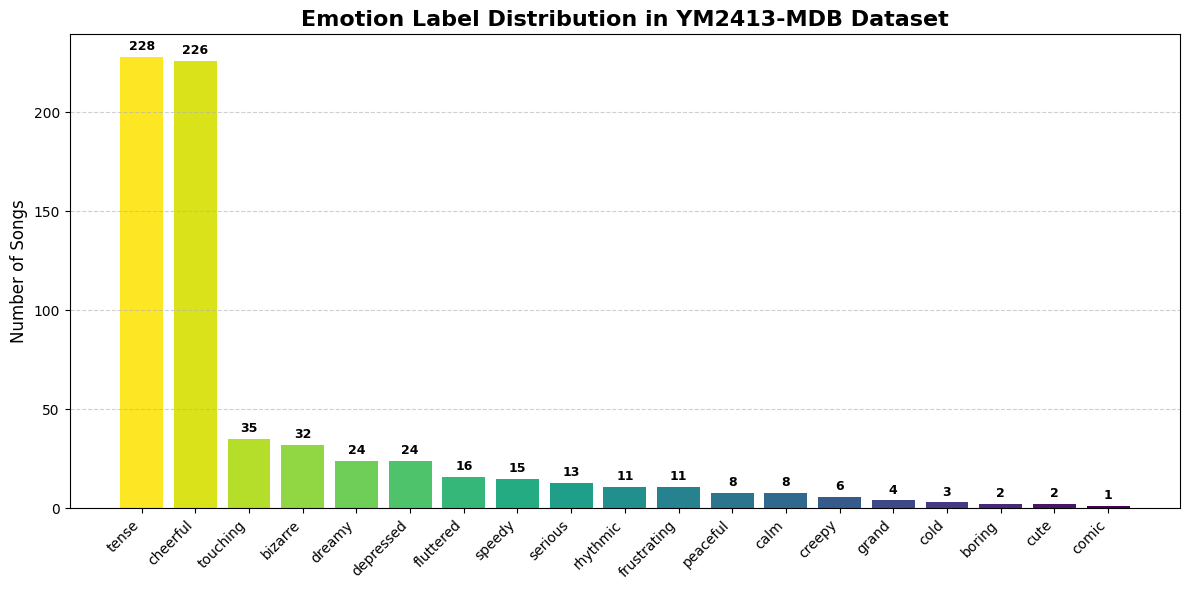

In [ ]:

def labeling_stats():
    emotion_csv_file = f"{data_folder}/emotion_annotation/verified_annotation.csv"
    emotion_json_file = f"{data_folder}/emotion_annotation/verified_annotation.json"
    TRACK_LABELS = json.load(open(emotion_json_file))
    labels_counts = Counter(TRACK_LABELS.values())
    labels_sorted = dict(sorted(labels_counts.items(), key=lambda x: x[1], reverse=True))
    colors = plt.cm.viridis_r(np.linspace(0, 1, len(labels_sorted)))

    plt.figure(figsize=(12,6))
    bars = plt.bar(labels_sorted.keys(), labels_sorted.values(), color=colors)

    # Add value labels on top of bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height + 2, str(height),
                ha='center', va='bottom', fontsize=9, fontweight='bold')

    # Professional styling
    plt.title("Emotion Label Distribution in YM2413-MDB Dataset", fontsize=16, weight='bold')
    plt.ylabel("Number of Songs", fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.6)

    plt.tight_layout()
    plt.show()

labeling_stats()

## 1. Midiprocessor and encoder

In [ ]:

class MIDIProcessor:
    """Advanced MIDI processing for chiptune generation with channel support"""

    def __init__(self, sample_rate=4, max_instruments=15):
        self.sample_rate = sample_rate  # samples per beat
        self.max_instruments = max_instruments
        self.note_range = (21, 108)  # MIDI note range (A0 to C8)
        self.ym2413_instruments = deepcopy(YM2413_PRESETS)

    def midi_to_tokens(self, midi_file_path, emotion_vector=None):
        """Original method for backward compatibility"""
        sequence, _ = self.midi_to_tokens_with_channels(midi_file_path)
        return sequence

    def midi_to_tokens_with_channels(self, midi_file_path):
        """Convert MIDI file to tokenized sequence with channel information"""
        try:
            # Load MIDI file
            midi = pretty_midi.PrettyMIDI(str(midi_file_path))

            # ADD THIS CHECK
            if midi.get_end_time() > 1000:  # Skip files longer than 1000 seconds
                print(f"Skipping {midi_file_path}: too long ({midi.get_end_time():.1f}s)")
                return torch.zeros(1, 16, 4, dtype=torch.float32), {'programs': {}}

            # Initialize channel info
            channel_info = {'programs': {}}

            # Initialize sequence with 16 channels (MIDI standard)
            sequence_length = int(midi.get_end_time() * self.sample_rate)
            sequence = np.zeros((sequence_length, 16, 4))  # 16 MIDI channels

            # Process each instrument
            for inst_idx, instrument in enumerate(midi.instruments):
                # Determine channel (use instrument index, but respect channel 9 for drums)
                if instrument.is_drum:
                    channel = 9  # Standard MIDI drum channel
                    # For drums, only set at the start time (not the full duration)
                    for note in instrument.notes:
                        start_time = int(note.start * self.sample_rate)

                        if start_time < sequence_length:
                            # Map drum notes to drum types (0-4 for YM2413)
                            drum_type = self._map_drum_note_to_type(note.pitch)
                            if drum_type is not None:
                                # For drums: [drum_type/5, velocity, duration, 1.0]
                                velocity_norm = note.velocity / 127.0
                                duration = min(int((note.end - note.start) * self.sample_rate), 16)
                                duration_norm = duration / 16.0  # Normalize to max 16 timesteps

                                # Only set at start time to avoid overwriting
                                sequence[start_time, channel] = [
                                    drum_type / 5.0,  # Normalized drum type
                                    velocity_norm,
                                    duration_norm,
                                    1.0  # Is active
                                ]
                else:
                    # Melodic instrument - map to available channels (skip 9)
                    if inst_idx < 9:
                        channel = inst_idx
                    elif inst_idx < 15:
                        channel = inst_idx + 1  # Skip channel 9
                    else:
                        continue  # Skip if too many instruments

                    # Store program (instrument type)
                    channel_info['programs'][channel] = instrument.program

                    # Process notes
                    for note in instrument.notes:
                        start_time = int(note.start * self.sample_rate)
                        end_time = int(note.end * self.sample_rate)

                        if start_time < sequence_length:
                            # Normalize features
                            pitch_norm = (note.pitch - self.note_range[0]) / (self.note_range[1] - self.note_range[0])
                            velocity_norm = note.velocity / 127.0
                            duration_norm = min((end_time - start_time) / self.sample_rate, 4.0) / 4.0

                            # Set note features [pitch, velocity, duration, is_note_on]
                            sequence[start_time:min(end_time, sequence_length), channel] = [
                                pitch_norm, velocity_norm, duration_norm, 1.0
                            ]

            return torch.tensor(sequence, dtype=torch.float32), channel_info

        except Exception as e:
            print(f"Error processing {midi_file_path}: {e}")
            # Return zeros with empty channel info on error
            return torch.zeros(1, 16, 4, dtype=torch.float32), {'programs': {}}

    def _map_drum_note_to_type(self, midi_note):
        """Map MIDI drum note to YM2413 drum type (0-4)"""
        drum_map = deepcopy(DRUM_MAP)
        return drum_map.get(midi_note)

    def tokens_to_midi_with_channels(self, sequence, channel_info, tempo=120, output_path="generated.mid"):
        """Convert token sequence back to MIDI with channel information"""
        midi = pretty_midi.PrettyMIDI(initial_tempo=tempo)

        # Process each channel
        for channel in range(sequence.shape[1]):
            if channel == 9:
                # Drum channel
                instrument = pretty_midi.Instrument(program=0, is_drum=True)

                # Track active drums
                active_drums = {}

                for time_step, features in enumerate(sequence[:, channel]):
                    drum_type_norm, velocity_norm, duration_norm, is_active = features

                    if is_active > 0.5:
                        drum_type = int(drum_type_norm * 5)

                        # Map drum type back to MIDI note
                        drum_note = self._get_drum_midi_note(drum_type)

                        if drum_note not in active_drums:
                            # Start new drum hit
                            velocity = int(velocity_norm * 127)
                            start_time = time_step / self.sample_rate

                            active_drums[drum_note] = {
                                'velocity': velocity,
                                'start': start_time
                            }
                    else:
                        # End active drum hits
                        for drum_note, drum_info in list(active_drums.items()):
                            end_time = time_step / self.sample_rate
                            note = pretty_midi.Note(
                                velocity=drum_info['velocity'],
                                pitch=drum_note,
                                start=drum_info['start'],
                                end=end_time
                            )
                            instrument.notes.append(note)
                            del active_drums[drum_note]

                # Close remaining drum hits
                for drum_note, drum_info in active_drums.items():
                    end_time = len(sequence) / self.sample_rate
                    note = pretty_midi.Note(
                        velocity=drum_info['velocity'],
                        pitch=drum_note,
                        start=drum_info['start'],
                        end=end_time
                    )
                    instrument.notes.append(note)

                if instrument.notes:
                    midi.instruments.append(instrument)

            else:
                # Melodic channel
                program = channel_info.get('programs', {}).get(channel, channel)
                instrument = pretty_midi.Instrument(program=program)

                current_note = None
                for time_step, features in enumerate(sequence[:, channel]):
                    pitch_norm, velocity_norm, duration_norm, is_note_on = features

                    if is_note_on > 0.5:  # Note is active
                        if current_note is None:  # Start new note
                            pitch = int(pitch_norm * (self.note_range[1] - self.note_range[0]) + self.note_range[0])
                            velocity = int(velocity_norm * 127)
                            start_time = time_step / self.sample_rate

                            current_note = {
                                'pitch': pitch,
                                'velocity': velocity,
                                'start': start_time
                            }
                    else:  # Note ended
                        if current_note is not None:
                            end_time = time_step / self.sample_rate
                            note = pretty_midi.Note(
                                velocity=current_note['velocity'],
                                pitch=current_note['pitch'],
                                start=current_note['start'],
                                end=end_time
                            )
                            instrument.notes.append(note)
                            current_note = None

                # Close any remaining notes
                if current_note is not None:
                    end_time = len(sequence) / self.sample_rate
                    note = pretty_midi.Note(
                        velocity=current_note['velocity'],
                        pitch=current_note['pitch'],
                        start=current_note['start'],
                        end=end_time
                    )
                    instrument.notes.append(note)

                if instrument.notes:
                    midi.instruments.append(instrument)

        midi.write(output_path)
        return midi

    def _get_drum_midi_note(self, drum_type):
        """Get MIDI note for YM2413 drum type"""
        drum_notes = {
            0: 36,  # Bass Drum
            1: 38,  # Snare
            2: 41,  # Tom
            3: 42,  # Hi-Hat
            4: 49   # Cymbal
        }
        return drum_notes.get(drum_type, 36)

    def tokens_to_midi(self, sequence, tempo=120, output_path="generated.mid"):
        """Backward compatible method"""
        # Assume no channel info for backward compatibility
        channel_info = {'programs': {}}
        return self.tokens_to_midi_with_channels(sequence, channel_info, tempo, output_path)

In [ ]:
# Russell's Circumplex Model Implementation
class RussellEmotionEncoder:
    """
    Russell's Circumplex Model for Emotion Encoding
    Maps emotions to 2D space: Valence (-1 to 1) × Arousal (-1 to 1)
    """

    def __init__(self):
        # Emotion mapping based on Russell's model
        self.emotion_mapping = deepcopy(VA_MAP)

        # Quadrant classification
        self.quadrants = {
            'happy': (1, 1),      # High arousal, positive valence
            'tensional': (-1, 1), # High arousal, negative valence
            'sad': (-1, -1),      # Low arousal, negative valence
            'peaceful': (1, -1)   # Low arousal, positive valence
        }

    def encode_emotion(self, emotion_str):
        """Convert emotion string to (valence, arousal) coordinates"""
        emotion_str = emotion_str.lower()
        if emotion_str in self.emotion_mapping:
            coords = self.emotion_mapping[emotion_str]
            # Ensure it's a list/tuple of exactly 2 values
            if len(coords) == 2:
                return torch.tensor(coords, dtype=torch.float32)
        # Default to neutral if emotion not found
        return torch.tensor([0.0, 0.0], dtype=torch.float32)

    def encode_coordinates(self, valence, arousal):
        """Direct encoding from valence/arousal coordinates"""
        # Clamp values to [-1, 1] range for safety
        valence = max(-1.0, min(1.0, valence))
        arousal = max(-1.0, min(1.0, arousal))
        return torch.tensor([valence, arousal], dtype=torch.float32)

    def classify_quadrant(self, valence, arousal):
        """Classify emotion into Russell's quadrants"""
        if valence >= 0 and arousal >= 0:
            return 'happy'
        elif valence < 0 and arousal >= 0:
            return 'tensional'
        elif valence < 0 and arousal < 0:
            return 'sad'
        else:
            return 'peaceful'


## 2. load files and emotions

In [ ]:
from pathlib import Path
from torch.utils.data import DataLoader, random_split
import json

def filter_long_files(data_folder, max_duration=1000):
    midi_folder = Path(f"{data_folder}/midi/adjust_tempo")
    # Get all MIDI files
    midi_files = list(midi_folder.glob("*.mid"))
    print(f"Found {len(midi_files)} MIDI files")

    midi_folder = Path(f"{data_folder}/midi/adjust_tempo")

    # Get all MIDI files
    midi_files = list(midi_folder.glob("*.mid"))
    midi_files = os.listdir(midi_folder)
    #midi_files = [(Path(midi_folder)/f, f) for f in midi_files if f.endswith('.mid')]

    TRACK_LABELS_MIDI = {f.replace('.wav', '.mid'): v for f, v in TRACK_LABELS.items()}
    len(set(TRACK_LABELS_MIDI.keys()).intersection(set(midi_files)))

    midi_files_full = [Path(midi_folder)/f for f in midi_files]
    filtered_files = []
    for f in midi_files_full:
        try:
            midi = pretty_midi.PrettyMIDI(str(f))
            if midi.get_end_time() < 600:  # Only files under 10 minutes
                filtered_files.append(f)
        except:
            pass
    print(f"Original Files: {len(midi_files_full)}. Valid files: {len(filtered_files)}")
    return filtered_files

def files_n_labels(data_folder):
    # label -> (valence, arousal) in [-1, 1]
    VA_MAP = {
    "cheerful": (0.80, 0.60), "dreamy": (0.40, -0.40), "peaceful": (0.70, -0.60),
    "tense": (-0.60, 0.70), "creepy": (-0.80, 0.50), "depressed": (-0.90, -0.60),
    "rhythmic": (0.20, 0.40), "bizarre": (-0.20, 0.50), "speedy": (0.20, 0.90),
    "fluttered": (0.20, 0.70), "grand": (0.60, 0.60), "serious": (-0.20, 0.10),
    "touching": (0.60, 0.10), "frustrating": (-0.60, 0.60), "cold": (-0.50, -0.30),
    "calm": (0.60, -0.50), "comic": (0.80, 0.40), "boring": (-0.40, -0.60),
    "cute": (0.70, 0.30),
    }
    emotion_json_file = f"{data_folder}/emotion_annotation/verified_annotation.json"
    TRACK_LABELS = json.load(open(emotion_json_file))

    ## no missing
    # [emo for emo in set(TRACK_LABELS.values())  if emo not in (VA_MAP.keys())]
    TRACK_LABELS_MIDI = {f.replace('.wav', '.mid'): v for f, v in TRACK_LABELS.items()}

    filtered_files = filter_long_files(data_folder)

    midi_files_full = [(f, f.stem+'.mid', TRACK_LABELS_MIDI[f.stem+'.mid'])
        for f in filtered_files if f.stem+'.mid' in TRACK_LABELS_MIDI]
    midi_files_full = {f:VA_MAP[g] for f, _, g in midi_files_full}

    train_files = list(midi_files_full.keys())
    return train_files, midi_files_full

In [ ]:
train_files, emotions = files_n_labels(data_folder)


Found 669 MIDI files
Original Files: 669. Valid files: 635


## 3. dataset

In [ ]:
# ym2413_instruments.py
# Usage:
#  mid folder : mid_file_folder

import sys
import os
from collections import Counter, defaultdict
from mido import MidiFile


drums = {
    35: "Bass Drum (BD)",
36: "Bass Drum (BD)",
38: "Snare Drum (SD)",
40: "Snare Drum (SD)",
41: "Tom-Tom (TOM)",
42: "Tom-Tom (TOM)",
43: "Tom-Tom (TOM)",
44: "Hi-Hat (HH)",
46: "Hi-Hat (HH)",
49: "Top Cymbal (TCY)",
51: "Top Cymbal (TCY)",
57: "Top Cymbal (TCY)"
}
# YM2413 preset names (0-14) + user-defined (15)
YM2413_PRESETS = {
    0:  "Violin",
    1:  "Guitar",
    2:  "Piano",
    3:  "Flute",
    4:  "Clarinet",
    5:  "Oboe",
    6:  "Trumpet",
    7:  "Organ",
    8:  "Horn",
    9:  "Square Synth",
    10: "Harpsichord",
    11: "Vibraphone",
    12: "Synth Bass",
    13: "Bass Guitar",
    14: "Cello",
    15: "User-Defined",
}

VA_MAP = {
 "cheerful": (0.80, 0.60), "dreamy": (0.40, -0.40), "peaceful": (0.70, -0.60),
 "tense": (-0.60, 0.70), "creepy": (-0.80, 0.50), "depressed": (-0.90, -0.60),
 "rhythmic": (0.20, 0.40), "bizarre": (-0.20, 0.50), "speedy": (0.20, 0.90),
 "fluttered": (0.20, 0.70), "grand": (0.60, 0.60), "serious": (-0.20, 0.10),
 "touching": (0.60, 0.10), "frustrating": (-0.60, 0.60), "cold": (-0.50, -0.30),
 "calm": (0.60, -0.50), "comic": (0.80, 0.40), "boring": (-0.40, -0.60),
 "cute": (0.70, 0.30),
}

DRUM_MAP = {
            # Bass Drum
            35: 0, 36: 0,
            # Snare
            38: 1, 40: 1,
            # Tom
            41: 2, 43: 2, 45: 2, 47: 2, 48: 2, 50: 2,
            # Hi-Hat
            42: 3, 44: 3, 46: 3,
            # Cymbal
            49: 4, 51: 4, 52: 4, 55: 4, 57: 4, 59: 4
        }

In [ ]:
class ChiptuneDataset(Dataset):
    """Enhanced dataset for PatchTST-LSTM model with proper channel handling"""

    def __init__(
        self,
        midi_files,
        emotions,
        processor,
        emotion_encoder,
        max_length=512,
        n_channels=16,
        feature_dim=4,
        drum_feature_dim=10,
        demo_mode=False
    ):
        self.midi_files = midi_files[:50] if demo_mode else midi_files
        self.emotions = emotions # dictionary
        self.processor = processor
        self.emotion_encoder = emotion_encoder
        self.max_length = max_length
        self.n_channels = n_channels  # 16 total MIDI channels
        self.feature_dim = feature_dim  # pitch, velocity, duration, is_note_on
        self.drum_feature_dim = drum_feature_dim  # 5 drums × 2 features

    def __len__(self):
        return len(self.midi_files)

    def __getitem__(self, idx):
        midi_file = self.midi_files[idx]

        try:
            # Process MIDI file
            sequence, channel_info = self.processor.midi_to_tokens_with_channels(midi_file)

            if sequence is None:
                raise ValueError(f"Failed to process {midi_file}")

            # Ensure shape [time, channels, features]
            current_length, current_channels, _ = sequence.shape

            # Create properly shaped tensor
            padded_sequence = torch.zeros(self.max_length, self.n_channels, self.feature_dim)

            # Handle each channel separately
            T = min(current_length, self.max_length)
            for ch in range(min(current_channels, self.n_channels)):
                if ch == 9:  # Percussion channel
                    # Special handling for drums - convert to binary + velocity format as needed
                    drum_data = sequence[:T, ch, :]
                    padded_sequence[:T, ch, :] = drum_data[:, :self.feature_dim]
                else:
                    # Regular melodic channel
                    padded_sequence[:T, ch, :] = sequence[:T, ch, :self.feature_dim]

            # Get emotion vector
            if midi_file in self.emotions:
                emotion = self.emotions[midi_file]
                if isinstance(emotion, str):
                    emotion_vector = self.emotion_encoder.encode_emotion(emotion)
                elif isinstance(emotion, (tuple, list)) and len(emotion) == 2:
                    emotion_vector = torch.tensor(emotion, dtype=torch.float32)
                else:
                    emotion_vector = torch.tensor([0.0, 0.0], dtype=torch.float32)
            else:
                emotion_vector = torch.tensor([0.0, 0.0], dtype=torch.float32)

            return padded_sequence, channel_info, emotion_vector

        except Exception as e:
            warnings.warn(f"Error processing {midi_file}: {e}")
            # Return default values
            return (
                torch.zeros(self.max_length, self.n_channels, self.feature_dim),
                {'programs': {}},
                torch.tensor([0.0, 0.0], dtype=torch.float32)
            )


## 4. quality eval

In [ ]:
class MusicEvaluator:
    """Comprehensive music evaluation metrics"""

    def __init__(self):
        self.note_range = (21, 108)  # MIDI note range

    def pitch_consistency(self, sequence):
        """Measure pitch variability (lower is more consistent)"""
        # Handle tensor/numpy conversion
        if torch.is_tensor(sequence):
            pitches = sequence[:, :, 0].detach().cpu().numpy()
        else:
            pitches = sequence[:, :, 0]

        active_pitches = pitches[pitches > 0]
        if len(active_pitches) > 0:
            pitch_std = np.std(active_pitches)
            return 1.0 / (pitch_std + 1e-6)
        return 0.0  # No active notes

    def duration_consistency(self, sequence):
        """Measure duration variability"""
        if torch.is_tensor(sequence):
            durations = sequence[:, :, 2].detach().cpu().numpy()
        else:
            durations = sequence[:, :, 2]

        active_durations = durations[durations > 0]
        if len(active_durations) > 0:
            duration_std = np.std(active_durations)
            return 1.0 / (duration_std + 1e-6)
        return 0.0

    def melodic_contour(self, sequence):
        """Measure smoothness of pitch transitions"""
        if torch.is_tensor(sequence):
            pitches = sequence[:, :, 0].detach().cpu().numpy()
        else:
            pitches = sequence[:, :, 0]

        intervals = []
        for inst in range(pitches.shape[1]):
            inst_pitches = pitches[:, inst]
            active_pitches = inst_pitches[inst_pitches > 0]
            if len(active_pitches) > 1:
                inst_intervals = np.abs(np.diff(active_pitches))
                intervals.extend(inst_intervals)

        if intervals:
            mean_interval = np.mean(intervals)
            # Smaller intervals = smoother melody = better score
            return np.exp(-mean_interval / 10.0)  # Exponential decay for better scaling
        return 0.0

    def note_density(self, sequence):
        """Calculate note density (notes per time unit)"""
        if torch.is_tensor(sequence):
            is_note_on = sequence[:, :, 3].detach().cpu().numpy()
        else:
            is_note_on = sequence[:, :, 3]

        total_notes = np.sum(is_note_on > 0.5)
        total_time = sequence.shape[0]
        density = total_notes / total_time if total_time > 0 else 0.0
        # Normalize to 0-1 range (assuming max ~5 notes per timestep average)
        return min(density / 5.0, 1.0)

    def dynamic_range(self, sequence):
        """Calculate velocity range (normalized)"""
        if torch.is_tensor(sequence):
            velocities = sequence[:, :, 1].detach().cpu().numpy()
        else:
            velocities = sequence[:, :, 1]

        active_velocities = velocities[velocities > 0]
        if len(active_velocities) > 0:
            # Already normalized 0-1, so range is also 0-1
            return np.max(active_velocities) - np.min(active_velocities)
        return 0.0

    def harmony_score(self, sequence):
        """Estimate harmonic content"""
        if torch.is_tensor(sequence):
            is_note_on = sequence[:, :, 3].detach().cpu().numpy()
        else:
            is_note_on = sequence[:, :, 3]

        simultaneous_notes = np.sum(is_note_on > 0.5, axis=1)
        # Count timesteps with 2+ notes (harmony)
        chord_timesteps = np.sum(simultaneous_notes > 1)
        total_timesteps = len(simultaneous_notes)
        return chord_timesteps / total_timesteps if total_timesteps > 0 else 0.0

    def melody_score(self, sequence):
        """Combined melody quality score"""
        pc = self.pitch_consistency(sequence)
        mc = self.melodic_contour(sequence)
        # Normalize scores to 0-1 range
        pc_norm = min(pc / 10.0, 1.0)  # Assuming max consistency ~10
        return (pc_norm + mc) / 2.0

    def rhythm_score(self, sequence):
        """Combined rhythm quality score"""
        dc = self.duration_consistency(sequence)
        dc_norm = min(dc / 10.0, 1.0)

        if torch.is_tensor(sequence):
            is_note_on = sequence[:, :, 3].detach().cpu().numpy()
        else:
            is_note_on = sequence[:, :, 3]

        onset_intervals = []
        for inst in range(is_note_on.shape[1]):
            onsets = np.where(is_note_on[:, inst] > 0.5)[0]
            if len(onsets) > 1:
                intervals = np.diff(onsets)
                onset_intervals.extend(intervals)

        if onset_intervals:
            # Lower std = more regular rhythm
            rhythm_regularity = np.exp(-np.std(onset_intervals) / 10.0)
        else:
            rhythm_regularity = 0.0

        return (dc_norm + rhythm_regularity) / 2.0

    def overall_structure_score(self, sequence):
        """Combined structure score"""
        nd = self.note_density(sequence)  # Already 0-1
        dr = self.dynamic_range(sequence)  # Already 0-1
        hs = self.harmony_score(sequence)  # Already 0-1
        return (nd + dr + hs) / 3.0

    def quality_score(self, sequence, weights=None):
        """Comprehensive quality score"""
        if weights is None:
            weights = {'melody': 2, 'harmony': 1, 'rhythm': 1, 'structure': 2}

        ms = self.melody_score(sequence)
        hs = self.harmony_score(sequence)
        rs = self.rhythm_score(sequence)
        oss = self.overall_structure_score(sequence)

        total_weight = sum(weights.values())
        weighted_score = (
            weights['melody'] * ms +
            weights['harmony'] * hs +
            weights['rhythm'] * rs +
            weights['structure'] * oss
        ) / total_weight

        # Scale to percentage
        return weighted_score * 100

    def emotion_alignment_score(self, sequence, target_emotion):
        """Score how well the music matches target emotion"""
        # Handle tensor conversion
        if torch.is_tensor(sequence):
            sequence_np = sequence.detach().cpu()
            pitch_mean = torch.mean(sequence_np[:, :, 0]).item()
        else:
            pitch_mean = np.mean(sequence[:, :, 0])

        # Extract musical features
        tempo_proxy = self.note_density(sequence)
        dynamics = self.dynamic_range(sequence)

        # Map to emotion space (improved mapping)
        # Arousal: combination of tempo and dynamics
        predicted_arousal = np.tanh(tempo_proxy * 2 + dynamics)  # -1 to 1

        # Valence: pitch height and harmony
        harmony = self.harmony_score(sequence)
        # Normalize pitch to 0-1, then map to -1 to 1
        predicted_valence = (pitch_mean * 2 - 1) * 0.7 + harmony * 0.3
        predicted_valence = np.clip(predicted_valence, -1, 1)

        # Calculate distance from target
        target_valence, target_arousal = target_emotion
        distance = np.sqrt(
            (predicted_valence - target_valence) ** 2 +
            (predicted_arousal - target_arousal) ** 2
        )

        # Convert distance to similarity score
        max_distance = 2.828  # sqrt(2^2 + 2^2) for -1 to 1 range
        similarity = 1.0 - (distance / max_distance)
        return similarity * 100

    def evaluate_batch(self, sequences, emotions=None):
        """Evaluate a batch of sequences"""
        results = {
            'quality_scores': [],
            'melody_scores': [],
            'harmony_scores': [],
            'rhythm_scores': [],
            'structure_scores': [],
            'emotion_alignment_scores': []
        }

        for i, seq in enumerate(sequences):
            # Check if sequence has any notes
            if torch.is_tensor(seq):
                has_notes = seq[:, :, 3].sum() > 0
            else:
                has_notes = seq[:, :, 3].sum() > 0

            if not has_notes:
                # Skip empty sequences
                continue

            # Quality metrics
            results['quality_scores'].append(self.quality_score(seq))
            results['melody_scores'].append(self.melody_score(seq) * 100)
            results['harmony_scores'].append(self.harmony_score(seq) * 100)
            results['rhythm_scores'].append(self.rhythm_score(seq) * 100)
            results['structure_scores'].append(self.overall_structure_score(seq) * 100)

            # Emotion alignment
            if emotions is not None and i < len(emotions):
                if torch.is_tensor(emotions[i]):
                    emotion_np = emotions[i].detach().cpu().numpy()
                else:
                    emotion_np = emotions[i]
                emotion_score = self.emotion_alignment_score(seq, emotion_np)
                results['emotion_alignment_scores'].append(emotion_score)

        # Calculate averages
        for key in results:
            if results[key]:
                results[f'avg_{key}'] = float(np.mean(results[key]))
                results[f'std_{key}'] = float(np.std(results[key]))
            else:
                results[f'avg_{key}'] = 0.0
                results[f'std_{key}'] = 0.0

        return results

## quality eval 2

In [ ]:
class MusicEvaluator:
    """Comprehensive music evaluation metrics"""

    def __init__(self):
        self.note_range = (21, 108)  # MIDI note range

    def pitch_consistency(self, sequence):
        """Measure pitch variability (lower is more consistent)"""
        # Extract pitch information
        pitches = sequence[:, :, 0].cpu().numpy()  # [time, instruments]
        pitch_std = np.std(pitches[pitches > 0])  # Only consider active notes
        return 1.0 / (pitch_std + 1e-6)  # Invert so higher is better

    def duration_consistency(self, sequence):
        """Measure duration variability"""
        durations = sequence[:, :, 2].cpu().numpy()
        duration_std = np.std(durations[durations > 0])
        return 1.0 / (duration_std + 1e-6)

    def melodic_contour(self, sequence):
        """Measure smoothness of pitch transitions"""
        pitches = sequence[:, :, 0].cpu().numpy()

        # Calculate pitch intervals
        intervals = []
        for inst in range(pitches.shape[1]):
            inst_pitches = pitches[:, inst]
            active_pitches = inst_pitches[inst_pitches > 0]
            if len(active_pitches) > 1:
                inst_intervals = np.abs(np.diff(active_pitches))
                intervals.extend(inst_intervals)

        if intervals:
            mean_interval = np.mean(intervals)
            return 1.0 / (mean_interval + 1e-6)
        return 0.0

    def note_density(self, sequence):
        """Calculate note density (notes per time unit)"""
        is_note_on = sequence[:, :, 3].cpu().numpy()
        total_notes = np.sum(is_note_on > 0.5)
        total_time = sequence.shape[0]
        return total_notes / total_time if total_time > 0 else 0.0

    def dynamic_range(self, sequence):
        """Calculate velocity range"""
        velocities = sequence[:, :, 1].cpu().numpy()
        active_velocities = velocities[velocities > 0]
        if len(active_velocities) > 0:
            return np.max(active_velocities) - np.min(active_velocities)
        return 0.0

    def harmony_score(self, sequence):
        """Estimate harmonic content"""
        # Count simultaneous notes (chords)
        is_note_on = sequence[:, :, 3].cpu().numpy()
        simultaneous_notes = np.sum(is_note_on > 0.5, axis=1)
        chord_timesteps = np.sum(simultaneous_notes > 1)
        total_timesteps = len(simultaneous_notes)
        return chord_timesteps / total_timesteps if total_timesteps > 0 else 0.0

    def melody_score(self, sequence):
        """Combined melody quality score"""
        pc = self.pitch_consistency(sequence)
        mc = self.melodic_contour(sequence)
        return (pc + mc) / 2.0

    def rhythm_score(self, sequence):
        """Combined rhythm quality score"""
        dc = self.duration_consistency(sequence)
        # Add rhythm regularity measure
        is_note_on = sequence[:, :, 3].cpu().numpy()
        onset_intervals = []

        for inst in range(is_note_on.shape[1]):
            onsets = np.where(is_note_on[:, inst] > 0.5)[0]
            if len(onsets) > 1:
                intervals = np.diff(onsets)
                onset_intervals.extend(intervals)

        if onset_intervals:
            rhythm_regularity = 1.0 / (np.std(onset_intervals) + 1e-6)
        else:
            rhythm_regularity = 0.0

        return (dc + rhythm_regularity) / 2.0

    def overall_structure_score(self, sequence):
        """Combined structure score"""
        nd = self.note_density(sequence)
        dr = self.dynamic_range(sequence)
        hs = self.harmony_score(sequence)
        return (nd + dr + hs) / 3.0

    def quality_score(self, sequence, weights=None):
        """Comprehensive quality score"""
        if weights is None:
            weights = {'melody': 2, 'harmony': 1, 'rhythm': 1, 'structure': 2}

        ms = self.melody_score(sequence)
        hs = self.harmony_score(sequence)
        rs = self.rhythm_score(sequence)
        oss = self.overall_structure_score(sequence)

        total_weight = sum(weights.values())
        weighted_score = (
            weights['melody'] * ms +
            weights['harmony'] * hs +
            weights['rhythm'] * rs +
            weights['structure'] * oss
        ) / total_weight

        # Scale to percentage
        return weighted_score * 100

    def emotion_alignment_score(self, sequence, target_emotion):
        """Score how well the music matches target emotion"""
        # Extract musical features that correlate with emotions
        tempo_proxy = self.note_density(sequence)  # Higher density ~ higher arousal
        dynamics = self.dynamic_range(sequence)     # Higher dynamics ~ more expressive
        pitch_height = torch.mean(sequence[:, :, 0]).item()  # Higher pitch ~ more positive

        # Map to emotion space
        predicted_arousal = min(tempo_proxy * 2, 1.0)  # Scale appropriately
        predicted_valence = pitch_height * 2 - 1  # Map to [-1, 1]

        # Calculate distance from target
        target_valence, target_arousal = target_emotion
        distance = np.sqrt(
            (predicted_valence - target_valence) ** 2 +
            (predicted_arousal - target_arousal) ** 2
        )

        # Convert distance to similarity score
        max_distance = np.sqrt(2)  # Maximum possible distance in emotion space
        similarity = 1.0 - (distance / max_distance)
        return similarity * 100

    def evaluate_batch(self, sequences, emotions=None):
        """Evaluate a batch of sequences"""
        results = {
            'quality_scores': [],
            'melody_scores': [],
            'harmony_scores': [],
            'rhythm_scores': [],
            'structure_scores': [],
            'emotion_alignment_scores': []
        }

        for i, seq in enumerate(sequences):
            # Quality metrics
            results['quality_scores'].append(self.quality_score(seq))
            results['melody_scores'].append(self.melody_score(seq))
            results['harmony_scores'].append(self.harmony_score(seq) * 100)
            results['rhythm_scores'].append(self.rhythm_score(seq))
            results['structure_scores'].append(self.overall_structure_score(seq) * 100)

            # Emotion alignment
            if emotions is not None and i < len(emotions):
                emotion_score = self.emotion_alignment_score(seq, emotions[i].cpu().numpy())
                results['emotion_alignment_scores'].append(emotion_score)

        # Calculate averages
        for key in results:
            if results[key]:
                results[f'avg_{key}'] = np.mean(results[key])
                results[f'std_{key}'] = np.std(results[key])

        return results

## 5. training manager

In [ ]:
class EnhancedTrainingManager:
    """Training manager optimized for PatchTST-LSTM model"""

    def __init__(self, model, device, checkpoint_dir="checkpoints", use_percussion_loss=True):
        self.model = model.to(device)
        self.device = device
        self.checkpoint_dir = Path(checkpoint_dir)
        self.checkpoint_dir.mkdir(exist_ok=True)
        self.use_percussion_loss = use_percussion_loss
        self.evaluator = MusicEvaluator()
        # Optimizers with different learning rates for different components
        self.optimizer = self._create_optimizer()

        # Schedulers
        self.scheduler = None
        # Mixed precision training
        self.scaler = GradScaler()

        # Loss functions
        self.melodic_loss_fn = nn.MSELoss()
        self.drum_loss_fn = nn.BCELoss()  # For drum presence
        self.temporal_loss_fn = nn.L1Loss()  # For temporal coherence

        # Training state
        self.epoch = 0
        self.step = 0
        self.best_loss = float('inf')
        self.training_history = []
        self.validation_history = []

    def _create_optimizer(self):
        """Create optimizer with parameter groups"""
        # Different learning rates for different components
        param_groups = [
            # Transformer parameters - lower lr
            {
                'params': [p for name, p in self.model.named_parameters() if 'transformer' in name],
                'lr': 5e-5, 'weight_decay': 1e-4
            },

            # LSTM parameters - medium lr
            {
                'params': [p for name, p in self.model.named_parameters() if 'lstm' in name],
                'lr': 1e-4, 'weight_decay': 1e-5
            },

            # Embedding parameters - higher lr
            {
                'params': [p for name, p in self.model.named_parameters() if 'embedding' in name],
                'lr': 2e-4, 'weight_decay': 1e-5
            },

            # Other parameters
            {
                'params': [
                    p for name, p in self.model.named_parameters()
                    if not any(x in name for x in ['transformer', 'lstm', 'embedding'])
                ],
                'lr': 1e-4, 'weight_decay': 1e-5
            }
        ]

        return optim.AdamW(param_groups, betas=(0.9, 0.999), eps=1e-8)

    def compute_loss(self, output, target, channel_info):
        """Compute combined loss for PatchTST-LSTM model"""
        batch_size, seq_len, n_channels, n_features = output.shape
        device = output.device

        total_loss = torch.tensor(0.0, device=device, requires_grad=True)
        loss_components = {}

        # 1. Melodic reconstruction loss
        melodic_mask = torch.ones(n_channels, dtype=torch.bool, device=device)
        if n_channels > 9:
            melodic_mask[9] = False  # Exclude percussion channel

        melodic_output = output[:, :, melodic_mask, :]
        melodic_target = target[:, :, melodic_mask, :]

        # Check if there's any melodic data
        if melodic_output.numel() > 0:
            melodic_loss = self.melodic_loss_fn(melodic_output, melodic_target)
            total_loss = total_loss + melodic_loss
            loss_components['melodic'] = melodic_loss.detach().item()
        else:
            loss_components['melodic'] = 0.0

        # 2. Percussion loss (simplified and stable)
        if self.use_percussion_loss and n_channels > 9:
            drum_target_sum = target[:, :, 9, :].abs().sum()
            if drum_target_sum > 1e-6:  # More robust check
                drum_output = output[:, :, 9, :]
                drum_target = target[:, :, 9, :]

                # MSE for all drum features
                drum_loss = self.melodic_loss_fn(drum_output, drum_target)

                # Add focus on active drum hits (where is_active > 0.5)
                if n_features >= 4:
                    is_active = drum_target[:, :, 3] > 0.5
                    if is_active.any():
                        # Extra weight on active positions
                        active_loss = F.mse_loss(
                            drum_output[is_active],
                            drum_target[is_active]
                        )
                        drum_loss = drum_loss * 0.7 + active_loss * 0.3

                total_loss = total_loss + drum_loss * 0.3
                loss_components['drums'] = drum_loss.detach().item()
            else:
                loss_components['drums'] = 0.0
        else:
            loss_components['drums'] = 0.0

        # 3. Temporal coherence loss
        if seq_len > 1:
            # Calculate differences
            output_diff = output[:, 1:, :, :] - output[:, :-1, :, :]
            target_diff = target[:, 1:, :, :] - target[:, :-1, :, :]

            # Use L1 loss for robustness
            temporal_loss = self.temporal_loss_fn(output_diff, target_diff)

            # Scale based on sequence length (longer sequences need less weight)
            temporal_weight = 0.1 * min(1.0, 128 / seq_len)
            total_loss = total_loss + temporal_loss * temporal_weight
            loss_components['temporal'] = temporal_loss.detach().item()
        else:
            loss_components['temporal'] = 0.0

        # 4. Patch boundary smoothness
        if hasattr(self.model, 'stride') and self.model.stride > 0:
            stride = self.model.stride
            boundary_loss = torch.tensor(0.0, device=device)

            # Calculate boundary positions
            boundaries = list(range(stride, min(seq_len, stride * 10), stride))

            if boundaries:
                for idx in boundaries:
                    if idx < seq_len:
                        # Smoothness between patches
                        diff = torch.abs(output[:, idx, :, :] - output[:, idx-1, :, :])
                        # Focus on melodic channels
                        if n_channels > 9:
                            melodic_diff = diff[:, melodic_mask, :]
                        else:
                            melodic_diff = diff
                        boundary_loss = boundary_loss + melodic_diff.mean()

                # Normalize by number of boundaries
                boundary_loss = boundary_loss / len(boundaries)
                total_loss = total_loss + boundary_loss * 0.01
                loss_components['boundary'] = boundary_loss.detach().item()
        else:
            loss_components['boundary'] = 0.0

        # 5. Add regularization to prevent explosion
        if output.abs().max() > 5.0:  # Output values should be in [0,1]
            regularization = (output.abs() - 1.0).clamp(min=0).mean()
            total_loss = total_loss + regularization * 0.1
            loss_components['regularization'] = regularization.detach().item()

        # Ensure total_loss is scalar
        if total_loss.dim() > 0:
            total_loss = total_loss.mean()

        return total_loss, loss_components

    def train_epoch(self, dataloader):
        """Train for one epoch"""
        self.model.train()
        epoch_losses = []
        epoch_components = {'melodic': [], 'drums': [], 'temporal': []}

        pbar = tqdm(dataloader, desc=f"Epoch {self.epoch + 1}")

        for batch_idx, (sequences, channel_infos, emotions) in enumerate(pbar):
            sequences = sequences.to(self.device)
            emotions = emotions.to(self.device)

            ##### @@@ remove. test only
            sequences = sequences.to(self.device)
            emotions = emotions.to(self.device)

            # Debug: Check if channel 9 has any data
            if sequences.shape[2] > 9:
                drum_sum = sequences[:, :, 9, :].abs().sum().item()
                if drum_sum > 0:
                    print(f"Batch has drums! Sum: {drum_sum}")
                else:
                    print("No drums in this batch")

            ##### @@@ remove. test only


            # NOTE: channel_infos is a list (one dict per item). If your collate_fn stacks dicts,
            # adjust this. Here we pass channel_infos[0] to match your original code.
            outputs = self.model(sequences, channel_infos[0], emotions)
            loss, loss_components = self.compute_loss(outputs, sequences, channel_infos[0])

            # Backward pass
            self.optimizer.zero_grad()
            self.scaler.scale(loss).backward()

            # Gradient clipping
            self.scaler.unscale_(self.optimizer)
            grad_norm = torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)

            # Optimizer step
            self.scaler.step(self.optimizer)
            self.scaler.update()
            self.scheduler.step()

            # Track losses
            epoch_losses.append(float(loss.item()))
            for key, value in loss_components.items():
                if key in epoch_components:
                    epoch_components[key].append(value)

            # Update progress bar
            pbar.set_postfix({
                'Loss': f"{loss.item():.4f}",
                'Mel': f"{loss_components.get('melodic', 0):.4f}",
                'Drum': f"{loss_components.get('drums', 0):.4f}",
                'Temp': f"{loss_components.get('temporal', 0):.4f}",
                'Grad': f"{float(grad_norm):.3f}",
                'LR': f"{self.scheduler.get_last_lr()[0]:.6f}"
            })

            self.step += 1

            # Save checkpoint every 500 steps
            if self.step % 500 == 0:
                self.save_checkpoint(loss.item())

        # Return epoch statistics
        return {
            'loss': float(np.mean(epoch_losses)) if epoch_losses else 0.0,
            'components': {k: float(np.mean(v)) if v else 0.0 for k, v in epoch_components.items()}
        }

    def validate(self, dataloader):
        """Validation pass"""
        self.model.eval()
        val_losses = []

        with torch.no_grad():
            for sequences, channel_infos, emotions in dataloader:
                sequences = sequences.to(self.device)
                emotions = emotions.to(self.device)

                outputs = self.model(sequences, channel_infos[0], emotions)
                loss, _ = self.compute_loss(outputs, sequences, channel_infos[0])
                val_losses.append(float(loss.item()))

        return float(np.mean(val_losses)) if val_losses else 0.0

    def validate_with_eval(self, dataloader):
        """Enhanced validation with quality metrics"""
        self.model.eval()
        val_losses = []

        # Metrics storage
        quality_scores = []
        melody_scores = []
        rhythm_scores = []
        harmony_scores = []
        emotion_scores = []

        with torch.no_grad():
            for sequences, channel_infos, emotions in dataloader:
                sequences = sequences.to(self.device)
                emotions = emotions.to(self.device)

                # Get model outputs
                outputs = self.model(sequences, channel_infos[0], emotions)

                # Calculate loss
                loss, _ = self.compute_loss(outputs, sequences, channel_infos[0])
                val_losses.append(float(loss.item()))

                # Evaluate each sample in batch
                outputs_cpu = outputs.cpu()
                emotions_cpu = emotions.cpu()

                for i in range(outputs_cpu.shape[0]):
                    # Quality metrics
                    quality = self.evaluator.quality_score(outputs_cpu[i])
                    melody = self.evaluator.melody_score(outputs_cpu[i])
                    rhythm = self.evaluator.rhythm_score(outputs_cpu[i])
                    harmony = self.evaluator.harmony_score(outputs_cpu[i])

                    quality_scores.append(quality)
                    melody_scores.append(melody)
                    rhythm_scores.append(rhythm)
                    harmony_scores.append(harmony * 100)  # Scale to percentage

                    # Emotion alignment
                    if i < len(emotions_cpu):
                        emotion_score = self.evaluator.emotion_alignment_score(
                            outputs_cpu[i],
                            emotions_cpu[i].numpy()
                        )
                        emotion_scores.append(emotion_score)

        # Calculate averages
        results = {
            'loss': float(np.mean(val_losses)) if val_losses else 0.0,
            'quality': float(np.mean(quality_scores)) if quality_scores else 0.0,
            'melody': float(np.mean(melody_scores)) if melody_scores else 0.0,
            'rhythm': float(np.mean(rhythm_scores)) if rhythm_scores else 0.0,
            'harmony': float(np.mean(harmony_scores)) if harmony_scores else 0.0,
            'emotion': float(np.mean(emotion_scores)) if emotion_scores else 0.0
        }

        # Print detailed metrics
        print(f"    📊 Validation Metrics:")
        print(f"       Loss: {results['loss']:.4f}")
        print(f"       Quality: {results['quality']:.1f}%")
        print(f"       Melody: {results['melody']:.1f}%")
        print(f"       Rhythm: {results['rhythm']:.1f}%")
        print(f"       Harmony: {results['harmony']:.1f}%")
        print(f"       Emotion Alignment: {results['emotion']:.1f}%")

        # Store for tracking (optional)
        if not hasattr(self, 'quality_history'):
            self.quality_history = []
        self.quality_history.append(results['quality'])

        return results['loss']

    def train(self, train_loader, val_loader=None, num_epochs=50):
        """Main training loop"""
        # Update scheduler total steps
        self.scheduler = optim.lr_scheduler.OneCycleLR(
            self.optimizer,
            max_lr=5e-5,
            total_steps=len(train_loader) * num_epochs,
            pct_start=0.1,
            div_factor=10,
            final_div_factor=100,
            anneal_strategy='cos'
        )

        print(f"🚀 Starting training for {num_epochs} epochs")
        print(f"📊 Training samples: {len(train_loader.dataset)}")
        print(f"🔥 Device: {self.device}")
        print(f"🎵 Model parameters: {sum(p.numel() for p in self.model.parameters()):,}")

        for epoch in range(num_epochs):
            self.epoch = epoch
            epoch_start = time.time()

            # Training
            train_stats = self.train_epoch(train_loader)
            self.training_history.append(train_stats)

            # Validation
            if val_loader:
                val_loss = self.validate(val_loader)
                self.validation_history.append(val_loss)

                # Check if best model
                if val_loss < self.best_loss:
                    self.best_loss = val_loss
                    self.save_checkpoint(val_loss, is_best=True)

                print(
                    f"📈 Epoch {epoch + 1}/{num_epochs} - "
                    f"Train: {train_stats['loss']:.4f} | "
                    f"Val: {val_loss:.4f} | "
                    f"Best: {self.best_loss:.4f} | "
                    f"Time: {time.time() - epoch_start:.1f}s"
                )
            else:
                # Save based on training loss
                if train_stats['loss'] < self.best_loss:
                    self.best_loss = train_stats['loss']
                    self.save_checkpoint(train_stats['loss'], is_best=True)

                print(
                    f"📈 Epoch {epoch + 1}/{num_epochs} - "
                    f"Loss: {train_stats['loss']:.4f} | "
                    f"Components: Mel={train_stats['components']['melodic']:.4f}, "
                    f"Drum={train_stats['components'].get('drums', 0):.4f}, "
                    f"Temp={train_stats['components'].get('temporal', 0):.4f} | "
                    f"Time: {time.time() - epoch_start:.1f}s"
                )

            # Early stopping
            if self._check_early_stopping():
                print("🛑 Early stopping triggered")
                break

        print("🎉 Training completed!")
        return self.training_history, self.validation_history

    def _check_early_stopping(self, patience=10):
        """Check if should stop early"""
        if len(self.validation_history) < patience:
            return False

        recent = self.validation_history[-patience:]
        return all(loss > self.best_loss * 1.05 for loss in recent[-5:])

    def save_checkpoint(self, loss, is_best=False):
        """Save training checkpoint"""
        checkpoint = {
            'epoch': self.epoch,
            'step': self.step,
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'scheduler_state_dict': self.scheduler.state_dict(),
            'scaler_state_dict': self.scaler.state_dict(),
            'loss': loss,
            'best_loss': self.best_loss,
            'training_history': self.training_history,
            'validation_history': self.validation_history
        }

        # Regular checkpoint
        if self.step % 500 == 0:
            checkpoint_path = self.checkpoint_dir / f"checkpoint_step_{self.step}.pt"
            torch.save(checkpoint, checkpoint_path)

        # Best model
        if is_best:
            best_path = self.checkpoint_dir / "best_model.pt"
            torch.save(checkpoint, best_path)
            print(f"💾 Saved best model with loss: {loss:.4f}")

    def load_checkpoint(self, checkpoint_path):
        """Load checkpoint"""
        checkpoint = torch.load(checkpoint_path, map_location=self.device)

        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

        if 'scheduler_state_dict' in checkpoint:
            self.scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        if 'scaler_state_dict' in checkpoint:
            self.scaler.load_state_dict(checkpoint['scaler_state_dict'])

        self.epoch = checkpoint.get('epoch', 0)
        self.step = checkpoint.get('step', 0)
        self.best_loss = checkpoint.get('best_loss', float('inf'))
        self.training_history = checkpoint.get('training_history', [])
        self.validation_history = checkpoint.get('validation_history', [])

        print(f"📂 Loaded checkpoint from epoch {self.epoch}, step {self.step}")

## models

### hybrid

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import warnings


class MusicalPatchTSTLSTM(nn.Module):
    """
    Enhanced PatchTST with LSTM layers for improved temporal modeling

    Key Enhancements:
    - Transformer for local pattern recognition within patches
    - LSTM for long-term dependencies across patches
    - Specialized percussion processing with rhythm-focused LSTM
    - Temporal smoothing at output layer
    """

    def __init__(
        self,
        patch_length=16,        # beats per patch for melody
        stride=8,               # overlap between patches
        n_melodic_channels=15,  # All channels except 9
        n_drum_types=5,         # YM2413 has 5 drum sounds
        d_model=256,            # model dimension
        n_heads=8,              # attention heads
        n_layers=6,             # transformer layers
        lstm_layers=2,          # LSTM layers
        dropout=0.2,
        max_instruments=128     # General MIDI programs
    ):
        super().__init__()

        self.patch_length = patch_length
        self.stride = stride
        self.n_melodic_channels = n_melodic_channels
        self.n_drum_types = n_drum_types
        self.d_model = d_model

        # ============ MELODIC COMPONENTS ============
        # Map actual channel numbers (0-15 except 9) to indices
        self.channel_mapping = {}
        idx = 0
        for ch in range(16):
            if ch != 9:  # Skip percussion channel
                self.channel_mapping[ch] = idx
                idx += 1

        # Patch embedding for each melodic channel - output full d_model
        self.melodic_patch_embeddings = nn.ModuleList([
            nn.Linear(patch_length * 4, d_model)  # Changed to output full d_model
            for _ in range(n_melodic_channels)
        ])

        # Program (instrument) embedding
        self.program_embedding = nn.Embedding(max_instruments, d_model // 4)

        # Projection to combine patch and program embeddings
        self.melodic_input_projection = nn.ModuleList([
            nn.Linear(d_model + d_model // 4, d_model)
            for _ in range(n_melodic_channels)
        ])

        # Melodic transformers (one per channel for independence)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=n_heads,
            dim_feedforward=d_model * 4,
            dropout=dropout,
            activation='gelu',
            batch_first=True
        )

        self.melodic_transformers = nn.ModuleList([
            nn.TransformerEncoder(encoder_layer, num_layers=n_layers)
            for _ in range(n_melodic_channels)
        ])

        # ============ LSTM LAYERS FOR TEMPORAL MODELING ============
        # Bidirectional LSTM for melodic channels
        self.melodic_lstm = nn.ModuleList([
            nn.LSTM(
                input_size=d_model,
                hidden_size=d_model // 2,
                num_layers=lstm_layers,
                batch_first=True,
                bidirectional=True,
                dropout=dropout if lstm_layers > 1 else 0
            )
            for _ in range(n_melodic_channels)
        ])

        # Output LSTMs for temporal smoothing
        self.output_smoothing_lstm = nn.ModuleList([
            nn.LSTM(
                input_size=4,  # 4 features per timestep
                hidden_size=8,
                num_layers=1,
                batch_first=True,
                bidirectional=False
            )
            for _ in range(n_melodic_channels)
        ])

        self.output_smoothing_projection = nn.ModuleList([
            nn.Linear(8, 4)
            for _ in range(n_melodic_channels)
        ])

        # Output projections for melodic channels
        self.melodic_output_projections = nn.ModuleList([
            nn.Linear(d_model, patch_length * 4)
            for _ in range(n_melodic_channels)
        ])

        # ============ PERCUSSION COMPONENTS ============
        # Percussion uses shorter patches
        self.drum_patch_length = patch_length // 4  # 4 beats
        self.drum_stride = self.drum_patch_length // 2

        # Drum embedding - fixed to use actual feature dimension
        self.drum_patch_embedding = nn.Linear(
            self.drum_patch_length * 4,  # 4 features per timestep
            d_model
        )

        # Lighter transformer for drums
        drum_encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=n_heads,
            dim_feedforward=d_model * 2,
            dropout=dropout,
            activation='gelu',
            batch_first=True
        )

        self.drum_transformer = nn.TransformerEncoder(
            drum_encoder_layer,
            num_layers=max(n_layers // 2, 2)
        )

        # LSTM for drum patterns
        self.drum_lstm = nn.LSTM(
            input_size=d_model,
            hidden_size=d_model,
            num_layers=lstm_layers,
            batch_first=True,
            bidirectional=False,
            dropout=dropout if lstm_layers > 1 else 0,
        )

        # Drum pattern memory
        self.drum_pattern_memory = nn.Parameter(
            torch.randn(20, d_model) * 0.02
        )

        # Attention for selecting rhythm patterns
        self.rhythm_pattern_attention = nn.MultiheadAttention(
            embed_dim=d_model,
            num_heads=4,
            batch_first=True
        )

        # Drum output projection - FIXED to output correct dimensions
        self.drum_output_projection = nn.Linear(
            d_model,
            self.drum_patch_length * 4  # Match input: 4 features per timestep
        )

        # Drum output smoothing - FIXED dimensions
        self.drum_smoothing_lstm = nn.LSTM(
            input_size=4,  # 4 features
            hidden_size=8,
            num_layers=1,
            batch_first=True
        )
        self.drum_smoothing_projection = nn.Linear(8, 4)

        # ============ CROSS-MODAL INTERACTION ============
        self.melody_to_rhythm_attention = nn.MultiheadAttention(
            embed_dim=d_model,
            num_heads=n_heads // 2,
            batch_first=True,
            dropout=dropout
        )

        self.rhythm_to_melody_attention = nn.MultiheadAttention(
            embed_dim=d_model,
            num_heads=n_heads // 2,
            batch_first=True,
            dropout=dropout
        )

        # Cross-modal LSTM
        self.cross_modal_lstm = nn.LSTM(
            input_size=d_model * 2,
            hidden_size=d_model,
            num_layers=1,
            batch_first=True,
            bidirectional=True
        )
        self.cross_modal_projection = nn.Linear(d_model * 2, d_model)

        # ============ SHARED COMPONENTS ============
        # Positional encoding - FIXED shape
        self.melodic_positional_encoding = nn.Parameter(
            torch.randn(1, 1000, d_model) * 0.02
        )
        self.drum_positional_encoding = nn.Parameter(
            torch.randn(1, 1000, d_model) * 0.02
        )

        # Emotion conditioning
        self.emotion_projection = nn.Linear(2, d_model)
        self.emotion_to_rhythm = nn.Linear(2, d_model // 2)

        # Temporal embeddings - FIXED to smaller dimensions
        self.beat_embedding = nn.Embedding(16, d_model // 4)
        self.measure_embedding = nn.Embedding(100, d_model // 4)
        self.phrase_embedding = nn.Embedding(20, d_model // 4)

        # Temporal projection layer
        self.temporal_projection = nn.Linear(d_model // 4 * 3, d_model)

        # Normalization and regularization
        self.layer_norm = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

        # Output activation
        self.sigmoid = nn.Sigmoid()

        # Mode detection
        self.has_percussion = False

    def create_melodic_patches(self, sequence):
        """Convert melodic sequence to patches"""
        batch_size, seq_len, n_features = sequence.shape
        device = sequence.device

        if seq_len < self.patch_length:
            # Pad sequence if too short
            padding = self.patch_length - seq_len
            sequence = F.pad(sequence, (0, 0, 0, padding))
            seq_len = self.patch_length

        patches = []
        for i in range(0, seq_len - self.patch_length + 1, self.stride):
            patch = sequence[:, i:i + self.patch_length, :]
            patch_flat = patch.reshape(batch_size, -1)
            patches.append(patch_flat)

        if not patches:  # Edge case handling
            patch = sequence[:, :self.patch_length, :]
            patch_flat = patch.reshape(batch_size, -1)
            patches.append(patch_flat)

        return torch.stack(patches, dim=1)

    def create_drum_patches(self, drum_sequence):
        """Convert drum sequence to shorter patches"""
        batch_size, seq_len, n_features = drum_sequence.shape
        device = drum_sequence.device

        if seq_len < self.drum_patch_length:
            # Pad if too short
            padding = self.drum_patch_length - seq_len
            drum_sequence = F.pad(drum_sequence, (0, 0, 0, padding))
            seq_len = self.drum_patch_length

        patches = []
        for i in range(0, seq_len - self.drum_patch_length + 1, self.drum_stride):
            patch = drum_sequence[:, i:i + self.drum_patch_length, :]
            patch_flat = patch.reshape(batch_size, -1)
            patches.append(patch_flat)

        if not patches:  # Edge case handling
            patch = drum_sequence[:, :self.drum_patch_length, :]
            patch_flat = patch.reshape(batch_size, -1)
            patches.append(patch_flat)

        return torch.stack(patches, dim=1)

    def process_melodic_channel(
        self, channel_data, channel_idx, program,
        emotion_embed, beat_pos, measure_pos, phrase_pos
    ):
        """Process melodic channel through Transformer + LSTM pipeline"""
        batch_size = channel_data.shape[0]
        device = channel_data.device

        # Create patches
        patches = self.create_melodic_patches(channel_data)
        num_patches = patches.shape[1]

        # ========== EMBEDDING STAGE ==========
        # Embed patches
        embedded = self.melodic_patch_embeddings[channel_idx](patches)

        # Add program embedding
        if program is not None:
            prog_embed = self.program_embedding(
                torch.tensor([program], device=device, dtype=torch.long)
            ).expand(batch_size, num_patches, -1)
        else:
            prog_embed = torch.zeros(batch_size, num_patches, self.d_model // 4, device=device)

        # Combine embeddings and project to d_model
        combined_embed = torch.cat([embedded, prog_embed], dim=-1)
        embedded = self.melodic_input_projection[channel_idx](combined_embed)

        # Add positional encoding
        pos_enc = self.melodic_positional_encoding[:, :num_patches, :].expand(batch_size, -1, -1)
        embedded = embedded + pos_enc

        # Temporal positions for patches
        patch_indices = torch.arange(num_patches, device=device) * self.stride
        patch_indices = torch.clamp(patch_indices, 0, len(beat_pos) - 1)

        patch_beat_positions = beat_pos[patch_indices].long()
        patch_measure_positions = measure_pos[patch_indices].long()
        patch_phrase_positions = phrase_pos[patch_indices].long()

        # Temporal embeddings (each -> d_model // 4)
        beat_enc = self.beat_embedding(patch_beat_positions).unsqueeze(0).expand(batch_size, -1, -1)
        measure_enc = self.measure_embedding(patch_measure_positions).unsqueeze(0).expand(batch_size, -1, -1)
        phrase_enc = self.phrase_embedding(patch_phrase_positions).unsqueeze(0).expand(batch_size, -1, -1)

        # Combine temporal embeddings
        temporal_combined = torch.cat([beat_enc, measure_enc, phrase_enc], dim=-1)
        temporal_enc = self.temporal_projection(temporal_combined)

        # Add temporal and emotion encodings
        embedded = embedded + temporal_enc * 0.1
        embedded = embedded + emotion_embed.expand(-1, num_patches, -1)

        # ========== TRANSFORMER STAGE ==========
        embedded = self.layer_norm(embedded)
        embedded = self.dropout(embedded)
        transformed = self.melodic_transformers[channel_idx](embedded)

        # ========== LSTM STAGE ==========
        lstm_out, _ = self.melodic_lstm[channel_idx](transformed)

        # Residual connection between transformer and LSTM
        combined = transformed + 0.5 * lstm_out

        return combined

    def process_percussion(self, drum_data, emotion_vector, beat_pos, measure_pos):
        """Process percussion with Transformer + LSTM + Pattern Memory"""
        batch_size = drum_data.shape[0]
        device = drum_data.device

        # Create drum patches
        patches = self.create_drum_patches(drum_data)
        num_patches = patches.shape[1]

        # ========== EMBEDDING STAGE ==========
        embedded = self.drum_patch_embedding(patches)

        # Add positional encoding
        pos_enc = self.drum_positional_encoding[:, :num_patches, :].expand(batch_size, -1, -1)
        embedded = embedded + pos_enc

        # Add rhythm-specific emotion
        rhythm_emotion = self.emotion_to_rhythm(emotion_vector).unsqueeze(1)
        rhythm_emotion_padded = F.pad(rhythm_emotion, (0, self.d_model - rhythm_emotion.shape[-1]))
        embedded = embedded + rhythm_emotion_padded.expand(-1, num_patches, -1)

        # ========== TRANSFORMER STAGE ==========
        embedded = self.layer_norm(embedded)
        embedded = self.dropout(embedded)
        transformed = self.drum_transformer(embedded)

        # ========== PATTERN MEMORY ATTENTION ==========
        pattern_memory = self.drum_pattern_memory.unsqueeze(0).expand(batch_size, -1, -1)
        pattern_context, _ = self.rhythm_pattern_attention(
            query=transformed,
            key=pattern_memory,
            value=pattern_memory
        )

        # Combine with transformer output
        transformed = transformed + 0.3 * pattern_context

        # ========== LSTM STAGE ==========
        lstm_out, _ = self.drum_lstm(transformed)

        # Combine transformer and LSTM outputs
        combined = transformed + 0.5 * lstm_out

        return combined

    def apply_cross_modal_attention_lstm(self, melodic_embeddings, drum_embedding):
        """Enhanced cross-modal attention with LSTM for temporal relationships"""
        enhanced_melodic = {}
        enhanced_drum = drum_embedding

        if drum_embedding is not None and melodic_embeddings:
            # Prepare melodic context
            all_melodic = []
            for _, (_, mel_embed) in melodic_embeddings.items():
                if mel_embed is not None:
                    all_melodic.append(mel_embed)

            if all_melodic:
                # Average pool melodic embeddings
                melodic_context = torch.stack(all_melodic, dim=0).mean(dim=0)

                # Align sequence lengths
                mel_seq_len = melodic_context.shape[1]
                drum_seq_len = drum_embedding.shape[1]

                if mel_seq_len != drum_seq_len:
                    target_len = min(mel_seq_len, drum_seq_len)

                    melodic_context_t = melodic_context.transpose(1, 2)
                    melodic_context_aligned = F.interpolate(
                        melodic_context_t,
                        size=target_len,
                        mode='linear',
                        align_corners=False
                    ).transpose(1, 2)

                    drum_embedding_t = drum_embedding.transpose(1, 2)
                    drum_embedding_aligned = F.interpolate(
                        drum_embedding_t,
                        size=target_len,
                        mode='linear',
                        align_corners=False
                    ).transpose(1, 2)
                else:
                    melodic_context_aligned = melodic_context
                    drum_embedding_aligned = drum_embedding

                # Process through cross-modal LSTM
                cross_modal_input = torch.cat([melodic_context_aligned, drum_embedding_aligned], dim=-1)
                cross_modal_out, _ = self.cross_modal_lstm(cross_modal_input)
                cross_modal_out = self.cross_modal_projection(cross_modal_out)

                # Enhance each melodic channel
                for ch_actual, (ch_idx, mel_embed) in melodic_embeddings.items():
                    if mel_embed is not None:
                        if cross_modal_out.shape[1] != mel_embed.shape[1]:
                            cross_modal_resized = F.interpolate(
                                cross_modal_out.transpose(1, 2),
                                size=mel_embed.shape[1],
                                mode='linear',
                                align_corners=False
                            ).transpose(1, 2)
                        else:
                            cross_modal_resized = cross_modal_out
                        enhanced = mel_embed + 0.1 * cross_modal_resized
                        enhanced_melodic[ch_actual] = (ch_idx, enhanced)

                # Enhance drums
                if cross_modal_out.shape[1] != drum_seq_len:
                    cross_modal_drums = F.interpolate(
                        cross_modal_out.transpose(1, 2),
                        size=drum_seq_len,
                        mode='linear',
                        align_corners=False
                    ).transpose(1, 2)
                else:
                    cross_modal_drums = cross_modal_out
                enhanced_drum = drum_embedding + 0.1 * cross_modal_drums
        else:
            enhanced_melodic = melodic_embeddings

        return enhanced_melodic, enhanced_drum

    def smooth_output_sequence(self, sequence, channel_idx):
        """Apply LSTM-based temporal smoothing to output"""
        smoothed, _ = self.output_smoothing_lstm[channel_idx](sequence)
        smoothed = self.output_smoothing_projection[channel_idx](smoothed)
        return sequence + 0.3 * smoothed

    def smooth_drum_sequence(self, sequence):
        """Apply specialized smoothing for drum outputs"""
        smoothed, _ = self.drum_smoothing_lstm(sequence)
        smoothed = self.drum_smoothing_projection(smoothed)
        return sequence + 0.3 * smoothed

    def reconstruct_from_patches(self, patches, original_length, patch_length, stride, n_features=4):
        """Reconstruct sequence from patches with overlap handling"""
        if patches is None:
            return None

        batch_size = patches.shape[0]
        num_patches = patches.shape[1]
        patch_size = patches.shape[2]
        device = patches.device

        # Validate expected patch size
        expected_size = patch_length * n_features
        if patch_size != expected_size:
            if patch_size % patch_length == 0:
                n_features = patch_size // patch_length
            else:
                # Fallback: interpolate patches to expected size
                patches = F.interpolate(
                    patches.transpose(1, 2),
                    size=expected_size,
                    mode='linear',
                    align_corners=False
                ).transpose(1, 2)

        # Initialize output and weights
        reconstructed = torch.zeros(batch_size, original_length, n_features, device=device)
        weights = torch.zeros(batch_size, original_length, 1, device=device)

        # Hann window for smoother blending
        window = torch.hann_window(patch_length, device=device).unsqueeze(-1)

        # Reconstruct with windowing
        for patch_idx in range(num_patches):
            start_pos = patch_idx * stride
            end_pos = min(start_pos + patch_length, original_length)
            actual_length = end_pos - start_pos

            if actual_length <= 0:
                continue

            # Reshape patch
            patch = patches[:, patch_idx, :].reshape(batch_size, patch_length, n_features)

            # Apply window and truncate if necessary
            windowed_patch = patch[:, :actual_length, :] * window[:actual_length].unsqueeze(0)

            # Add to reconstruction
            reconstructed[:, start_pos:end_pos, :] += windowed_patch
            weights[:, start_pos:end_pos, :] += window[:actual_length].unsqueeze(0)

        # Normalize by weights
        reconstructed = reconstructed / (weights + 1e-8)

        return reconstructed

    def forward(self, sequence, channel_info=None, emotion_vector=None, mask=None):
        """
        Forward pass with Transformer + LSTM pipeline
        Input:
            sequence: [batch, time, channels, features]
            channel_info: dict with 'programs' mapping channel -> program number
            emotion_vector: [batch, 2] (valence, arousal)
            mask: optional attention mask
        Output: [batch, time, channels, features]
        """
        batch_size, seq_len, n_channels, n_features = sequence.shape
        device = sequence.device

        # Default values
        if emotion_vector is None:
            emotion_vector = torch.zeros(batch_size, 2, device=device)

        if channel_info is None:
            channel_info = {'programs': {}}

        # Process emotion
        emotion_embed = self.emotion_projection(emotion_vector).unsqueeze(1)

        # Create temporal position information
        beat_positions = (torch.arange(seq_len, device=device) % 16)
        measure_positions = (torch.arange(seq_len, device=device) // 16)
        phrase_positions = ((torch.arange(seq_len, device=device) // 64) % 20)

        # Check if percussion channel exists
        self.has_percussion = (n_channels > 9) and (sequence[:, :, 9, :].abs().sum().item() > 0)

        # ============ PROCESS MELODIC CHANNELS ============
        melodic_embeddings = {}

        for ch_actual in range(n_channels):
            if ch_actual == 9:  # Skip percussion
                continue

            if ch_actual not in self.channel_mapping:
                continue

            ch_idx = self.channel_mapping[ch_actual]
            channel_data = sequence[:, :, ch_actual, :]

            # Skip empty channels
            if channel_data.abs().sum() == 0:
                continue

            # Get program for this channel
            program = channel_info['programs'].get(ch_actual)

            # Process through Transformer + LSTM
            transformed = self.process_melodic_channel(
                channel_data, ch_idx, program,
                emotion_embed, beat_positions, measure_positions, phrase_positions
            )

            if transformed is not None:
                melodic_embeddings[ch_actual] = (ch_idx, transformed)

        # ============ PROCESS PERCUSSION ============
        drum_embedding = None
        if self.has_percussion:
            drum_data = sequence[:, :, 9, :]
            drum_embedding = self.process_percussion(
                drum_data, emotion_vector,
                beat_positions, measure_positions
            )

        # ============ CROSS-MODAL ATTENTION WITH LSTM ============
        enhanced_melodic, enhanced_drum = self.apply_cross_modal_attention_lstm(
            melodic_embeddings, drum_embedding
        )

        # ============ GENERATE OUTPUT ============
        output = torch.zeros_like(sequence)

        # Generate melodic outputs
        for ch_actual, (ch_idx, transformed) in enhanced_melodic.items():
            if transformed is not None:
                # Project to output space
                output_patches = self.melodic_output_projections[ch_idx](transformed)
                output_patches = self.sigmoid(output_patches)

                # Reconstruct from patches
                reconstructed = self.reconstruct_from_patches(
                    output_patches,
                    seq_len, self.patch_length, self.stride, n_features=n_features
                )

                if reconstructed is not None:
                    # Apply temporal smoothing with LSTM
                    smoothed = self.smooth_output_sequence(reconstructed, ch_idx)
                    output[:, :, ch_actual, :] = smoothed

        # Generate percussion output
        if enhanced_drum is not None:
            drum_output = self.drum_output_projection(enhanced_drum)
            drum_output = self.sigmoid(drum_output)

            # Reconstruct drum sequence with correct features (4, same as input)
            reconstructed_drums = self.reconstruct_from_patches(
                drum_output,
                seq_len, self.drum_patch_length, self.drum_stride,
                n_features=4  # Fixed to match input
            )

            if reconstructed_drums is not None:
                # Apply drum-specific smoothing
                smoothed_drums = self.smooth_drum_sequence(reconstructed_drums)
                output[:, :, 9, :] = smoothed_drums

        return output

### lstm

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import warnings


class MusicalLSTM(nn.Module):
    """
    Direct LSTM version without patch-based processing

    Key Features:
    - Direct sequence processing without patches
    - Multi-layer LSTM architecture
    - Specialized percussion processing
    - Maintains same interface for training compatibility
    """

    def __init__(
        self,
        patch_length=16,        # kept for compatibility but not used
        stride=8,               # kept for compatibility but not used
        n_melodic_channels=15,  # All channels except 9
        n_drum_types=5,         # YM2413 has 5 drum sounds
        d_model=256,            # model dimension
        n_heads=8,              # kept for compatibility but not used
        n_layers=6,             # number of LSTM layers
        lstm_layers=2,          # deprecated - using n_layers instead
        dropout=0.2,
        max_instruments=128     # General MIDI programs
    ):
        super().__init__()

        # Keep these for compatibility with training code that might check them
        self.patch_length = patch_length
        self.stride = stride
        self.n_melodic_channels = n_melodic_channels
        self.n_drum_types = n_drum_types
        self.d_model = d_model
        self.n_layers = n_layers

        # ============ MELODIC COMPONENTS ============
        # Map actual channel numbers (0-15 except 9) to indices
        self.channel_mapping = {}
        idx = 0
        for ch in range(16):
            if ch != 9:  # Skip percussion channel
                self.channel_mapping[ch] = idx
                idx += 1

        # Direct input projection for each melodic channel (no patches)
        self.melodic_input_projection = nn.ModuleList([
            nn.Linear(4, d_model)  # 4 features per timestep
            for _ in range(n_melodic_channels)
        ])

        # Program (instrument) embedding
        self.program_embedding = nn.Embedding(max_instruments, d_model // 4)

        # ============ MAIN LSTM LAYERS ============
        # Multi-layer bidirectional LSTM for melodic channels
        self.melodic_lstm = nn.ModuleList([
            nn.LSTM(
                input_size=d_model + d_model // 4,  # input + program embedding
                hidden_size=d_model // 2,
                num_layers=n_layers,
                batch_first=True,
                bidirectional=True,
                dropout=dropout if n_layers > 1 else 0
            )
            for _ in range(n_melodic_channels)
        ])

        # Additional LSTM for refined processing
        self.melodic_refinement_lstm = nn.ModuleList([
            nn.LSTM(
                input_size=d_model,
                hidden_size=d_model,
                num_layers=max(n_layers // 2, 1),
                batch_first=True,
                bidirectional=False,
                dropout=dropout if n_layers > 2 else 0
            )
            for _ in range(n_melodic_channels)
        ])

        # Output projection for melodic channels
        self.melodic_output_projections = nn.ModuleList([
            nn.Linear(d_model, 4)  # Project to 4 features
            for _ in range(n_melodic_channels)
        ])

        # ============ PERCUSSION COMPONENTS ============
        # Direct input projection for drums
        self.drum_input_projection = nn.Linear(4, d_model)

        # Main LSTM for drums
        self.drum_lstm = nn.LSTM(
            input_size=d_model,
            hidden_size=d_model,
            num_layers=max(n_layers // 2, 2),
            batch_first=True,
            bidirectional=False,
            dropout=dropout if n_layers > 2 else 0
        )

        # Drum pattern memory (learns common rhythm patterns)
        self.drum_pattern_memory = nn.Parameter(
            torch.randn(20, d_model) * 0.02
        )

        # Simple attention mechanism for rhythm patterns
        self.rhythm_pattern_projection = nn.Linear(d_model, d_model)

        # Drum refinement LSTM
        self.drum_refinement_lstm = nn.LSTM(
            input_size=d_model,
            hidden_size=d_model,
            num_layers=1,
            batch_first=True,
            bidirectional=False
        )

        # Drum output projection
        self.drum_output_projection = nn.Linear(d_model, 4)

        # ============ CROSS-MODAL INTERACTION ============
        # Cross-modal LSTM for melody-rhythm relationships
        self.cross_modal_lstm = nn.LSTM(
            input_size=d_model * 2,
            hidden_size=d_model,
            num_layers=1,
            batch_first=True,
            bidirectional=True
        )
        self.cross_modal_projection = nn.Linear(d_model * 2, d_model)

        # ============ SHARED COMPONENTS ============
        # Positional encoding for sequences
        self.positional_encoding = nn.Parameter(
            torch.randn(1, 1000, d_model) * 0.02
        )

        # Emotion conditioning
        self.emotion_projection = nn.Linear(2, d_model)
        self.emotion_to_rhythm = nn.Linear(2, d_model // 2)

        # Temporal embeddings
        self.beat_embedding = nn.Embedding(16, d_model // 4)
        self.measure_embedding = nn.Embedding(100, d_model // 4)
        self.phrase_embedding = nn.Embedding(20, d_model // 4)

        # Temporal projection layer (adjusted size)
        self.temporal_projection = nn.Linear(d_model // 4 * 3, d_model // 4)

        # Normalization and regularization
        self.layer_norm = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

        # Output activation
        self.sigmoid = nn.Sigmoid()

        # Mode detection
        self.has_percussion = False

    def process_melodic_channel(
        self, channel_data, channel_idx, program,
        emotion_embed, beat_positions, measure_positions, phrase_positions
    ):
        """Process melodic channel directly through LSTM pipeline"""
        batch_size, seq_len, n_features = channel_data.shape
        device = channel_data.device

        # ========== INPUT PROJECTION ==========
        # Project input features to model dimension
        embedded = self.melodic_input_projection[channel_idx](channel_data)

        # Add program embedding
        if program is not None:
            prog_embed = self.program_embedding(
                torch.tensor([program], device=device, dtype=torch.long)
            ).expand(batch_size, seq_len, -1)
        else:
            prog_embed = torch.zeros(batch_size, seq_len, self.d_model // 4, device=device)

        # Temporal embeddings
        beat_enc = self.beat_embedding(beat_positions).unsqueeze(0).expand(batch_size, -1, -1)
        measure_enc = self.measure_embedding(measure_positions).unsqueeze(0).expand(batch_size, -1, -1)
        phrase_enc = self.phrase_embedding(phrase_positions).unsqueeze(0).expand(batch_size, -1, -1)

        # Combine and project temporal embeddings
        temporal_combined = torch.cat([beat_enc, measure_enc, phrase_enc], dim=-1)
        temporal_enc = self.temporal_projection(temporal_combined)

        # Add positional encoding
        pos_enc = self.positional_encoding[:, :seq_len, :].expand(batch_size, -1, -1)

        # Create properly sized temporal encoding
        temporal_enc_padded = F.pad(temporal_enc, (0, self.d_model - temporal_enc.shape[-1]))

        # Add encodings to embedded (without in-place operations)
        embedded_with_pos = embedded + pos_enc + temporal_enc_padded * 0.1 + emotion_embed

        # Concatenate with program embedding to get final input
        embedded_final = torch.cat([embedded_with_pos, prog_embed], dim=-1)

        # ========== LSTM PROCESSING ==========
        # Normalize and dropout (only on the d_model part)
        embedded_norm = self.layer_norm(embedded_final[:, :, :self.d_model])
        embedded_dropped = self.dropout(embedded_norm)

        # Reconstruct full embedding with dropped out part
        embedded_processed = torch.cat([embedded_dropped, embedded_final[:, :, self.d_model:]], dim=-1)

        # Main bidirectional LSTM
        lstm_out, _ = self.melodic_lstm[channel_idx](embedded_processed)

        # Refinement LSTM
        refined, _ = self.melodic_refinement_lstm[channel_idx](lstm_out)

        # Residual connection
        combined = lstm_out + 0.5 * refined

        return combined

    def process_percussion(self, drum_data, emotion_vector, beat_positions, measure_positions):
        """Process percussion directly through LSTM"""
        batch_size, seq_len, n_features = drum_data.shape
        device = drum_data.device

        # ========== INPUT PROJECTION ==========
        embedded = self.drum_input_projection(drum_data)

        # Add positional encoding
        pos_enc = self.positional_encoding[:, :seq_len, :].expand(batch_size, -1, -1)

        # Add rhythm-specific emotion
        rhythm_emotion = self.emotion_to_rhythm(emotion_vector).unsqueeze(1)
        rhythm_emotion_padded = F.pad(rhythm_emotion, (0, self.d_model - rhythm_emotion.shape[-1]))

        # Combine all embeddings (without in-place operations)
        embedded = embedded + pos_enc + rhythm_emotion_padded.expand(-1, seq_len, -1)

        # ========== LSTM PROCESSING ==========
        embedded = self.layer_norm(embedded)
        embedded = self.dropout(embedded)

        # Main LSTM
        lstm_out, _ = self.drum_lstm(embedded)

        # Simple attention with pattern memory
        pattern_memory = self.drum_pattern_memory.unsqueeze(0).expand(batch_size, -1, -1)

        # Compute attention scores
        query = self.rhythm_pattern_projection(lstm_out)
        scores = torch.matmul(query, pattern_memory.transpose(-2, -1)) / (self.d_model ** 0.5)
        attention_weights = F.softmax(scores, dim=-1)
        pattern_context = torch.matmul(attention_weights, pattern_memory)

        # Combine with LSTM output
        combined = lstm_out + 0.3 * pattern_context

        # Refinement LSTM
        refined, _ = self.drum_refinement_lstm(combined)

        # Final combination
        output = combined + 0.5 * refined

        return output

    def apply_cross_modal_interaction(self, melodic_embeddings, drum_embedding):
        """Cross-modal interaction using LSTM"""
        enhanced_melodic = {}
        enhanced_drum = drum_embedding

        if drum_embedding is not None and melodic_embeddings:
            # Prepare melodic context
            all_melodic = []
            for _, (_, mel_embed) in melodic_embeddings.items():
                if mel_embed is not None:
                    all_melodic.append(mel_embed)

            if all_melodic:
                # Average pool melodic embeddings
                melodic_context = torch.stack(all_melodic, dim=0).mean(dim=0)

                # Process through cross-modal LSTM
                cross_modal_input = torch.cat([melodic_context, drum_embedding], dim=-1)
                cross_modal_out, _ = self.cross_modal_lstm(cross_modal_input)
                cross_modal_out = self.cross_modal_projection(cross_modal_out)

                # Enhance each melodic channel
                for ch_actual, (ch_idx, mel_embed) in melodic_embeddings.items():
                    if mel_embed is not None:
                        enhanced = mel_embed + 0.1 * cross_modal_out
                        enhanced_melodic[ch_actual] = (ch_idx, enhanced)

                # Enhance drums
                enhanced_drum = drum_embedding + 0.1 * cross_modal_out
        else:
            enhanced_melodic = melodic_embeddings

        return enhanced_melodic, enhanced_drum

    def forward(self, sequence, channel_info=None, emotion_vector=None, mask=None):
        """
        Forward pass with direct LSTM processing (no patches)
        Input:
            sequence: [batch, time, channels, features]
            channel_info: dict with 'programs' mapping channel -> program number
            emotion_vector: [batch, 2] (valence, arousal)
            mask: optional attention mask (kept for compatibility)
        Output: [batch, time, channels, features]
        """
        batch_size, seq_len, n_channels, n_features = sequence.shape
        device = sequence.device

        # Default values
        if emotion_vector is None:
            emotion_vector = torch.zeros(batch_size, 2, device=device)

        if channel_info is None:
            channel_info = {'programs': {}}

        # Process emotion
        emotion_embed = self.emotion_projection(emotion_vector).unsqueeze(1).expand(-1, seq_len, -1)

        # Create temporal position information
        beat_positions = (torch.arange(seq_len, device=device) % 16).long()
        measure_positions = (torch.arange(seq_len, device=device) // 16).long()
        phrase_positions = ((torch.arange(seq_len, device=device) // 64) % 20).long()

        # Check if percussion channel exists
        self.has_percussion = (n_channels > 9) and (sequence[:, :, 9, :].abs().sum().item() > 0)

        # ============ PROCESS MELODIC CHANNELS ============
        melodic_embeddings = {}

        for ch_actual in range(n_channels):
            if ch_actual == 9:  # Skip percussion
                continue

            if ch_actual not in self.channel_mapping:
                continue

            ch_idx = self.channel_mapping[ch_actual]
            channel_data = sequence[:, :, ch_actual, :]

            # Skip empty channels
            if channel_data.abs().sum() == 0:
                continue

            # Get program for this channel
            program = channel_info['programs'].get(ch_actual)

            # Process through LSTM
            processed = self.process_melodic_channel(
                channel_data, ch_idx, program,
                emotion_embed, beat_positions, measure_positions, phrase_positions
            )

            if processed is not None:
                melodic_embeddings[ch_actual] = (ch_idx, processed)

        # ============ PROCESS PERCUSSION ============
        drum_embedding = None
        if self.has_percussion:
            drum_data = sequence[:, :, 9, :]
            drum_embedding = self.process_percussion(
                drum_data, emotion_vector,
                beat_positions, measure_positions
            )

        # ============ CROSS-MODAL INTERACTION ============
        enhanced_melodic, enhanced_drum = self.apply_cross_modal_interaction(
            melodic_embeddings, drum_embedding
        )

        # ============ GENERATE OUTPUT ============
        output = torch.zeros_like(sequence)

        # Generate melodic outputs
        for ch_actual, (ch_idx, processed) in enhanced_melodic.items():
            if processed is not None:
                # Project to output space
                output_features = self.melodic_output_projections[ch_idx](processed)
                output_features = self.sigmoid(output_features)
                output[:, :, ch_actual, :] = output_features

        # Generate percussion output
        if enhanced_drum is not None:
            drum_output = self.drum_output_projection(enhanced_drum)
            drum_output = self.sigmoid(drum_output)
            output[:, :, 9, :] = drum_output

        return output

### patchtst

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import warnings


class MusicalPatchTST(nn.Module):
    """
    Pure PatchTST version - Transformers only, no LSTM

    Key Features:
    - Transformer for local pattern recognition within patches
    - NO LSTM layers - pure attention-based architecture
    - Specialized percussion processing with rhythm-focused transformer
    - Maintains compatibility with existing training code
    """

    def __init__(
        self,
        patch_length=16,        # beats per patch for melody
        stride=8,               # overlap between patches
        n_melodic_channels=15,  # All channels except 9
        n_drum_types=5,         # YM2413 has 5 drum sounds
        d_model=256,            # model dimension
        n_heads=8,              # attention heads
        n_layers=6,             # transformer layers
        lstm_layers=2,          # IGNORED - kept for compatibility
        dropout=0.2,
        max_instruments=128     # General MIDI programs
    ):
        super().__init__()

        self.patch_length = patch_length
        self.stride = stride
        self.n_melodic_channels = n_melodic_channels
        self.n_drum_types = n_drum_types
        self.d_model = d_model

        # ============ MELODIC COMPONENTS ============
        # Map actual channel numbers (0-15 except 9) to indices
        self.channel_mapping = {}
        idx = 0
        for ch in range(16):
            if ch != 9:  # Skip percussion channel
                self.channel_mapping[ch] = idx
                idx += 1

        # Patch embedding for each melodic channel
        # Fixed to ensure correct dimensions
        self.melodic_patch_embeddings = nn.ModuleList([
            nn.Linear(patch_length * 4, d_model)  # Changed to output full d_model
            for _ in range(n_melodic_channels)
        ])

        # Program (instrument) embedding
        self.program_embedding = nn.Embedding(max_instruments, d_model // 4)

        # Projection to combine patch and program embeddings
        self.melodic_input_projection = nn.ModuleList([
            nn.Linear(d_model + d_model // 4, d_model)
            for _ in range(n_melodic_channels)
        ])

        # Melodic transformers (one per channel for independence)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=n_heads,
            dim_feedforward=d_model * 4,
            dropout=dropout,
            activation='gelu',
            batch_first=True
        )

        self.melodic_transformers = nn.ModuleList([
            nn.TransformerEncoder(encoder_layer, num_layers=n_layers)
            for _ in range(n_melodic_channels)
        ])

        # Output projections for melodic channels
        self.melodic_output_projections = nn.ModuleList([
            nn.Linear(d_model, patch_length * 4)
            for _ in range(n_melodic_channels)
        ])

        # Output smoothing transformers
        smooth_layer = nn.TransformerEncoderLayer(
            d_model=4,
            nhead=2,
            dim_feedforward=16,
            dropout=dropout,
            activation='gelu',
            batch_first=True
        )

        self.output_smoothing_transformer = nn.ModuleList([
            nn.TransformerEncoder(smooth_layer, num_layers=1)
            for _ in range(n_melodic_channels)
        ])

        # ============ PERCUSSION COMPONENTS ============
        # Percussion uses shorter patches
        self.drum_patch_length = patch_length // 4  # 4 beats
        self.drum_stride = self.drum_patch_length // 2

        # Drum embedding - Fixed to match expected input/output
        self.drum_patch_embedding = nn.Linear(
            self.drum_patch_length * 4,  # 4 features per timestep
            d_model
        )

        # Lighter transformer for drums
        drum_encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=n_heads,
            dim_feedforward=d_model * 2,
            dropout=dropout,
            activation='gelu',
            batch_first=True
        )

        self.drum_transformer = nn.TransformerEncoder(
            drum_encoder_layer,
            num_layers=max(n_layers // 2, 2)
        )

        # Drum pattern memory (learns common rhythm patterns)
        self.drum_pattern_memory = nn.Parameter(
            torch.randn(20, d_model) * 0.02
        )

        # Attention for selecting rhythm patterns
        self.rhythm_pattern_attention = nn.MultiheadAttention(
            embed_dim=d_model,
            num_heads=4,
            batch_first=True
        )

        # Drum output projection - Fixed to output correct dimensions
        self.drum_output_projection = nn.Linear(
            d_model,
            self.drum_patch_length * 4  # Match input: 4 features per timestep
        )

        # Drum output smoothing transformer
        drum_smooth_layer = nn.TransformerEncoderLayer(
            d_model=4,  # 4 features
            nhead=2,
            dim_feedforward=16,
            dropout=dropout,
            activation='gelu',
            batch_first=True
        )
        self.drum_smoothing_transformer = nn.TransformerEncoder(
            drum_smooth_layer,
            num_layers=1
        )

        # ============ CROSS-MODAL INTERACTION ============
        # Cross-modal attention
        self.melody_to_rhythm_attention = nn.MultiheadAttention(
            embed_dim=d_model,
            num_heads=n_heads // 2,
            batch_first=True,
            dropout=dropout
        )

        self.rhythm_to_melody_attention = nn.MultiheadAttention(
            embed_dim=d_model,
            num_heads=n_heads // 2,
            batch_first=True,
            dropout=dropout
        )

        # Cross-modal transformer
        cross_modal_layer = nn.TransformerEncoderLayer(
            d_model=d_model * 2,
            nhead=n_heads,
            dim_feedforward=d_model * 4,
            dropout=dropout,
            activation='gelu',
            batch_first=True
        )
        self.cross_modal_transformer = nn.TransformerEncoder(
            cross_modal_layer,
            num_layers=1
        )
        self.cross_modal_projection = nn.Linear(d_model * 2, d_model)

        # ============ SHARED COMPONENTS ============
        # Positional encoding
        self.melodic_positional_encoding = nn.Parameter(
            torch.randn(1, 1000, d_model) * 0.02
        )
        self.drum_positional_encoding = nn.Parameter(
            torch.randn(1, 1000, d_model) * 0.02
        )

        # Emotion conditioning
        self.emotion_projection = nn.Linear(2, d_model)
        self.emotion_to_rhythm = nn.Linear(2, d_model // 2)

        # Temporal embeddings
        self.beat_embedding = nn.Embedding(16, d_model // 4)
        self.measure_embedding = nn.Embedding(100, d_model // 4)
        self.phrase_embedding = nn.Embedding(20, d_model // 4)

        # Temporal projection layer - Fixed dimensions
        self.temporal_projection = nn.Linear(d_model // 4 * 3, d_model)

        # Normalization and regularization
        self.layer_norm = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

        # Output activation
        self.sigmoid = nn.Sigmoid()

        # Mode detection
        self.has_percussion = False

    def create_melodic_patches(self, sequence):
        """Convert melodic sequence to patches"""
        batch_size, seq_len, n_features = sequence.shape
        device = sequence.device

        if seq_len < self.patch_length:
            # Pad sequence if too short
            padding = self.patch_length - seq_len
            sequence = F.pad(sequence, (0, 0, 0, padding))
            seq_len = self.patch_length

        patches = []
        for i in range(0, seq_len - self.patch_length + 1, self.stride):
            patch = sequence[:, i:i + self.patch_length, :]
            patch_flat = patch.reshape(batch_size, -1)
            patches.append(patch_flat)

        if not patches:  # Edge case handling
            patch = sequence[:, :self.patch_length, :]
            patch_flat = patch.reshape(batch_size, -1)
            patches.append(patch_flat)

        return torch.stack(patches, dim=1)

    def create_drum_patches(self, drum_sequence):
        """Convert drum sequence to shorter patches"""
        batch_size, seq_len, n_features = drum_sequence.shape
        device = drum_sequence.device

        if seq_len < self.drum_patch_length:
            # Pad if too short
            padding = self.drum_patch_length - seq_len
            drum_sequence = F.pad(drum_sequence, (0, 0, 0, padding))
            seq_len = self.drum_patch_length

        patches = []
        for i in range(0, seq_len - self.drum_patch_length + 1, self.drum_stride):
            patch = drum_sequence[:, i:i + self.drum_patch_length, :]
            patch_flat = patch.reshape(batch_size, -1)
            patches.append(patch_flat)

        if not patches:  # Edge case handling
            patch = drum_sequence[:, :self.drum_patch_length, :]
            patch_flat = patch.reshape(batch_size, -1)
            patches.append(patch_flat)

        return torch.stack(patches, dim=1)

    def process_melodic_channel(
        self, channel_data, channel_idx, program,
        emotion_embed, beat_pos, measure_pos, phrase_pos
    ):
        """Process melodic channel through Transformer pipeline"""
        batch_size = channel_data.shape[0]
        device = channel_data.device

        # Create patches
        patches = self.create_melodic_patches(channel_data)
        num_patches = patches.shape[1]

        # ========== EMBEDDING STAGE ==========
        # Embed patches
        embedded = self.melodic_patch_embeddings[channel_idx](patches)

        # Add program embedding
        if program is not None:
            prog_embed = self.program_embedding(
                torch.tensor([program], device=device, dtype=torch.long)
            ).expand(batch_size, num_patches, -1)
        else:
            prog_embed = torch.zeros(batch_size, num_patches, self.d_model // 4, device=device)

        # Combine embeddings and project to d_model
        combined_embed = torch.cat([embedded, prog_embed], dim=-1)
        embedded = self.melodic_input_projection[channel_idx](combined_embed)

        # Add positional encoding
        pos_enc = self.melodic_positional_encoding[:, :num_patches, :].expand(batch_size, -1, -1)
        embedded = embedded + pos_enc

        # Temporal positions for patches
        patch_indices = torch.arange(num_patches, device=device) * self.stride
        patch_indices = torch.clamp(patch_indices, 0, len(beat_pos) - 1)

        patch_beat_positions = beat_pos[patch_indices].long()
        patch_measure_positions = measure_pos[patch_indices].long()
        patch_phrase_positions = phrase_pos[patch_indices].long()

        # Temporal embeddings
        beat_enc = self.beat_embedding(patch_beat_positions).unsqueeze(0).expand(batch_size, -1, -1)
        measure_enc = self.measure_embedding(patch_measure_positions).unsqueeze(0).expand(batch_size, -1, -1)
        phrase_enc = self.phrase_embedding(patch_phrase_positions).unsqueeze(0).expand(batch_size, -1, -1)

        # Combine temporal embeddings
        temporal_combined = torch.cat([beat_enc, measure_enc, phrase_enc], dim=-1)
        temporal_enc = self.temporal_projection(temporal_combined)

        # Add temporal and emotion encodings
        embedded = embedded + temporal_enc * 0.1
        embedded = embedded + emotion_embed.expand(-1, num_patches, -1)

        # ========== TRANSFORMER STAGE ==========
        embedded = self.layer_norm(embedded)
        embedded = self.dropout(embedded)
        transformed = self.melodic_transformers[channel_idx](embedded)

        return transformed

    def process_percussion(self, drum_data, emotion_vector, beat_pos, measure_pos):
        """Process percussion with Transformer and Pattern Memory"""
        batch_size = drum_data.shape[0]
        device = drum_data.device

        # Create drum patches
        patches = self.create_drum_patches(drum_data)
        num_patches = patches.shape[1]

        # ========== EMBEDDING STAGE ==========
        embedded = self.drum_patch_embedding(patches)

        # Add positional encoding
        pos_enc = self.drum_positional_encoding[:, :num_patches, :].expand(batch_size, -1, -1)
        embedded = embedded + pos_enc

        # Add rhythm-specific emotion
        rhythm_emotion = self.emotion_to_rhythm(emotion_vector).unsqueeze(1)
        rhythm_emotion_padded = F.pad(rhythm_emotion, (0, self.d_model - rhythm_emotion.shape[-1]))
        embedded = embedded + rhythm_emotion_padded.expand(-1, num_patches, -1)

        # ========== TRANSFORMER STAGE ==========
        embedded = self.layer_norm(embedded)
        embedded = self.dropout(embedded)
        transformed = self.drum_transformer(embedded)

        # ========== PATTERN MEMORY ATTENTION ==========
        pattern_memory = self.drum_pattern_memory.unsqueeze(0).expand(batch_size, -1, -1)
        pattern_context, _ = self.rhythm_pattern_attention(
            query=transformed,
            key=pattern_memory,
            value=pattern_memory
        )

        # Combine with transformer output
        combined = transformed + 0.3 * pattern_context

        return combined

    def apply_cross_modal_attention_transformer(self, melodic_embeddings, drum_embedding):
        """Cross-modal attention using transformers only"""
        enhanced_melodic = {}
        enhanced_drum = drum_embedding

        if drum_embedding is not None and melodic_embeddings:
            # Prepare melodic context
            all_melodic = []
            for _, (_, mel_embed) in melodic_embeddings.items():
                if mel_embed is not None:
                    all_melodic.append(mel_embed)

            if all_melodic:
                # Average pool melodic embeddings for global context
                melodic_context = torch.stack(all_melodic, dim=0).mean(dim=0)

                # Align sequence lengths using interpolation
                mel_seq_len = melodic_context.shape[1]
                drum_seq_len = drum_embedding.shape[1]

                if mel_seq_len != drum_seq_len:
                    # Interpolate to match lengths
                    target_len = min(mel_seq_len, drum_seq_len)

                    # Interpolate melodic context
                    melodic_context_t = melodic_context.transpose(1, 2)
                    melodic_context_aligned = F.interpolate(
                        melodic_context_t,
                        size=target_len,
                        mode='linear',
                        align_corners=False
                    ).transpose(1, 2)

                    # Interpolate drum embedding
                    drum_embedding_t = drum_embedding.transpose(1, 2)
                    drum_embedding_aligned = F.interpolate(
                        drum_embedding_t,
                        size=target_len,
                        mode='linear',
                        align_corners=False
                    ).transpose(1, 2)
                else:
                    melodic_context_aligned = melodic_context
                    drum_embedding_aligned = drum_embedding

                # Process through cross-modal transformer
                cross_modal_input = torch.cat([melodic_context_aligned, drum_embedding_aligned], dim=-1)
                cross_modal_out = self.cross_modal_transformer(cross_modal_input)
                cross_modal_out = self.cross_modal_projection(cross_modal_out)

                # Enhance each melodic channel
                for ch_actual, (ch_idx, mel_embed) in melodic_embeddings.items():
                    if mel_embed is not None:
                        # Interpolate cross-modal context to match sequence length
                        if cross_modal_out.shape[1] != mel_embed.shape[1]:
                            cross_modal_resized = F.interpolate(
                                cross_modal_out.transpose(1, 2),
                                size=mel_embed.shape[1],
                                mode='linear',
                                align_corners=False
                            ).transpose(1, 2)
                        else:
                            cross_modal_resized = cross_modal_out
                        enhanced = mel_embed + 0.1 * cross_modal_resized
                        enhanced_melodic[ch_actual] = (ch_idx, enhanced)

                # Enhance drums
                if cross_modal_out.shape[1] != drum_seq_len:
                    cross_modal_drums = F.interpolate(
                        cross_modal_out.transpose(1, 2),
                        size=drum_seq_len,
                        mode='linear',
                        align_corners=False
                    ).transpose(1, 2)
                else:
                    cross_modal_drums = cross_modal_out
                enhanced_drum = drum_embedding + 0.1 * cross_modal_drums
        else:
            enhanced_melodic = melodic_embeddings

        return enhanced_melodic, enhanced_drum

    def smooth_output_sequence(self, sequence, channel_idx):
        """Apply Transformer-based temporal smoothing to output"""
        # sequence: [batch, time, features]
        smoothed = self.output_smoothing_transformer[channel_idx](sequence)
        # Residual connection for stability
        return sequence + 0.3 * smoothed

    def smooth_drum_sequence(self, sequence):
        """Apply specialized smoothing for drum outputs"""
        smoothed = self.drum_smoothing_transformer(sequence)
        return sequence + 0.3 * smoothed

    def reconstruct_from_patches(self, patches, original_length, patch_length, stride, n_features=4):
        """Reconstruct sequence from patches with overlap handling"""
        if patches is None:
            return None

        batch_size = patches.shape[0]
        num_patches = patches.shape[1]
        patch_size = patches.shape[2]
        device = patches.device

        # Validate expected patch size
        expected_size = patch_length * n_features
        if patch_size != expected_size:
            # Try to reshape if possible
            if patch_size % patch_length == 0:
                n_features = patch_size // patch_length
            else:
                # Fallback: interpolate patches to expected size
                patches = F.interpolate(
                    patches.transpose(1, 2),
                    size=expected_size,
                    mode='linear',
                    align_corners=False
                ).transpose(1, 2)

        # Initialize output and weights
        reconstructed = torch.zeros(batch_size, original_length, n_features, device=device)
        weights = torch.zeros(batch_size, original_length, 1, device=device)

        # Hann window for smoother blending
        window = torch.hann_window(patch_length, device=device).unsqueeze(-1)

        # Reconstruct with windowing
        for patch_idx in range(num_patches):
            start_pos = patch_idx * stride
            end_pos = min(start_pos + patch_length, original_length)
            actual_length = end_pos - start_pos

            if actual_length <= 0:
                continue

            # Reshape patch
            patch = patches[:, patch_idx, :].reshape(batch_size, patch_length, n_features)

            # Apply window and truncate if necessary
            windowed_patch = patch[:, :actual_length, :] * window[:actual_length].unsqueeze(0)

            # Add to reconstruction
            reconstructed[:, start_pos:end_pos, :] += windowed_patch
            weights[:, start_pos:end_pos, :] += window[:actual_length].unsqueeze(0)

        # Normalize by weights
        reconstructed = reconstructed / (weights + 1e-8)

        return reconstructed

    def forward(self, sequence, channel_info=None, emotion_vector=None, mask=None):
        """
        Forward pass with pure Transformer pipeline (no LSTM)
        Input:
            sequence: [batch, time, channels, features]
            channel_info: dict with 'programs' mapping channel -> program number
            emotion_vector: [batch, 2] (valence, arousal)
            mask: optional attention mask
        Output: [batch, time, channels, features]
        """
        batch_size, seq_len, n_channels, n_features = sequence.shape
        device = sequence.device

        # Default values
        if emotion_vector is None:
            emotion_vector = torch.zeros(batch_size, 2, device=device)

        if channel_info is None:
            channel_info = {'programs': {}}

        # Process emotion
        emotion_embed = self.emotion_projection(emotion_vector).unsqueeze(1)

        # Create temporal position information
        beat_positions = (torch.arange(seq_len, device=device) % 16)
        measure_positions = (torch.arange(seq_len, device=device) // 16)
        phrase_positions = ((torch.arange(seq_len, device=device) // 64) % 20)

        # Check if percussion channel exists
        self.has_percussion = (n_channels > 9) and (sequence[:, :, 9, :].abs().sum().item() > 0)

        # ============ PROCESS MELODIC CHANNELS ============
        melodic_embeddings = {}

        for ch_actual in range(n_channels):
            if ch_actual == 9:  # Skip percussion
                continue

            if ch_actual not in self.channel_mapping:
                continue

            ch_idx = self.channel_mapping[ch_actual]
            channel_data = sequence[:, :, ch_actual, :]

            # Skip empty channels
            if channel_data.abs().sum() == 0:
                continue

            # Get program for this channel
            program = channel_info['programs'].get(ch_actual)

            # Process through Transformer
            transformed = self.process_melodic_channel(
                channel_data, ch_idx, program,
                emotion_embed, beat_positions, measure_positions, phrase_positions
            )

            if transformed is not None:
                melodic_embeddings[ch_actual] = (ch_idx, transformed)

        # ============ PROCESS PERCUSSION ============
        drum_embedding = None
        if self.has_percussion:
            drum_data = sequence[:, :, 9, :]
            drum_embedding = self.process_percussion(
                drum_data, emotion_vector,
                beat_positions, measure_positions
            )

        # ============ CROSS-MODAL ATTENTION ============
        enhanced_melodic, enhanced_drum = self.apply_cross_modal_attention_transformer(
            melodic_embeddings, drum_embedding
        )

        # ============ GENERATE OUTPUT ============
        output = torch.zeros_like(sequence)

        # Generate melodic outputs
        for ch_actual, (ch_idx, transformed) in enhanced_melodic.items():
            if transformed is not None:
                # Project to output space
                output_patches = self.melodic_output_projections[ch_idx](transformed)
                output_patches = self.sigmoid(output_patches)

                # Reconstruct from patches
                reconstructed = self.reconstruct_from_patches(
                    output_patches,
                    seq_len, self.patch_length, self.stride, n_features=n_features
                )

                if reconstructed is not None:
                    # Apply temporal smoothing with transformer
                    smoothed = self.smooth_output_sequence(reconstructed, ch_idx)
                    output[:, :, ch_actual, :] = smoothed

        # Generate percussion output
        if enhanced_drum is not None:
            drum_output = self.drum_output_projection(enhanced_drum)
            drum_output = self.sigmoid(drum_output)

            # Reconstruct drum sequence with correct features (4, same as input)
            reconstructed_drums = self.reconstruct_from_patches(
                drum_output,
                seq_len, self.drum_patch_length, self.drum_stride,
                n_features=4  # Fixed to match input
            )

            if reconstructed_drums is not None:
                # Apply drum-specific smoothing with transformer
                smoothed_drums = self.smooth_drum_sequence(reconstructed_drums)
                output[:, :, 9, :] = smoothed_drums

        return output

## 5. training


### train

In [ ]:
def train_music_model(
    data_folder,
    model_type='hybrid',
    model_config=None,
    batch_size_train=8,
    batch_size_val=16,
    num_epochs=50,
    train_split=0.8,
    checkpoint_dir=result_folder,
    use_percussion_loss=True,
    save_final_model=True,  # Added
    model_save_path=None,   # Added
    device=None,
):
    """
    Complete training pipeline for music generation models

    Args:
        data_folder: Path to folder containing MIDI files
        model_type: 'hybrid', 'lstm', or 'patchtst'
        model_config: Dict with model configuration (uses defaults if None)
        batch_size_train: Training batch size
        batch_size_val: Validation batch size
        num_epochs: Number of training epochs
        train_split: Fraction of data for training
        checkpoint_dir: Directory to save checkpoints
        use_percussion_loss: Whether to use percussion-specific loss
        device: torch device (auto-detects if None)

    Returns:
        tuple: (model, trainer, train_loader, val_loader, training_history, validation_history)
    """

    # Default model configuration
    if model_config is None:
        model_config = {
            'patch_length': 16,
            'stride': 8,
            'n_melodic_channels': 15,
            'n_drum_types': 5,
            'd_model': 256,
            'n_heads': 8,
            'n_layers': 6,
            'lstm_layers': 2,
            'dropout': 0.3
        }

    # Setup device
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        if device.type == 'cuda':
            torch.cuda.empty_cache()

    # Load data
    train_files, emotions = files_n_labels(data_folder)

    # Initialize processors
    processor = MIDIProcessor(sample_rate=4, max_instruments=15)
    emotion_encoder = RussellEmotionEncoder()

    # Create dataset
    full_dataset = ChiptuneDataset(
        midi_files=train_files,
        emotions=emotions,
        processor=processor,
        emotion_encoder=emotion_encoder,
        max_length=512,
        n_channels=16,
        feature_dim=4,
        drum_feature_dim=10,
        demo_mode=False
    )

    # Split dataset
    train_size = int(train_split * len(full_dataset))
    val_size = len(full_dataset) - train_size
    train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

    # Custom collate function
    def custom_collate_fn(batch):
        sequences = []
        channel_infos = []
        emotions = []

        for seq, ch_info, emo in batch:
            sequences.append(seq)
            channel_infos.append(ch_info)
            emotions.append(emo)

        return (torch.stack(sequences),
                channel_infos,
                torch.stack(emotions))

    # Create dataloaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size_train,
        shuffle=True,
        num_workers=0,
        pin_memory=True,
        drop_last=True,
        collate_fn=custom_collate_fn
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size_val,
        shuffle=False,
        num_workers=0,
        pin_memory=True,
        collate_fn=custom_collate_fn
    )

    print(f"Training samples: {len(train_dataset)}")
    print(f"Validation samples: {len(val_dataset)}")

    # Initialize model based on type
    model_classes = {
        'hybrid': MusicalPatchTSTLSTM,
        'lstm': MusicalLSTM,
        'patchtst': MusicalPatchTST
    }

    if model_type not in model_classes:
        raise ValueError(f"model_type must be one of {list(model_classes.keys())}")

    ModelClass = model_classes[model_type]
    model = ModelClass(**model_config)
    model = model.to(device)

    print(f"Model type: {model_type}")
    print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")
    print(f"Device: {device}")

    # Create trainer
    trainer = EnhancedTrainingManager(
        model,
        device,
        checkpoint_dir=checkpoint_dir,
        use_percussion_loss=use_percussion_loss
    )

    # Train
    training_history, validation_history = trainer.train(
        train_loader,
        val_loader,
        num_epochs=num_epochs
    )

    # Save final model after training
    if save_final_model:
        if model_save_path is None:
            model_save_path = f"{checkpoint_dir}/final_{model_type}_model.pt"

        # Save complete checkpoint with everything
        checkpoint = {
            'model_type': model_type,
            'model_state_dict': model.state_dict(),
            'model_config': model_config,
            'training_history': training_history,
            'validation_history': validation_history,
            'final_epoch': trainer.epoch,
            'best_loss': trainer.best_loss
        }
        torch.save(checkpoint, model_save_path)
        print(f"Saved final model to {model_save_path}")

        # Also save weights-only version
        weights_path = model_save_path.replace('.pt', '_weights.pt')
        torch.save(model.state_dict(), weights_path)
        print(f"Saved weights to {weights_path}")

    return model, trainer, train_loader, val_loader, training_history, validation_history



### load trained model

In [ ]:
def load_training(model, device, resume_checkpoint, checkpoint_dir="checkpoints", use_percussion_loss=True):

    os.makedirs(checkpoint_dir, exist_ok=True)


    # Default model configuration
    if model_config is None:
        model_config = {
            'patch_length': 16,
            'stride': 8,
            'n_melodic_channels': 15,
            'n_drum_types': 5,
            'd_model': 256,
            'n_heads': 8,
            'n_layers': 6,
            'lstm_layers': 2,
            'dropout': 0.3
        }


    # Load data
    train_files, emotions = files_n_labels(data_folder)

    # Initialize processors
    processor = MIDIProcessor(sample_rate=4, max_instruments=15)
    emotion_encoder = RussellEmotionEncoder()

    # Create dataset
    full_dataset = ChiptuneDataset(
        midi_files=train_files,
        emotions=emotions,
        processor=processor,
        emotion_encoder=emotion_encoder,
        max_length=512,
        n_channels=16,
        feature_dim=4,
        drum_feature_dim=10,
        demo_mode=False
    )

    # Split dataset
    train_size = int(train_split * len(full_dataset))
    val_size = len(full_dataset) - train_size
    train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

    # Custom collate function
    def custom_collate_fn(batch):
        sequences = []
        channel_infos = []
        emotions = []

        for seq, ch_info, emo in batch:
            sequences.append(seq)
            channel_infos.append(ch_info)
            emotions.append(emo)

        return (torch.stack(sequences),
                channel_infos,
                torch.stack(emotions))

    # Create dataloaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size_train,
        shuffle=True,
        num_workers=0,
        pin_memory=True,
        drop_last=True,
        collate_fn=custom_collate_fn
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size_val,
        shuffle=False,
        num_workers=0,
        pin_memory=True,
        collate_fn=custom_collate_fn
    )

    print(f"Training samples: {len(train_dataset)}")
    print(f"Validation samples: {len(val_dataset)}")

    # Initialize model based on type
    model_classes = {
        'hybrid': MusicalPatchTSTLSTM,
        'lstm': MusicalLSTM,
        'patchtst': MusicalPatchTST
    }

    if model_type not in model_classes:
        raise ValueError(f"model_type must be one of {list(model_classes.keys())}")

    ModelClass = model_classes[model_type]
    model = ModelClass(**model_config)
    model = model.to(device)

    print(f"Model type: {model_type}")
    print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")
    print(f"Device: {device}")

    # Initialize TrainingManager
    trainer = EnhancedTrainingManager(
        model=model,
        device=device,
        checkpoint_dir=checkpoint_dir,
        use_percussion_loss=use_percussion_loss
    )

    trainer.load_checkpoint(resume_checkpoint)

    return trainer.training_history, trainer.validation_history

In [ ]:

def load_music_model(model_path, device=None):
    """
    Loads a pre-trained music model from a checkpoint file saved by train_music_model.

    This function reconstructs the model architecture from the configuration
    saved in the checkpoint and then loads the trained weights.

    Args:
        model_path (str): Path to the saved model checkpoint (.pt file).
        device (torch.device or str, optional): The device to load the model onto.
            If None, it auto-detects CUDA or CPU. Defaults to None.

    Returns:
        tuple: A tuple containing:
            - model (torch.nn.Module): The loaded model, ready for evaluation.
            - model_config (dict): The configuration dictionary used to build the model.
            - checkpoint (dict): The entire checkpoint dictionary for further inspection.
    """
    # 1. Setup the device for loading the model
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Attempting to load model onto device: {device}")

    # 2. Load the checkpoint dictionary
    # The map_location argument ensures that the model loads correctly
    # regardless of whether it was trained on a GPU or CPU.
    checkpoint = torch.load(model_path, map_location=device)

    # 3. Extract the necessary information from the checkpoint
    model_type = checkpoint.get('model_type')
    model_config = checkpoint.get('model_config')
    model_state_dict = checkpoint.get('model_state_dict')

    if not all([model_type, model_config, model_state_dict]):
        raise KeyError("Checkpoint file is missing one or more required keys: "
                       "'model_type', 'model_config', 'model_state_dict'")

    # 4. Map the model type string to the actual model class
    model_classes = {
        'hybrid': MusicalPatchTSTLSTM,
        'lstm': MusicalLSTM,
        'patchtst': MusicalPatchTST
    }

    ModelClass = model_classes.get(model_type)
    if ModelClass is None:
        raise ValueError(f"Unknown model_type '{model_type}' found in checkpoint. "
                         f"Supported types are: {list(model_classes.keys())}")

    # 5. Instantiate the model with the saved configuration
    model = ModelClass(**model_config)

    # 6. Load the saved weights into the newly created model
    model.load_state_dict(model_state_dict)

    # 7. Move the model to the designated device
    model.to(device)

    # 8. Set the model to evaluation mode
    # This is a crucial step to ensure deterministic output for inference
    # by disabling layers like Dropout and BatchNorm.
    model.eval()

    print(f"✅ Successfully loaded '{model_type}' model.")
    print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

    return model, model_config, checkpoint




Attempting to load model onto device: cuda
✅ Successfully loaded 'hybrid' model.
Model parameters: 90,398,352

--- Verification ---
Loaded Model Type: hybrid
Model is in training mode: False
Attempting to load model onto device: cuda
✅ Successfully loaded 'lstm' model.
Model parameters: 64,450,304

--- Verification ---
Loaded Model Type: lstm
Model is in training mode: False
Attempting to load model onto device: cuda
✅ Successfully loaded 'patchtst' model.
Model parameters: 78,009,744

--- Verification ---
Loaded Model Type: patchtst
Model is in training mode: False


In [ ]:

def load_music_model_debug():
    loaded_model1, loaded_config1, full_checkpoint1 = load_music_model("/content/drive/MyDrive/temp/Copy/results/final_hybrid_model.pt")


    print("\n--- Verification ---")
    print("Loaded Model Type:", full_checkpoint1['model_type'])
    print("Model is in training mode:", loaded_model1.training) # Should be False


    loaded_model2, loaded_config2, full_checkpoint2 = load_music_model("/content/drive/MyDrive/temp/Copy/results/final_lstm_model.pt")
    print("\n--- Verification ---")
    print("Loaded Model Type:", full_checkpoint2['model_type'])
    print("Model is in training mode:", loaded_model2.training) # Should be False


    loaded_model3, loaded_config3, full_checkpoint3 = load_music_model("/content/drive/MyDrive/temp/Copy/results/final_patchtst_model.pt")
    print("\n--- Verification ---")
    print("Loaded Model Type:", full_checkpoint3['model_type'])
    print("Model is in training mode:", loaded_model3.training) # Should be False


### plotting

In [ ]:
def plot_training_history(
    model_type,
    training_history,
    validation_history,
    save_path='training_history.png',
    figsize=(15, 10),
    dpi=150,
    show_plot=True
):
    """
    Plot comprehensive training history with multiple metrics

    Args:
        training_history: List of dicts with training metrics per epoch
        validation_history: List of validation losses per epoch
        save_path: Path to save the figure (None to skip saving)
        figsize: Figure size as (width, height)
        dpi: Resolution for saved figure
        show_plot: Whether to display the plot

    Returns:
        fig, axes: matplotlib figure and axes objects
    """
    import matplotlib.pyplot as plt

    fig, axes = plt.subplots(2, 2, figsize=figsize)

    # Plot 1: Overall loss
    axes[0, 0].plot([h['loss'] for h in training_history], label='Train', linewidth=2)
    axes[0, 0].plot(validation_history, label='Validation', linewidth=2)
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].set_title('Training vs Validation Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # Plot 2: Component losses
    axes[0, 1].plot([h['components']['melodic'] for h in training_history], label='Melodic', linewidth=2)
    axes[0, 1].plot([h['components'].get('drums', 0) for h in training_history], label='Drums', linewidth=2)
    axes[0, 1].plot([h['components'].get('temporal', 0) for h in training_history], label='Temporal', linewidth=2)
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Component Loss')
    axes[0, 1].set_title('Loss Components Over Time')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    # Plot 3: Learning rate
    lrs = []
    for h in training_history:
        if 'lr' in h:
            lrs.append(h['lr'])
    if not lrs:  # Fallback if LR not tracked
        print(f"⚠️ Warning: No 'lr' key found for model '{name}'. Plotting an assumed schedule.")
        lrs = [0.001 * (0.95 ** i) for i in range(len(training_history))]
    axes[1, 0].plot(lrs, linewidth=2, color='green')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Learning Rate')
    axes[1, 0].set_title('Learning Rate Schedule')
    axes[1, 0].grid(True, alpha=0.3)

    # Plot 4: Train vs Val gap (overfitting indicator)
    train_losses = [h['loss'] for h in training_history]
    gap = [abs(t - v) for t, v in zip(train_losses, validation_history)]
    axes[1, 1].plot(gap, linewidth=2, color='red')
    axes[1, 1].axhline(y=0.05, color='green', linestyle='--', alpha=0.5, label='Good')
    axes[1, 1].axhline(y=0.1, color='orange', linestyle='--', alpha=0.5, label='Warning')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('|Train - Val| Loss')
    axes[1, 1].set_title('Overfitting Indicator (Lower is Better)')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()

    if save_path:
        full_save_path = f"{result_folder}/{model_type}_{save_path}"
        plt.savefig(full_save_path, dpi=dpi)
        print(f"📊 Saved training plot to {save_path}")

    if show_plot:
        plt.show()

    return fig, axes



In [ ]:

def plot_multiple_training_histories(
    histories,
    suptitle='Model Training Comparison',
    save_path='training_comparison.png',
    figsize=(18, 12),
    dpi=150,
    show_plot=True,
    yscale='linear'
):
    """
    Plots and compares multiple training histories on the same set of axes.

    Args:
        histories (dict): A dictionary where keys are model names (str) and values are
                          dicts containing 'train' and 'val' histories.
                          e.g., {'Model A': {'train': train_hist_A, 'val': val_hist_A}, ...}
        suptitle (str): The main title for the entire figure.
        save_path (str): Path to save the figure. Set to None to skip saving.
        figsize (tuple): Figure size as (width, height).
        dpi (int): Resolution for the saved figure.
        show_plot (bool): Whether to display the plot.
        yscale (str): The scale for the y-axis ('linear' or 'log').
                      Useful for visualizing large changes in loss.
    """
    if yscale not in ['linear', 'log']:
        raise ValueError("yscale parameter must be either 'linear' or 'log'")

    fig, axes = plt.subplots(2, 2, figsize=figsize)
    fig.suptitle(suptitle, fontsize=16, weight='bold')

    # --- Plot 1: Training & Validation Loss for each model ---
    ax1 = axes[0, 0]
    for name, data in histories.items():
        train_hist = data['train']
        val_hist = data['val']
        ax1.plot([h['loss'] for h in train_hist], label=f'{name} Train')
        ax1.plot(val_hist, label=f'{name} Val', linestyle='--')
    ax1.set_title('Training & Validation Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel(f'Loss ({yscale.capitalize()} Scale)')
    ax1.set_yscale(yscale)
    ax1.legend()
    ax1.grid(True, which="both", ls="--", alpha=0.3)

    # --- Plot 2: Direct Comparison of Validation Losses ---
    ax2 = axes[0, 1]
    for name, data in histories.items():
        ax2.plot(data['val'], label=name, linewidth=2)
    ax2.set_title('Validation Loss Comparison')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel(f'Validation Loss ({yscale.capitalize()} Scale)')
    ax2.set_yscale(yscale)
    ax2.legend()
    ax2.grid(True, which="both", ls="--", alpha=0.3)

    # --- Plot 3: Learning Rate Schedules (UPDATED SECTION) ---
    ax3 = axes[1, 0]
    for name, data in histories.items():
        train_hist = data['train']
        lrs = [h.get('lr') for h in train_hist]
        plot_label = name

        # Check if any real LR data was found for this model
        if not any(lr is not None for lr in lrs):
            # If not, print a warning and create a default fallback schedule
            print(f"⚠️ Warning: No 'lr' key found for model '{name}'. Plotting an assumed schedule.")
            num_epochs = len(train_hist)
            lrs = [0.001 * (0.95 ** i) for i in range(num_epochs)]
            plot_label = f'{name} (Assumed)'

        ax3.plot(lrs, label=plot_label, linewidth=2)

    ax3.set_title('Learning Rate Schedules')
    ax3.set_xlabel('Epoch')
    ax3.set_ylabel(f'Learning Rate ({yscale.capitalize()} Scale)')
    ax3.set_yscale(yscale)
    if ax3.has_data():
        ax3.legend()
    ax3.grid(True, which="both", ls="--", alpha=0.3)
    # --- END OF UPDATED SECTION ---

    # --- Plot 4: Overfitting Indicator Gap ---
    ax4 = axes[1, 1]
    for name, data in histories.items():
        train_losses = [h['loss'] for h in data['train']]
        val_losses = data['val']
        min_len = min(len(train_losses), len(val_losses))
        gap = [abs(t - v) + 1e-9 for t, v in zip(train_losses[:min_len], val_losses[:min_len])]
        ax4.plot(gap, label=name, linewidth=2)
    ax4.axhline(y=0.05, color='green', linestyle='--', alpha=0.5, label='Good Zone')
    ax4.axhline(y=0.1, color='orange', linestyle='--', alpha=0.5, label='Warning Zone')
    ax4.set_title('Overfitting Indicator (|Train - Val| Loss)')
    ax4.set_xlabel('Epoch')
    ax4.set_ylabel(f'Absolute Loss Difference ({yscale.capitalize()} Scale)')
    ax4.set_yscale(yscale)
    ax4.legend()
    ax4.grid(True, which="both", ls="--", alpha=0.3)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

    if save_path:
        plt.savefig(save_path, dpi=dpi)
        print(f"📊 Saved comparison plot to {save_path}")

    if show_plot:
        plt.show()

    return fig, axes

## run

### get model and history

In [ ]:
model1, trainer1, train_loader1, val_loader1, training_history1, validation_history1 = train_music_model(
    data_folder,
    model_type='lstm'
)

Found 669 MIDI files


In [ ]:
# For PatchTST only:
model, trainer2, train_loader2, val_loader2, training_history2, validation_history2 = train_music_model(
    data_folder,
    model_type='patchtst'
)

Found 669 MIDI files
Original Files: 669. Valid files: 635
Training samples: 508
Validation samples: 127
Model type: patchtst
Model parameters: 78,009,744
Device: cuda
🚀 Starting training for 50 epochs
📊 Training samples: 508
🔥 Device: cuda
🎵 Model parameters: 78,009,744


Epoch 1:   0%|          | 0/63 [00:00<?, ?it/s]

Batch has drums! Sum: 1994.570068359375
Batch has drums! Sum: 649.244140625
Batch has drums! Sum: 1552.401611328125
Batch has drums! Sum: 1595.2298583984375
Batch has drums! Sum: 1008.3905029296875
Batch has drums! Sum: 1727.2802734375
Batch has drums! Sum: 1879.154296875
Batch has drums! Sum: 2013.5589599609375
Batch has drums! Sum: 2279.82373046875
Batch has drums! Sum: 1120.4251708984375
Batch has drums! Sum: 2030.863037109375
Batch has drums! Sum: 1776.836181640625
Batch has drums! Sum: 1471.2471923828125
Batch has drums! Sum: 1575.72607421875
Batch has drums! Sum: 1867.2252197265625
Batch has drums! Sum: 1748.996826171875
Batch has drums! Sum: 927.003173828125
Batch has drums! Sum: 817.366943359375
Batch has drums! Sum: 720.570068359375
Batch has drums! Sum: 1865.056640625
Batch has drums! Sum: 1224.793701171875
Batch has drums! Sum: 1416.9700927734375
Batch has drums! Sum: 1538.958984375
Batch has drums! Sum: 1451.27392578125
Batch has drums! Sum: 1978.4378662109375
Batch has dru

Epoch 2:   0%|          | 0/63 [00:00<?, ?it/s]

Batch has drums! Sum: 942.0078735351562
Batch has drums! Sum: 1065.17333984375
Batch has drums! Sum: 1062.6376953125
Batch has drums! Sum: 1301.472412109375
Batch has drums! Sum: 1615.7843017578125
Batch has drums! Sum: 1250.07568359375
Batch has drums! Sum: 1870.995361328125
Batch has drums! Sum: 1516.1983642578125
Batch has drums! Sum: 2476.554443359375
Batch has drums! Sum: 1030.318115234375
Batch has drums! Sum: 2041.3448486328125
Batch has drums! Sum: 1303.48193359375
Batch has drums! Sum: 2132.31640625
Batch has drums! Sum: 2573.24560546875
Batch has drums! Sum: 1035.5086669921875
Batch has drums! Sum: 457.4094543457031
Batch has drums! Sum: 1144.800048828125
Batch has drums! Sum: 2476.74951171875
Batch has drums! Sum: 1832.151123046875
Batch has drums! Sum: 1983.403076171875
Batch has drums! Sum: 1828.8724365234375
Batch has drums! Sum: 2624.478515625
Batch has drums! Sum: 1053.3717041015625
Batch has drums! Sum: 2261.472412109375
Batch has drums! Sum: 2054.763671875
Batch has d

Epoch 3:   0%|          | 0/63 [00:00<?, ?it/s]

Batch has drums! Sum: 1642.025146484375
Batch has drums! Sum: 2775.79052734375
Batch has drums! Sum: 2084.91650390625
Batch has drums! Sum: 1694.919677734375
Batch has drums! Sum: 1531.722900390625
Batch has drums! Sum: 1516.91650390625
Batch has drums! Sum: 791.4141845703125
Batch has drums! Sum: 1727.130615234375
Batch has drums! Sum: 1220.51025390625
Batch has drums! Sum: 1187.047119140625
Batch has drums! Sum: 469.2535400390625
Batch has drums! Sum: 1072.1873779296875
Batch has drums! Sum: 574.89453125
Batch has drums! Sum: 2097.984375
Batch has drums! Sum: 1400.1732177734375
Batch has drums! Sum: 1987.0220947265625
Batch has drums! Sum: 1690.0283203125
Batch has drums! Sum: 398.8251953125
Batch has drums! Sum: 1734.8095703125
Batch has drums! Sum: 512.5779418945312
Batch has drums! Sum: 2127.41748046875
Batch has drums! Sum: 2034.332275390625
Batch has drums! Sum: 1392.0
Batch has drums! Sum: 896.81103515625
Batch has drums! Sum: 1746.1181640625
Batch has drums! Sum: 1859.21411132

Epoch 4:   0%|          | 0/63 [00:00<?, ?it/s]

Batch has drums! Sum: 1425.5040283203125
Batch has drums! Sum: 1322.1102294921875
Batch has drums! Sum: 2144.22509765625
Batch has drums! Sum: 1893.1197509765625
Batch has drums! Sum: 1402.387451171875
Batch has drums! Sum: 1223.989013671875
Batch has drums! Sum: 1688.0897216796875
Batch has drums! Sum: 911.7542724609375
Batch has drums! Sum: 2156.45654296875
Batch has drums! Sum: 1408.06298828125
Batch has drums! Sum: 1507.8740234375
Batch has drums! Sum: 1329.2802734375
Batch has drums! Sum: 1236.6031494140625
Batch has drums! Sum: 1299.552734375
Batch has drums! Sum: 1372.7119140625
Batch has drums! Sum: 1709.073974609375
Batch has drums! Sum: 1466.675537109375
Batch has drums! Sum: 1861.703857421875
Batch has drums! Sum: 1238.1827392578125
Batch has drums! Sum: 1343.5574951171875
Batch has drums! Sum: 1755.878662109375
Batch has drums! Sum: 2204.44091796875
Batch has drums! Sum: 1441.951171875
Batch has drums! Sum: 2060.68212890625
Batch has drums! Sum: 1275.422119140625
Batch has 

Epoch 5:   0%|          | 0/63 [00:00<?, ?it/s]

Batch has drums! Sum: 1561.318115234375
Batch has drums! Sum: 1004.1763916015625
Batch has drums! Sum: 2063.514892578125
Batch has drums! Sum: 395.192138671875
Batch has drums! Sum: 2388.27392578125
Batch has drums! Sum: 716.4992065429688
Batch has drums! Sum: 2724.674072265625
Batch has drums! Sum: 2893.51171875
Batch has drums! Sum: 1744.42041015625
Batch has drums! Sum: 1838.507080078125
Batch has drums! Sum: 1659.0
Batch has drums! Sum: 1356.883544921875
Batch has drums! Sum: 1852.7149658203125
Batch has drums! Sum: 2103.773193359375
Batch has drums! Sum: 2234.07568359375
Batch has drums! Sum: 1643.045654296875
Batch has drums! Sum: 2452.34814453125
Batch has drums! Sum: 1003.79052734375
Batch has drums! Sum: 1377.6630859375
Batch has drums! Sum: 1251.1417236328125
Batch has drums! Sum: 1151.8377685546875
Batch has drums! Sum: 1316.1480712890625
Batch has drums! Sum: 1121.1337890625
Batch has drums! Sum: 551.779541015625
Batch has drums! Sum: 2467.07568359375
Batch has drums! Sum: 

Epoch 6:   0%|          | 0/63 [00:00<?, ?it/s]

Batch has drums! Sum: 1376.6551513671875
Batch has drums! Sum: 1851.3212890625
Batch has drums! Sum: 1516.91796875
Batch has drums! Sum: 3832.800048828125
Batch has drums! Sum: 1321.576416015625
Batch has drums! Sum: 1224.527587890625
Batch has drums! Sum: 1028.9244384765625
Batch has drums! Sum: 1507.30078125
Batch has drums! Sum: 2081.110107421875
Batch has drums! Sum: 1482.0252685546875
Batch has drums! Sum: 881.1070556640625
Batch has drums! Sum: 2886.291259765625
Batch has drums! Sum: 1800.1636962890625
Batch has drums! Sum: 2222.66455078125
Batch has drums! Sum: 1799.5166015625
Batch has drums! Sum: 1208.6378173828125
Batch has drums! Sum: 1688.51025390625
Batch has drums! Sum: 1505.743408203125
Batch has drums! Sum: 2660.793701171875
Batch has drums! Sum: 936.7621459960938
Batch has drums! Sum: 1479.2330322265625
Batch has drums! Sum: 1663.3165283203125
Batch has drums! Sum: 1825.0220947265625
Batch has drums! Sum: 1915.620361328125
Batch has drums! Sum: 1092.27880859375
Batch h

Epoch 7:   0%|          | 0/63 [00:00<?, ?it/s]

Batch has drums! Sum: 2561.12939453125
Batch has drums! Sum: 2458.70068359375
Batch has drums! Sum: 416.2236328125
Batch has drums! Sum: 1998.261474609375
Batch has drums! Sum: 1584.163818359375
Batch has drums! Sum: 1524.1795654296875
Batch has drums! Sum: 1092.0189208984375
Batch has drums! Sum: 1205.5574951171875
Batch has drums! Sum: 1873.149658203125
Batch has drums! Sum: 1799.69921875
Batch has drums! Sum: 543.4283447265625
Batch has drums! Sum: 1356.744873046875
Batch has drums! Sum: 1957.00634765625
Batch has drums! Sum: 1477.3779296875
Batch has drums! Sum: 1984.184326171875
Batch has drums! Sum: 1775.50390625
Batch has drums! Sum: 1701.724365234375
Batch has drums! Sum: 1410.8016357421875
Batch has drums! Sum: 1301.58740234375
Batch has drums! Sum: 2536.365478515625
Batch has drums! Sum: 1509.83154296875
Batch has drums! Sum: 2057.4423828125
Batch has drums! Sum: 1952.23779296875
Batch has drums! Sum: 2242.267578125
Batch has drums! Sum: 1311.64892578125
Batch has drums! Sum:

Epoch 8:   0%|          | 0/63 [00:00<?, ?it/s]

Batch has drums! Sum: 1552.2802734375
Batch has drums! Sum: 1039.766845703125
Batch has drums! Sum: 950.7149658203125
Batch has drums! Sum: 1934.555908203125
Batch has drums! Sum: 1914.004638671875
Batch has drums! Sum: 1812.374755859375
Batch has drums! Sum: 1149.9605712890625
Batch has drums! Sum: 1801.755859375
Batch has drums! Sum: 858.6267700195312
Batch has drums! Sum: 2180.732421875
Batch has drums! Sum: 1021.458251953125
Batch has drums! Sum: 949.1370849609375
Batch has drums! Sum: 402.5039367675781
Batch has drums! Sum: 1509.702392578125
Batch has drums! Sum: 1310.856689453125
Batch has drums! Sum: 1224.9716796875
Batch has drums! Sum: 1390.940185546875
Batch has drums! Sum: 1819.184326171875
Batch has drums! Sum: 1430.793701171875
Batch has drums! Sum: 1097.4345703125
Batch has drums! Sum: 1688.0283203125
Batch has drums! Sum: 1847.91015625
Batch has drums! Sum: 1492.4755859375
Batch has drums! Sum: 2330.77001953125
Batch has drums! Sum: 1901.4771728515625
Batch has drums! Su

Epoch 9:   0%|          | 0/63 [00:00<?, ?it/s]

Batch has drums! Sum: 1799.24560546875
Batch has drums! Sum: 1226.0897216796875
Batch has drums! Sum: 1326.05517578125
Batch has drums! Sum: 2142.39208984375
Batch has drums! Sum: 894.877197265625
Batch has drums! Sum: 2600.68017578125
Batch has drums! Sum: 1734.387451171875
Batch has drums! Sum: 1871.324462890625
Batch has drums! Sum: 1788.689697265625
Batch has drums! Sum: 2030.338623046875
Batch has drums! Sum: 803.4141845703125
Batch has drums! Sum: 844.031494140625
Batch has drums! Sum: 1730.9716796875
Batch has drums! Sum: 1826.7322998046875
Batch has drums! Sum: 420.807861328125
Batch has drums! Sum: 1548.71337890625
Batch has drums! Sum: 1329.0299072265625
Batch has drums! Sum: 1930.281982421875
Batch has drums! Sum: 3013.89306640625
Batch has drums! Sum: 1255.639404296875
Batch has drums! Sum: 1050.6063232421875
Batch has drums! Sum: 1648.3480224609375
Batch has drums! Sum: 1701.94482421875
Batch has drums! Sum: 1100.3023681640625
Batch has drums! Sum: 1970.96533203125
Batch h

Epoch 10:   0%|          | 0/63 [00:00<?, ?it/s]

Batch has drums! Sum: 1124.5621337890625
Batch has drums! Sum: 2079.544921875
Batch has drums! Sum: 102.5401611328125
Batch has drums! Sum: 1288.073974609375
Batch has drums! Sum: 1516.708740234375
Batch has drums! Sum: 1908.91015625
Batch has drums! Sum: 2095.32763671875
Batch has drums! Sum: 896.5306396484375
Batch has drums! Sum: 1762.4676513671875
Batch has drums! Sum: 2242.850341796875
Batch has drums! Sum: 2643.584228515625
Batch has drums! Sum: 2635.05517578125
Batch has drums! Sum: 2378.362060546875
Batch has drums! Sum: 1859.8834228515625
Batch has drums! Sum: 1302.703857421875
Batch has drums! Sum: 2194.92138671875
Batch has drums! Sum: 1054.864501953125
Batch has drums! Sum: 1939.3968505859375
Batch has drums! Sum: 2783.59033203125
Batch has drums! Sum: 1271.0235595703125
Batch has drums! Sum: 2231.5732421875
Batch has drums! Sum: 997.1763916015625
Batch has drums! Sum: 2511.596923828125
Batch has drums! Sum: 973.2991943359375
Batch has drums! Sum: 1173.437744140625
Batch ha

Epoch 11:   0%|          | 0/63 [00:00<?, ?it/s]

Batch has drums! Sum: 1737.2266845703125
Batch has drums! Sum: 2208.59521484375
Batch has drums! Sum: 828.9779663085938
Batch has drums! Sum: 1560.163818359375
Batch has drums! Sum: 1093.44091796875
Batch has drums! Sum: 1828.9180908203125
Batch has drums! Sum: 965.911865234375
Batch has drums! Sum: 2394.94970703125
Batch has drums! Sum: 1695.72119140625
Batch has drums! Sum: 1283.5716552734375
Batch has drums! Sum: 2766.930908203125
Batch has drums! Sum: 1547.4708251953125
Batch has drums! Sum: 1195.058349609375
Batch has drums! Sum: 965.0078735351562
Batch has drums! Sum: 1510.177978515625
Batch has drums! Sum: 2272.19677734375
Batch has drums! Sum: 1304.8692626953125
Batch has drums! Sum: 1084.899169921875
Batch has drums! Sum: 1468.43310546875
Batch has drums! Sum: 1258.1590576171875
Batch has drums! Sum: 1550.284912109375
Batch has drums! Sum: 1508.0125732421875
Batch has drums! Sum: 1159.793701171875
Batch has drums! Sum: 2258.21875
Batch has drums! Sum: 772.3574829101562
Batch h

Epoch 12:   0%|          | 0/63 [00:00<?, ?it/s]

Batch has drums! Sum: 2565.829833984375
Batch has drums! Sum: 637.0
Batch has drums! Sum: 2423.70556640625
Batch has drums! Sum: 1814.2457275390625
Batch has drums! Sum: 707.9385986328125
Batch has drums! Sum: 2196.740234375
Batch has drums! Sum: 1577.864501953125
Batch has drums! Sum: 1867.100830078125
Batch has drums! Sum: 2233.07861328125
Batch has drums! Sum: 1784.3526611328125
Batch has drums! Sum: 1138.8126220703125
Batch has drums! Sum: 2048.39990234375
Batch has drums! Sum: 845.76220703125
Batch has drums! Sum: 1948.982666015625
Batch has drums! Sum: 1072.674072265625
Batch has drums! Sum: 2003.242431640625
Batch has drums! Sum: 779.39208984375
Batch has drums! Sum: 1375.779541015625
Batch has drums! Sum: 2163.29296875
Batch has drums! Sum: 1122.22998046875
Batch has drums! Sum: 1788.17626953125
Batch has drums! Sum: 1650.11962890625
Batch has drums! Sum: 1915.0614013671875
Batch has drums! Sum: 2152.10400390625
Batch has drums! Sum: 1230.409423828125
Batch has drums! Sum: 1169

Epoch 13:   0%|          | 0/63 [00:00<?, ?it/s]

Batch has drums! Sum: 908.1417846679688
Batch has drums! Sum: 774.4110107421875
Batch has drums! Sum: 2854.6865234375
Batch has drums! Sum: 1824.053466796875
Batch has drums! Sum: 1214.787353515625
Batch has drums! Sum: 1668.1590576171875
Batch has drums! Sum: 1351.785888671875
Batch has drums! Sum: 1055.51806640625
Batch has drums! Sum: 1315.09912109375
Batch has drums! Sum: 1908.1590576171875
Batch has drums! Sum: 1952.9669189453125
Batch has drums! Sum: 896.9244384765625
Batch has drums! Sum: 1270.995361328125
Batch has drums! Sum: 1214.318115234375
Batch has drums! Sum: 962.3118286132812
Batch has drums! Sum: 1102.1700439453125
Batch has drums! Sum: 1173.444091796875
Batch has drums! Sum: 2553.17626953125
Batch has drums! Sum: 1963.6173095703125
Batch has drums! Sum: 2433.02197265625
Batch has drums! Sum: 1469.814208984375
Batch has drums! Sum: 1797.296142578125
Batch has drums! Sum: 959.6944580078125
Batch has drums! Sum: 2502.778076171875
Batch has drums! Sum: 1381.66455078125
Ba

Epoch 14:   0%|          | 0/63 [00:00<?, ?it/s]

Batch has drums! Sum: 1831.270751953125
Batch has drums! Sum: 1043.0299072265625
Batch has drums! Sum: 2403.18115234375
Batch has drums! Sum: 2270.63623046875
Batch has drums! Sum: 2886.41259765625
Batch has drums! Sum: 1490.291259765625
Batch has drums! Sum: 1680.3936767578125
Batch has drums! Sum: 1995.041015625
Batch has drums! Sum: 1794.7071533203125
Batch has drums! Sum: 2598.614013671875
Batch has drums! Sum: 1627.9921875
Batch has drums! Sum: 1533.4803466796875
Batch has drums! Sum: 1511.850341796875
Batch has drums! Sum: 2219.739990234375
Batch has drums! Sum: 1151.403076171875
Batch has drums! Sum: 1193.319580078125
Batch has drums! Sum: 1716.771728515625
Batch has drums! Sum: 1380.763916015625
Batch has drums! Sum: 1100.464599609375
Batch has drums! Sum: 948.9212646484375
Batch has drums! Sum: 1071.163818359375
Batch has drums! Sum: 1907.647216796875
Batch has drums! Sum: 489.8897705078125
Batch has drums! Sum: 846.6755981445312
Batch has drums! Sum: 764.5007934570312
Batch h

Epoch 15:   0%|          | 0/63 [00:00<?, ?it/s]

Batch has drums! Sum: 1652.7386474609375
Batch has drums! Sum: 1406.4189453125
Batch has drums! Sum: 1001.349609375
Batch has drums! Sum: 3249.41259765625
Batch has drums! Sum: 2250.7841796875
Batch has drums! Sum: 2325.14501953125
Batch has drums! Sum: 1564.360595703125
Batch has drums! Sum: 1269.576416015625
Batch has drums! Sum: 1338.094482421875
Batch has drums! Sum: 1785.7259521484375
Batch has drums! Sum: 2276.91650390625
Batch has drums! Sum: 1683.357421875
Batch has drums! Sum: 1821.206298828125
Batch has drums! Sum: 1233.729248046875
Batch has drums! Sum: 1221.639404296875
Batch has drums! Sum: 1630.2188720703125
Batch has drums! Sum: 2161.642578125
Batch has drums! Sum: 1773.99365234375
Batch has drums! Sum: 2228.003173828125
Batch has drums! Sum: 1765.9605712890625
Batch has drums! Sum: 2296.59521484375
Batch has drums! Sum: 1237.555908203125
Batch has drums! Sum: 1966.43310546875
Batch has drums! Sum: 1111.22998046875
Batch has drums! Sum: 1905.90234375
Batch has drums! Sum

Epoch 16:   0%|          | 0/63 [00:00<?, ?it/s]

Batch has drums! Sum: 1520.675537109375
Batch has drums! Sum: 1328.6787109375
Batch has drums! Sum: 1361.606201171875
Batch has drums! Sum: 1380.919677734375
Batch has drums! Sum: 1026.38427734375
Batch has drums! Sum: 988.9385375976562
Batch has drums! Sum: 2099.56689453125
Batch has drums! Sum: 1494.7022705078125
Batch has drums! Sum: 834.842529296875
Batch has drums! Sum: 2075.324462890625
Batch has drums! Sum: 1530.0205078125
Batch has drums! Sum: 600.1243896484375
Batch has drums! Sum: 1739.555908203125
Batch has drums! Sum: 1919.955810546875
Batch has drums! Sum: 2570.653564453125
Batch has drums! Sum: 876.059814453125
Batch has drums! Sum: 2497.136962890625
Batch has drums! Sum: 2455.00634765625
Batch has drums! Sum: 2022.3211669921875
Batch has drums! Sum: 1793.08349609375
Batch has drums! Sum: 1495.7685546875
Batch has drums! Sum: 2354.897705078125
Batch has drums! Sum: 571.6771240234375
Batch has drums! Sum: 1762.48193359375
Batch has drums! Sum: 726.0472412109375
Batch has d

Epoch 17:   0%|          | 0/63 [00:00<?, ?it/s]

Batch has drums! Sum: 1841.025146484375
Batch has drums! Sum: 2662.35107421875
Batch has drums! Sum: 2506.71484375
Batch has drums! Sum: 1773.661376953125
Batch has drums! Sum: 1931.5496826171875
Batch has drums! Sum: 1183.2314453125
Batch has drums! Sum: 2212.59521484375
Batch has drums! Sum: 419.6315002441406
Batch has drums! Sum: 2767.740234375
Batch has drums! Sum: 3159.645751953125
Batch has drums! Sum: 1473.2078857421875
Batch has drums! Sum: 776.8897705078125
Batch has drums! Sum: 1682.3134765625
Batch has drums! Sum: 374.2409362792969
Batch has drums! Sum: 2560.429931640625
Batch has drums! Sum: 3087.33837890625
Batch has drums! Sum: 1028.552734375
Batch has drums! Sum: 929.3717041015625
Batch has drums! Sum: 1758.64404296875
Batch has drums! Sum: 1347.81103515625
Batch has drums! Sum: 1057.653564453125
Batch has drums! Sum: 1553.1181640625
Batch has drums! Sum: 1575.829833984375
Batch has drums! Sum: 1108.311767578125
Batch has drums! Sum: 2435.410888671875
Batch has drums! Su

Epoch 18:   0%|          | 0/63 [00:00<?, ?it/s]

Batch has drums! Sum: 1829.1259765625
Batch has drums! Sum: 1752.228271484375
Batch has drums! Sum: 1615.0723876953125
Batch has drums! Sum: 1611.5826416015625
Batch has drums! Sum: 1654.620361328125
Batch has drums! Sum: 1269.529052734375
Batch has drums! Sum: 1453.403076171875
Batch has drums! Sum: 2181.22216796875
Batch has drums! Sum: 2088.64892578125
Batch has drums! Sum: 2283.7763671875
Batch has drums! Sum: 1326.017333984375
Batch has drums! Sum: 2329.059814453125
Batch has drums! Sum: 1738.3685302734375
Batch has drums! Sum: 1289.2740478515625
Batch has drums! Sum: 1126.129150390625
Batch has drums! Sum: 916.6062622070312
Batch has drums! Sum: 1989.826904296875
Batch has drums! Sum: 3355.240966796875
Batch has drums! Sum: 1738.018798828125
Batch has drums! Sum: 2089.577880859375
Batch has drums! Sum: 1419.544921875
Batch has drums! Sum: 1336.192138671875
Batch has drums! Sum: 2000.171630859375
Batch has drums! Sum: 861.5118408203125
Batch has drums! Sum: 1669.7510986328125
Batc

Epoch 19:   0%|          | 0/63 [00:00<?, ?it/s]

Batch has drums! Sum: 1077.911865234375
Batch has drums! Sum: 1148.081787109375
Batch has drums! Sum: 2264.85986328125
Batch has drums! Sum: 644.4803466796875
Batch has drums! Sum: 2130.187255859375
Batch has drums! Sum: 1226.766845703125
Batch has drums! Sum: 1870.8173828125
Batch has drums! Sum: 1478.0740966796875
Batch has drums! Sum: 1223.91015625
Batch has drums! Sum: 851.6409301757812
Batch has drums! Sum: 1565.2677001953125
Batch has drums! Sum: 1683.2156982421875
Batch has drums! Sum: 950.23779296875
Batch has drums! Sum: 1987.409423828125
Batch has drums! Sum: 1500.926025390625
Batch has drums! Sum: 1582.9244384765625
Batch has drums! Sum: 860.7260131835938
Batch has drums! Sum: 762.2677001953125
Batch has drums! Sum: 1298.9071044921875
Batch has drums! Sum: 1522.146484375
Batch has drums! Sum: 1648.8330078125
Batch has drums! Sum: 1138.447265625
Batch has drums! Sum: 1259.97314453125
Batch has drums! Sum: 1551.3621826171875
Batch has drums! Sum: 1365.7747802734375
Batch has d

Epoch 20:   0%|          | 0/63 [00:00<?, ?it/s]

Batch has drums! Sum: 2611.187255859375
Batch has drums! Sum: 1097.136962890625
Batch has drums! Sum: 1231.73388671875
Batch has drums! Sum: 717.289794921875
Batch has drums! Sum: 1050.3133544921875
Batch has drums! Sum: 1365.226806640625
Batch has drums! Sum: 835.7716674804688
Batch has drums! Sum: 1049.89453125
Batch has drums! Sum: 2140.12744140625
Batch has drums! Sum: 364.5212707519531
Batch has drums! Sum: 1126.779541015625
Batch has drums! Sum: 1789.492919921875
Batch has drums! Sum: 2464.661376953125
Batch has drums! Sum: 2727.50390625
Batch has drums! Sum: 2535.422119140625
Batch has drums! Sum: 2218.89111328125
Batch has drums! Sum: 2066.53857421875
Batch has drums! Sum: 2010.526123046875
Batch has drums! Sum: 1145.030029296875
Batch has drums! Sum: 1743.4755859375
Batch has drums! Sum: 1971.444091796875
Batch has drums! Sum: 759.4346923828125
Batch has drums! Sum: 2073.33544921875
Batch has drums! Sum: 688.056640625
Batch has drums! Sum: 2745.514892578125
Batch has drums! Su

Epoch 21:   0%|          | 0/63 [00:00<?, ?it/s]

Batch has drums! Sum: 2676.845703125
Batch has drums! Sum: 1798.744873046875
Batch has drums! Sum: 1003.696044921875
Batch has drums! Sum: 1929.967041015625
Batch has drums! Sum: 815.4866333007812
Batch has drums! Sum: 1891.472412109375
Batch has drums! Sum: 1699.4881591796875
Batch has drums! Sum: 2393.861328125
Batch has drums! Sum: 1402.6376953125
Batch has drums! Sum: 1763.44091796875
Batch has drums! Sum: 1245.06298828125
Batch has drums! Sum: 1697.863037109375
Batch has drums! Sum: 2468.51806640625
Batch has drums! Sum: 3854.439453125
Batch has drums! Sum: 1970.003173828125
Batch has drums! Sum: 2464.710205078125
Batch has drums! Sum: 2187.81591796875
Batch has drums! Sum: 2278.086669921875
Batch has drums! Sum: 1859.6314697265625
Batch has drums! Sum: 2460.06298828125
Batch has drums! Sum: 1494.5008544921875
Batch has drums! Sum: 1293.18896484375
Batch has drums! Sum: 985.3858032226562
Batch has drums! Sum: 1644.995361328125
Batch has drums! Sum: 1042.7259521484375
Batch has dru

Epoch 22:   0%|          | 0/63 [00:00<?, ?it/s]

Batch has drums! Sum: 1500.7197265625
Batch has drums! Sum: 1393.09619140625
Batch has drums! Sum: 1804.6519775390625
Batch has drums! Sum: 1778.4818115234375
Batch has drums! Sum: 2043.418701171875
Batch has drums! Sum: 2087.27880859375
Batch has drums! Sum: 1092.116455078125
Batch has drums! Sum: 2269.255126953125
Batch has drums! Sum: 3208.46142578125
Batch has drums! Sum: 1685.899169921875
Batch has drums! Sum: 689.0881958007812
Batch has drums! Sum: 1492.814208984375
Batch has drums! Sum: 1419.492919921875
Batch has drums! Sum: 901.3102416992188
Batch has drums! Sum: 1350.1636962890625
Batch has drums! Sum: 1397.277099609375
Batch has drums! Sum: 1392.69921875
Batch has drums! Sum: 2033.5196533203125
Batch has drums! Sum: 1501.0015869140625
Batch has drums! Sum: 1441.303955078125
Batch has drums! Sum: 1820.69140625
Batch has drums! Sum: 797.7763671875
Batch has drums! Sum: 663.8299560546875
Batch has drums! Sum: 1589.52294921875
Batch has drums! Sum: 1585.0897216796875
Batch has d

Epoch 23:   0%|          | 0/63 [00:00<?, ?it/s]

Batch has drums! Sum: 847.3653564453125
Batch has drums! Sum: 2005.407958984375
Batch has drums! Sum: 1742.9874267578125
Batch has drums! Sum: 1045.33544921875
Batch has drums! Sum: 1416.89453125
Batch has drums! Sum: 1629.76220703125
Batch has drums! Sum: 1909.766845703125
Batch has drums! Sum: 883.1858520507812
Batch has drums! Sum: 277.3795166015625
Batch has drums! Sum: 1704.0771484375
Batch has drums! Sum: 1573.5684814453125
Batch has drums! Sum: 975.3590087890625
Batch has drums! Sum: 1075.2960205078125
Batch has drums! Sum: 1702.748046875
Batch has drums! Sum: 1557.080322265625
Batch has drums! Sum: 3030.33837890625
Batch has drums! Sum: 1702.562255859375
Batch has drums! Sum: 1914.90869140625
Batch has drums! Sum: 601.4803466796875
Batch has drums! Sum: 1103.185791015625
Batch has drums! Sum: 1310.296142578125
Batch has drums! Sum: 1813.338623046875
Batch has drums! Sum: 2499.064453125
Batch has drums! Sum: 1989.6158447265625
Batch has drums! Sum: 846.3590698242188
Batch has dr

Epoch 24:   0%|          | 0/63 [00:00<?, ?it/s]

Batch has drums! Sum: 2463.42822265625
Batch has drums! Sum: 1675.62841796875
Batch has drums! Sum: 2348.0283203125
Batch has drums! Sum: 2404.9873046875
Batch has drums! Sum: 2933.352783203125
Batch has drums! Sum: 1343.437744140625
Batch has drums! Sum: 2079.31005859375
Batch has drums! Sum: 1076.78271484375
Batch has drums! Sum: 1790.730712890625
Batch has drums! Sum: 954.157470703125
Batch has drums! Sum: 384.64251708984375
Batch has drums! Sum: 1299.1953125
Batch has drums! Sum: 2223.39697265625
Batch has drums! Sum: 1089.48974609375
Batch has drums! Sum: 1107.044189453125
Batch has drums! Sum: 1562.974853515625
Batch has drums! Sum: 1224.982666015625
Batch has drums! Sum: 1653.289794921875
Batch has drums! Sum: 1410.212646484375
Batch has drums! Sum: 1678.661376953125
Batch has drums! Sum: 2786.324462890625
Batch has drums! Sum: 1171.058349609375
Batch has drums! Sum: 1199.4111328125
Batch has drums! Sum: 1322.548095703125
Batch has drums! Sum: 2025.037841796875
Batch has drums! 

Epoch 25:   0%|          | 0/63 [00:00<?, ?it/s]

Batch has drums! Sum: 1622.548095703125
Batch has drums! Sum: 1272.83935546875
Batch has drums! Sum: 961.584228515625
Batch has drums! Sum: 2217.63134765625
Batch has drums! Sum: 1627.5858154296875
Batch has drums! Sum: 1355.79052734375
Batch has drums! Sum: 2245.23779296875
Batch has drums! Sum: 2450.99365234375
Batch has drums! Sum: 1604.4111328125
Batch has drums! Sum: 646.6566772460938
Batch has drums! Sum: 2430.11328125
Batch has drums! Sum: 1566.869384765625
Batch has drums! Sum: 2070.502197265625
Batch has drums! Sum: 1729.37158203125
Batch has drums! Sum: 1972.61572265625
Batch has drums! Sum: 950.066162109375
Batch has drums! Sum: 1698.162109375
Batch has drums! Sum: 1188.755859375
Batch has drums! Sum: 1733.6976318359375
Batch has drums! Sum: 928.2252197265625
Batch has drums! Sum: 2680.904052734375
Batch has drums! Sum: 1237.234619140625
Batch has drums! Sum: 1637.8865966796875
Batch has drums! Sum: 1425.7747802734375
Batch has drums! Sum: 1715.50390625
Batch has drums! Sum:

Epoch 26:   0%|          | 0/63 [00:00<?, ?it/s]

Batch has drums! Sum: 969.8472290039062
Batch has drums! Sum: 1095.080322265625
Batch has drums! Sum: 1446.3575439453125
Batch has drums! Sum: 2516.1669921875
Batch has drums! Sum: 1441.058349609375
Batch has drums! Sum: 806.3480224609375
Batch has drums! Sum: 2726.83447265625
Batch has drums! Sum: 538.41259765625
Batch has drums! Sum: 1801.16845703125
Batch has drums! Sum: 1930.415771484375
Batch has drums! Sum: 1715.5479736328125
Batch has drums! Sum: 1258.28515625
Batch has drums! Sum: 1700.940185546875
Batch has drums! Sum: 1286.631591796875
Batch has drums! Sum: 995.6298828125
Batch has drums! Sum: 654.2771606445312
Batch has drums! Sum: 1434.041015625
Batch has drums! Sum: 1745.28662109375
Batch has drums! Sum: 1913.7763671875
Batch has drums! Sum: 1703.3984375
Batch has drums! Sum: 2152.49462890625
Batch has drums! Sum: 2819.853515625
Batch has drums! Sum: 751.9622192382812
Batch has drums! Sum: 985.3369750976562
Batch has drums! Sum: 1200.0078125
Batch has drums! Sum: 1103.9780

Epoch 27:   0%|          | 0/63 [00:00<?, ?it/s]

Batch has drums! Sum: 1280.6109619140625
Batch has drums! Sum: 2178.395263671875
Batch has drums! Sum: 1484.507080078125
Batch has drums! Sum: 1289.958984375
Batch has drums! Sum: 1835.837890625
Batch has drums! Sum: 2171.984375
Batch has drums! Sum: 1757.744873046875
Batch has drums! Sum: 1457.749755859375
Batch has drums! Sum: 1646.4189453125
Batch has drums! Sum: 847.2125854492188
Batch has drums! Sum: 418.4661560058594
Batch has drums! Sum: 694.6912841796875
Batch has drums! Sum: 1819.683349609375
Batch has drums! Sum: 2875.374755859375
Batch has drums! Sum: 2977.519775390625
Batch has drums! Sum: 2006.98583984375
Batch has drums! Sum: 1282.4708251953125
Batch has drums! Sum: 1960.68994140625
Batch has drums! Sum: 670.436279296875
Batch has drums! Sum: 2293.255126953125
Batch has drums! Sum: 2088.056640625
Batch has drums! Sum: 1130.6015625
Batch has drums! Sum: 1734.13232421875
Batch has drums! Sum: 2804.58740234375
Batch has drums! Sum: 1148.9669189453125
Batch has drums! Sum: 14

Epoch 28:   0%|          | 0/63 [00:00<?, ?it/s]

Batch has drums! Sum: 1373.955810546875
Batch has drums! Sum: 3058.589111328125
Batch has drums! Sum: 2181.177978515625
Batch has drums! Sum: 1360.11962890625
Batch has drums! Sum: 1732.807861328125
Batch has drums! Sum: 1600.291259765625
Batch has drums! Sum: 1125.89599609375
Batch has drums! Sum: 2136.193603515625
Batch has drums! Sum: 991.492919921875
Batch has drums! Sum: 1482.507080078125
Batch has drums! Sum: 1279.870849609375
Batch has drums! Sum: 2122.44580078125
Batch has drums! Sum: 1194.0
Batch has drums! Sum: 1031.618896484375
Batch has drums! Sum: 1467.829833984375
Batch has drums! Sum: 1387.6300048828125
Batch has drums! Sum: 2416.3525390625
Batch has drums! Sum: 834.451904296875
Batch has drums! Sum: 1965.9622802734375
Batch has drums! Sum: 977.0283203125
Batch has drums! Sum: 2115.50390625
Batch has drums! Sum: 1462.08349609375
Batch has drums! Sum: 2027.6708984375
Batch has drums! Sum: 1477.056640625
Batch has drums! Sum: 3330.203125
Batch has drums! Sum: 1079.31494140

Epoch 29:   0%|          | 0/63 [00:00<?, ?it/s]

Batch has drums! Sum: 1248.3621826171875
Batch has drums! Sum: 1053.696044921875
Batch has drums! Sum: 2864.601806640625
Batch has drums! Sum: 758.8771362304688
Batch has drums! Sum: 1907.639404296875
Batch has drums! Sum: 1255.604736328125
Batch has drums! Sum: 1976.870849609375
Batch has drums! Sum: 2753.88037109375
Batch has drums! Sum: 986.2125854492188
Batch has drums! Sum: 1698.8409423828125
Batch has drums! Sum: 1264.3795166015625
Batch has drums! Sum: 1048.22509765625
Batch has drums! Sum: 1756.2503662109375
Batch has drums! Sum: 1982.954345703125
Batch has drums! Sum: 2340.647216796875
Batch has drums! Sum: 1884.6298828125
Batch has drums! Sum: 1583.3212890625
Batch has drums! Sum: 1014.6187744140625
Batch has drums! Sum: 1222.33544921875
Batch has drums! Sum: 2120.66748046875
Batch has drums! Sum: 1278.5086669921875
Batch has drums! Sum: 1518.354248046875
Batch has drums! Sum: 1542.359130859375
Batch has drums! Sum: 2003.450439453125
Batch has drums! Sum: 2279.555908203125
Ba

Epoch 30:   0%|          | 0/63 [00:00<?, ?it/s]

Batch has drums! Sum: 2072.02197265625
Batch has drums! Sum: 1795.02197265625
Batch has drums! Sum: 2333.631591796875
Batch has drums! Sum: 1654.0787353515625
Batch has drums! Sum: 557.199951171875
Batch has drums! Sum: 1566.527587890625
Batch has drums! Sum: 2329.70068359375
Batch has drums! Sum: 2027.233154296875
Batch has drums! Sum: 1644.34326171875
Batch has drums! Sum: 1773.535400390625
Batch has drums! Sum: 914.2740478515625
Batch has drums! Sum: 1669.6220703125
Batch has drums! Sum: 1031.822021484375
Batch has drums! Sum: 708.6739501953125
Batch has drums! Sum: 2151.012451171875
Batch has drums! Sum: 2555.27099609375
Batch has drums! Sum: 1595.996826171875
Batch has drums! Sum: 1261.14013671875
Batch has drums! Sum: 1617.1873779296875
Batch has drums! Sum: 1220.59521484375
Batch has drums! Sum: 1897.22998046875
Batch has drums! Sum: 2764.5986328125
Batch has drums! Sum: 2166.72119140625
Batch has drums! Sum: 958.8865966796875
Batch has drums! Sum: 1227.032958984375
Batch has dr

Epoch 31:   0%|          | 0/63 [00:00<?, ?it/s]

Batch has drums! Sum: 1867.425048828125
Batch has drums! Sum: 1798.4976806640625
Batch has drums! Sum: 1200.828369140625
Batch has drums! Sum: 790.5370483398438
Batch has drums! Sum: 1472.7747802734375
Batch has drums! Sum: 2164.1904296875
Batch has drums! Sum: 1491.1417236328125
Batch has drums! Sum: 598.171630859375
Batch has drums! Sum: 497.472412109375
Batch has drums! Sum: 3826.51953125
Batch has drums! Sum: 1113.344970703125
Batch has drums! Sum: 1992.722900390625
Batch has drums! Sum: 1230.228271484375
Batch has drums! Sum: 2077.50390625
Batch has drums! Sum: 1260.20166015625
Batch has drums! Sum: 1676.680419921875
Batch has drums! Sum: 1334.7401123046875
Batch has drums! Sum: 1339.6739501953125
Batch has drums! Sum: 1053.198486328125
Batch has drums! Sum: 1179.316650390625
Batch has drums! Sum: 1880.653564453125
Batch has drums! Sum: 1840.1937255859375
Batch has drums! Sum: 1577.30859375
Batch has drums! Sum: 2229.877197265625
Batch has drums! Sum: 2643.1025390625
Batch has dru

Epoch 32:   0%|          | 0/63 [00:00<?, ?it/s]

Batch has drums! Sum: 1538.79052734375
Batch has drums! Sum: 1862.8173828125
Batch has drums! Sum: 2157.563720703125
Batch has drums! Sum: 604.40478515625
Batch has drums! Sum: 1897.9779052734375
Batch has drums! Sum: 646.0708618164062
Batch has drums! Sum: 1868.8173828125
Batch has drums! Sum: 1926.052001953125
Batch has drums! Sum: 1478.716552734375
Batch has drums! Sum: 1239.976318359375
Batch has drums! Sum: 2322.8095703125
Batch has drums! Sum: 1445.807861328125
Batch has drums! Sum: 1957.6094970703125
Batch has drums! Sum: 1062.773193359375
Batch has drums! Sum: 1974.7606201171875
Batch has drums! Sum: 1688.4771728515625
Batch has drums! Sum: 1121.584228515625
Batch has drums! Sum: 1834.24560546875
Batch has drums! Sum: 786.136962890625
Batch has drums! Sum: 1909.1700439453125
Batch has drums! Sum: 638.8519287109375
Batch has drums! Sum: 471.03466796875
Batch has drums! Sum: 1555.96533203125
Batch has drums! Sum: 1449.5213623046875
Batch has drums! Sum: 2428.30712890625
Batch has

Epoch 33:   0%|          | 0/63 [00:00<?, ?it/s]

Batch has drums! Sum: 668.8929443359375
Batch has drums! Sum: 1647.5543212890625
Batch has drums! Sum: 1153.27392578125
Batch has drums! Sum: 1647.156005859375
Batch has drums! Sum: 1938.815673828125
Batch has drums! Sum: 2542.4296875
Batch has drums! Sum: 1077.23779296875
Batch has drums! Sum: 1320.696044921875
Batch has drums! Sum: 1891.5244140625
Batch has drums! Sum: 1560.146484375
Batch has drums! Sum: 1594.845703125
Batch has drums! Sum: 1098.199951171875
Batch has drums! Sum: 740.9794921875
Batch has drums! Sum: 1414.68505859375
Batch has drums! Sum: 1844.9873046875
Batch has drums! Sum: 1342.8330078125
Batch has drums! Sum: 1794.92431640625
Batch has drums! Sum: 1872.248779296875
Batch has drums! Sum: 3013.44580078125
Batch has drums! Sum: 2630.795166015625
Batch has drums! Sum: 2171.13232421875
Batch has drums! Sum: 1486.65673828125
Batch has drums! Sum: 1782.108642578125
Batch has drums! Sum: 1616.99365234375
Batch has drums! Sum: 2635.3134765625
Batch has drums! Sum: 1524.23

Epoch 34:   0%|          | 0/63 [00:00<?, ?it/s]

Batch has drums! Sum: 2353.02197265625
Batch has drums! Sum: 1757.352783203125
Batch has drums! Sum: 1379.962158203125
Batch has drums! Sum: 2248.29931640625
Batch has drums! Sum: 2003.4755859375
Batch has drums! Sum: 1219.748046875
Batch has drums! Sum: 1539.7669677734375
Batch has drums! Sum: 1538.318115234375
Batch has drums! Sum: 2016.913330078125
Batch has drums! Sum: 1964.82666015625
Batch has drums! Sum: 1883.341796875
Batch has drums! Sum: 1323.92919921875
Batch has drums! Sum: 1145.472412109375
Batch has drums! Sum: 1437.50537109375
Batch has drums! Sum: 1776.69921875
Batch has drums! Sum: 1388.04248046875
Batch has drums! Sum: 1204.41259765625
Batch has drums! Sum: 2620.81591796875
Batch has drums! Sum: 973.5763549804688
Batch has drums! Sum: 1534.259765625
Batch has drums! Sum: 1908.7606201171875
Batch has drums! Sum: 2665.59814453125
Batch has drums! Sum: 1462.7747802734375
Batch has drums! Sum: 1071.0850830078125
Batch has drums! Sum: 3392.7763671875
Batch has drums! Sum: 

Epoch 35:   0%|          | 0/63 [00:00<?, ?it/s]

Batch has drums! Sum: 1593.645751953125
Batch has drums! Sum: 1010.2945556640625
Batch has drums! Sum: 1259.22509765625
Batch has drums! Sum: 2876.1669921875
Batch has drums! Sum: 2220.65966796875
Batch has drums! Sum: 1929.52587890625
Batch has drums! Sum: 1375.5322265625
Batch has drums! Sum: 1640.527587890625
Batch has drums! Sum: 1138.889892578125
Batch has drums! Sum: 2114.114990234375
Batch has drums! Sum: 1400.75439453125
Batch has drums! Sum: 2076.234619140625
Batch has drums! Sum: 1048.8441162109375
Batch has drums! Sum: 1334.2880859375
Batch has drums! Sum: 1482.974853515625
Batch has drums! Sum: 2673.69287109375
Batch has drums! Sum: 1669.044189453125
Batch has drums! Sum: 2641.395263671875
Batch has drums! Sum: 1210.0330810546875
Batch has drums! Sum: 806.7574462890625
Batch has drums! Sum: 1047.8094482421875
Batch has drums! Sum: 1832.70556640625
Batch has drums! Sum: 1377.066162109375
Batch has drums! Sum: 1647.269287109375
Batch has drums! Sum: 742.2174072265625
Batch ha

Epoch 36:   0%|          | 0/63 [00:00<?, ?it/s]

Batch has drums! Sum: 1711.1259765625
Batch has drums! Sum: 2166.22509765625
Batch has drums! Sum: 1788.9638671875
Batch has drums! Sum: 1669.0
Batch has drums! Sum: 1479.730712890625
Batch has drums! Sum: 1581.7684326171875
Batch has drums! Sum: 1131.83935546875
Batch has drums! Sum: 1679.820556640625
Batch has drums! Sum: 1269.15283203125
Batch has drums! Sum: 2464.303955078125
Batch has drums! Sum: 2603.20166015625
Batch has drums! Sum: 1931.7259521484375
Batch has drums! Sum: 2431.82373046875
Batch has drums! Sum: 1410.689697265625
Batch has drums! Sum: 1077.905517578125
Batch has drums! Sum: 896.828369140625
Batch has drums! Sum: 2387.1796875
Batch has drums! Sum: 2158.052001953125
Batch has drums! Sum: 1574.2818603515625
Batch has drums! Sum: 1946.785888671875
Batch has drums! Sum: 1423.318115234375
Batch has drums! Sum: 1332.382568359375
Batch has drums! Sum: 1948.8251953125
Batch has drums! Sum: 1498.3369140625
Batch has drums! Sum: 1875.642578125
Batch has drums! Sum: 1505.951

Epoch 37:   0%|          | 0/63 [00:00<?, ?it/s]

Batch has drums! Sum: 1077.7952880859375
Batch has drums! Sum: 1622.9102783203125
Batch has drums! Sum: 791.0110473632812
Batch has drums! Sum: 1612.69140625
Batch has drums! Sum: 1165.3731689453125
Batch has drums! Sum: 2052.0849609375
Batch has drums! Sum: 2113.796875
Batch has drums! Sum: 46.0
Batch has drums! Sum: 1945.1212158203125
Batch has drums! Sum: 1585.143310546875
Batch has drums! Sum: 1105.577880859375
Batch has drums! Sum: 3000.941650390625
Batch has drums! Sum: 1490.960693359375
Batch has drums! Sum: 1107.8267822265625
Batch has drums! Sum: 881.1275634765625
Batch has drums! Sum: 2285.60009765625
Batch has drums! Sum: 1534.4739990234375
Batch has drums! Sum: 2238.13232421875
Batch has drums! Sum: 1199.0299072265625
Batch has drums! Sum: 1570.9244384765625
Batch has drums! Sum: 2555.0537109375
Batch has drums! Sum: 1040.5794677734375
Batch has drums! Sum: 2186.46630859375
Batch has drums! Sum: 1282.48974609375
Batch has drums! Sum: 886.7008056640625
Batch has drums! Sum: 

Epoch 38:   0%|          | 0/63 [00:00<?, ?it/s]

Batch has drums! Sum: 1276.1748046875
Batch has drums! Sum: 1772.27392578125
Batch has drums! Sum: 2850.49609375
Batch has drums! Sum: 1988.2110595703125
Batch has drums! Sum: 1973.8740234375
Batch has drums! Sum: 1926.456787109375
Batch has drums! Sum: 1526.913330078125
Batch has drums! Sum: 1333.236328125
Batch has drums! Sum: 1665.9322509765625
Batch has drums! Sum: 2599.951171875
Batch has drums! Sum: 1931.8173828125
Batch has drums! Sum: 1206.48828125
Batch has drums! Sum: 1648.9307861328125
Batch has drums! Sum: 908.4503784179688
Batch has drums! Sum: 1628.7086181640625
Batch has drums! Sum: 1034.332275390625
Batch has drums! Sum: 1885.626708984375
Batch has drums! Sum: 2064.59375
Batch has drums! Sum: 1066.5999755859375
Batch has drums! Sum: 1212.9290771484375
Batch has drums! Sum: 1447.95751953125
Batch has drums! Sum: 2141.53076171875
Batch has drums! Sum: 1464.1307373046875
Batch has drums! Sum: 1164.24560546875
Batch has drums! Sum: 1463.955810546875
Batch has drums! Sum: 14

Epoch 39:   0%|          | 0/63 [00:00<?, ?it/s]

Batch has drums! Sum: 2063.09765625
Batch has drums! Sum: 1555.9716796875
Batch has drums! Sum: 1747.1134033203125
Batch has drums! Sum: 781.0881958007812
Batch has drums! Sum: 1216.9180908203125
Batch has drums! Sum: 1764.3857421875
Batch has drums! Sum: 1539.800048828125
Batch has drums! Sum: 1708.981201171875
Batch has drums! Sum: 2395.1748046875
Batch has drums! Sum: 1641.2000732421875
Batch has drums! Sum: 1327.177978515625
Batch has drums! Sum: 1562.38427734375
Batch has drums! Sum: 2552.752685546875
Batch has drums! Sum: 1261.2724609375
Batch has drums! Sum: 1450.9732666015625
Batch has drums! Sum: 1996.5277099609375
Batch has drums! Sum: 258.96221923828125
Batch has drums! Sum: 2125.20166015625
Batch has drums! Sum: 1350.136962890625
Batch has drums! Sum: 914.535400390625
Batch has drums! Sum: 1197.674072265625
Batch has drums! Sum: 2447.81396484375
Batch has drums! Sum: 2013.41259765625
Batch has drums! Sum: 1062.618896484375
Batch has drums! Sum: 1790.3701171875
Batch has dru

Epoch 40:   0%|          | 0/63 [00:00<?, ?it/s]

Batch has drums! Sum: 2162.080322265625
Batch has drums! Sum: 1497.1307373046875
Batch has drums! Sum: 2003.373291015625
Batch has drums! Sum: 1301.3165283203125
Batch has drums! Sum: 1654.455078125
Batch has drums! Sum: 1218.052001953125
Batch has drums! Sum: 1525.4739990234375
Batch has drums! Sum: 933.3716430664062
Batch has drums! Sum: 1986.9715576171875
Batch has drums! Sum: 1924.6064453125
Batch has drums! Sum: 1016.863037109375
Batch has drums! Sum: 1275.19677734375
Batch has drums! Sum: 1234.5732421875
Batch has drums! Sum: 1933.5999755859375
Batch has drums! Sum: 1496.2991943359375
Batch has drums! Sum: 1122.926025390625
Batch has drums! Sum: 483.6094665527344
Batch has drums! Sum: 1972.2314453125
Batch has drums! Sum: 1849.00634765625
Batch has drums! Sum: 1944.03466796875
Batch has drums! Sum: 1658.642578125
Batch has drums! Sum: 2034.6707763671875
Batch has drums! Sum: 737.4866333007812
Batch has drums! Sum: 1154.738525390625
Batch has drums! Sum: 1019.3590087890625
Batch h

Epoch 41:   0%|          | 0/63 [00:00<?, ?it/s]

Batch has drums! Sum: 1644.598388671875
Batch has drums! Sum: 1941.0550537109375
Batch has drums! Sum: 1033.340087890625
Batch has drums! Sum: 1825.521240234375
Batch has drums! Sum: 2457.0048828125
Batch has drums! Sum: 777.3858642578125
Batch has drums! Sum: 2637.47412109375
Batch has drums! Sum: 1990.843994140625
Batch has drums! Sum: 1643.3575439453125
Batch has drums! Sum: 1185.009521484375
Batch has drums! Sum: 741.7527465820312
Batch has drums! Sum: 1748.4913330078125
Batch has drums! Sum: 904.4078369140625
Batch has drums! Sum: 1515.27880859375
Batch has drums! Sum: 1222.199951171875
Batch has drums! Sum: 2458.31640625
Batch has drums! Sum: 1785.030029296875
Batch has drums! Sum: 1740.642578125
Batch has drums! Sum: 2925.66455078125
Batch has drums! Sum: 1808.97021484375
Batch has drums! Sum: 1351.0819091796875
Batch has drums! Sum: 623.2315063476562
Batch has drums! Sum: 2494.18408203125
Batch has drums! Sum: 1329.548095703125
Batch has drums! Sum: 1635.7117919921875
Batch has

Epoch 42:   0%|          | 0/63 [00:00<?, ?it/s]

Batch has drums! Sum: 1226.436279296875
Batch has drums! Sum: 2708.568603515625
Batch has drums! Sum: 1307.2913818359375
Batch has drums! Sum: 1604.02197265625
Batch has drums! Sum: 1058.0157470703125
Batch has drums! Sum: 1917.3968505859375
Batch has drums! Sum: 1182.415771484375
Batch has drums! Sum: 1797.8551025390625
Batch has drums! Sum: 1751.1337890625
Batch has drums! Sum: 1497.199951171875
Batch has drums! Sum: 1194.088134765625
Batch has drums! Sum: 716.7259521484375
Batch has drums! Sum: 1348.6787109375
Batch has drums! Sum: 1099.562255859375
Batch has drums! Sum: 627.800048828125
Batch has drums! Sum: 937.5889892578125
Batch has drums! Sum: 884.6693115234375
Batch has drums! Sum: 800.6929321289062
Batch has drums! Sum: 1446.6912841796875
Batch has drums! Sum: 1921.228271484375
Batch has drums! Sum: 1909.07080078125
Batch has drums! Sum: 1946.144775390625
Batch has drums! Sum: 3216.853515625
Batch has drums! Sum: 1361.338623046875
Batch has drums! Sum: 1475.793701171875
Batch

Epoch 43:   0%|          | 0/63 [00:00<?, ?it/s]

Batch has drums! Sum: 2125.267578125
Batch has drums! Sum: 1528.462890625
Batch has drums! Sum: 1505.6141357421875
Batch has drums! Sum: 1985.51171875
Batch has drums! Sum: 869.562255859375
Batch has drums! Sum: 1244.144775390625
Batch has drums! Sum: 1814.494384765625
Batch has drums! Sum: 2030.341796875
Batch has drums! Sum: 2209.856689453125
Batch has drums! Sum: 1494.018798828125
Batch has drums! Sum: 2720.29296875
Batch has drums! Sum: 1127.437744140625
Batch has drums! Sum: 1106.3480224609375
Batch has drums! Sum: 237.730712890625
Batch has drums! Sum: 633.8755493164062
Batch has drums! Sum: 307.0787353515625
Batch has drums! Sum: 2102.1953125
Batch has drums! Sum: 3278.927490234375
Batch has drums! Sum: 2200.3369140625
Batch has drums! Sum: 1366.68017578125
Batch has drums! Sum: 1496.46142578125
Batch has drums! Sum: 1722.67236328125
Batch has drums! Sum: 1568.09130859375
Batch has drums! Sum: 1236.8961181640625
Batch has drums! Sum: 2142.78125
Batch has drums! Sum: 1272.1921386

Epoch 44:   0%|          | 0/63 [00:00<?, ?it/s]

Batch has drums! Sum: 1767.7197265625
Batch has drums! Sum: 937.8771362304688
Batch has drums! Sum: 2088.02197265625
Batch has drums! Sum: 2501.341796875
Batch has drums! Sum: 2803.51806640625
Batch has drums! Sum: 1700.1558837890625
Batch has drums! Sum: 1275.6109619140625
Batch has drums! Sum: 1404.69287109375
Batch has drums! Sum: 915.9732055664062
Batch has drums! Sum: 1011.66455078125
Batch has drums! Sum: 942.744873046875
Batch has drums! Sum: 1335.92431640625
Batch has drums! Sum: 1473.9716796875
Batch has drums! Sum: 2522.2236328125
Batch has drums! Sum: 1362.107177734375
Batch has drums! Sum: 1463.4251708984375
Batch has drums! Sum: 2238.95751953125
Batch has drums! Sum: 1336.8345947265625
Batch has drums! Sum: 1700.94482421875
Batch has drums! Sum: 935.163818359375
Batch has drums! Sum: 1286.177978515625
Batch has drums! Sum: 1170.4141845703125
Batch has drums! Sum: 1752.83154296875
Batch has drums! Sum: 1910.066162109375
Batch has drums! Sum: 1318.647216796875
Batch has drum

Epoch 45:   0%|          | 0/63 [00:00<?, ?it/s]

Batch has drums! Sum: 1004.8377685546875
Batch has drums! Sum: 2001.71337890625
Batch has drums! Sum: 2603.9306640625
Batch has drums! Sum: 1984.548095703125
Batch has drums! Sum: 982.32763671875
Batch has drums! Sum: 1379.8818359375
Batch has drums! Sum: 1101.269287109375
Batch has drums! Sum: 1538.954345703125
Batch has drums! Sum: 1147.700927734375
Batch has drums! Sum: 1372.9495849609375
Batch has drums! Sum: 2454.47705078125
Batch has drums! Sum: 1148.4267578125
Batch has drums! Sum: 1352.49462890625
Batch has drums! Sum: 1717.500732421875
Batch has drums! Sum: 2539.478759765625
Batch has drums! Sum: 1519.086669921875
Batch has drums! Sum: 1775.718017578125
Batch has drums! Sum: 1254.485107421875
Batch has drums! Sum: 1196.015625
Batch has drums! Sum: 1522.576416015625
Batch has drums! Sum: 1406.2913818359375
Batch has drums! Sum: 1650.9212646484375
Batch has drums! Sum: 2028.9622802734375
Batch has drums! Sum: 654.7874145507812
Batch has drums! Sum: 820.570068359375
Batch has dru

Epoch 46:   0%|          | 0/63 [00:00<?, ?it/s]

Batch has drums! Sum: 1866.946533203125
Batch has drums! Sum: 1341.44091796875
Batch has drums! Sum: 1792.642578125
Batch has drums! Sum: 1455.262939453125
Batch has drums! Sum: 1439.269287109375
Batch has drums! Sum: 1352.30859375
Batch has drums! Sum: 2386.609375
Batch has drums! Sum: 1033.073974609375
Batch has drums! Sum: 1710.30078125
Batch has drums! Sum: 1331.0693359375
Batch has drums! Sum: 1845.048828125
Batch has drums! Sum: 2939.8203125
Batch has drums! Sum: 2246.311767578125
Batch has drums! Sum: 999.4535522460938
Batch has drums! Sum: 1205.11962890625
Batch has drums! Sum: 2670.15576171875
Batch has drums! Sum: 1595.6251220703125
Batch has drums! Sum: 1018.8661499023438
Batch has drums! Sum: 1881.658203125
Batch has drums! Sum: 2326.90087890625
Batch has drums! Sum: 1482.35595703125
Batch has drums! Sum: 1947.92919921875
Batch has drums! Sum: 1980.218994140625
Batch has drums! Sum: 1692.031494140625
Batch has drums! Sum: 1292.0203857421875
Batch has drums! Sum: 1530.924316

Epoch 47:   0%|          | 0/63 [00:00<?, ?it/s]

Batch has drums! Sum: 1359.892822265625
Batch has drums! Sum: 727.1527099609375
Batch has drums! Sum: 2071.864501953125
Batch has drums! Sum: 1860.199951171875
Batch has drums! Sum: 296.2346496582031
Batch has drums! Sum: 1617.9952392578125
Batch has drums! Sum: 1541.4393310546875
Batch has drums! Sum: 1126.052001953125
Batch has drums! Sum: 1514.4552001953125
Batch has drums! Sum: 2019.3370361328125
Batch has drums! Sum: 1183.44091796875
Batch has drums! Sum: 1360.0740966796875
Batch has drums! Sum: 2032.0849609375
Batch has drums! Sum: 2560.65966796875
Batch has drums! Sum: 2196.919677734375
Batch has drums! Sum: 2091.42041015625
Batch has drums! Sum: 1622.1558837890625
Batch has drums! Sum: 1334.90087890625
Batch has drums! Sum: 1935.6834716796875
Batch has drums! Sum: 1732.7196044921875
Batch has drums! Sum: 1610.283447265625
Batch has drums! Sum: 373.0614013671875
Batch has drums! Sum: 993.1480712890625
Batch has drums! Sum: 1610.765380859375
Batch has drums! Sum: 1188.09765625
Ba

Epoch 48:   0%|          | 0/63 [00:00<?, ?it/s]

Batch has drums! Sum: 1343.989013671875
Batch has drums! Sum: 1892.0093994140625
Batch has drums! Sum: 1629.7039794921875
Batch has drums! Sum: 1539.48193359375
Batch has drums! Sum: 1043.7259521484375
Batch has drums! Sum: 1542.149658203125
Batch has drums! Sum: 1666.66455078125
Batch has drums! Sum: 881.283447265625
Batch has drums! Sum: 1311.788818359375
Batch has drums! Sum: 1421.11181640625
Batch has drums! Sum: 469.17950439453125
Batch has drums! Sum: 1956.318115234375
Batch has drums! Sum: 1569.633056640625
Batch has drums! Sum: 1782.095947265625
Batch has drums! Sum: 942.8724365234375
Batch has drums! Sum: 3696.9306640625
Batch has drums! Sum: 1659.5653076171875
Batch has drums! Sum: 2257.7841796875
Batch has drums! Sum: 697.63623046875
Batch has drums! Sum: 855.0299072265625
Batch has drums! Sum: 1901.0093994140625
Batch has drums! Sum: 1077.7669677734375
Batch has drums! Sum: 698.6787719726562
Batch has drums! Sum: 919.8488159179688
Batch has drums! Sum: 923.0629272460938
Bat

Epoch 49:   0%|          | 0/63 [00:00<?, ?it/s]

Batch has drums! Sum: 1944.439453125
Batch has drums! Sum: 1270.3779296875
Batch has drums! Sum: 1137.107177734375
Batch has drums! Sum: 1003.20947265625
Batch has drums! Sum: 2374.203125
Batch has drums! Sum: 1394.828369140625
Batch has drums! Sum: 1998.1416015625
Batch has drums! Sum: 1930.2158203125
Batch has drums! Sum: 1503.0126953125
Batch has drums! Sum: 1622.073974609375
Batch has drums! Sum: 1980.248779296875
Batch has drums! Sum: 1618.0472412109375
Batch has drums! Sum: 950.853515625
Batch has drums! Sum: 2724.79541015625
Batch has drums! Sum: 1538.6929931640625
Batch has drums! Sum: 938.69287109375
Batch has drums! Sum: 2086.79833984375
Batch has drums! Sum: 1005.3701171875
Batch has drums! Sum: 2321.017578125
Batch has drums! Sum: 2276.39990234375
Batch has drums! Sum: 2048.606201171875
Batch has drums! Sum: 2725.067626953125
Batch has drums! Sum: 939.6913452148438
Batch has drums! Sum: 1472.059814453125
Batch has drums! Sum: 1488.7685546875
Batch has drums! Sum: 1534.33227

Epoch 50:   0%|          | 0/63 [00:00<?, ?it/s]

Batch has drums! Sum: 1122.7747802734375
Batch has drums! Sum: 784.0504150390625
Batch has drums! Sum: 2600.72119140625
Batch has drums! Sum: 1510.39208984375
Batch has drums! Sum: 1698.877197265625
Batch has drums! Sum: 1487.1337890625
Batch has drums! Sum: 2145.5810546875
Batch has drums! Sum: 1262.1134033203125
Batch has drums! Sum: 1048.3260498046875
Batch has drums! Sum: 1574.5023193359375
Batch has drums! Sum: 1794.291259765625
Batch has drums! Sum: 1060.848876953125
Batch has drums! Sum: 1055.4456787109375
Batch has drums! Sum: 2001.5574951171875
Batch has drums! Sum: 1102.3306884765625
Batch has drums! Sum: 2242.7275390625
Batch has drums! Sum: 2663.40771484375
Batch has drums! Sum: 1478.7496337890625
Batch has drums! Sum: 1100.464599609375
Batch has drums! Sum: 1434.3873291015625
Batch has drums! Sum: 1435.940185546875
Batch has drums! Sum: 1668.570068359375
Batch has drums! Sum: 2013.755859375
Batch has drums! Sum: 2295.70556640625
Batch has drums! Sum: 2877.757568359375
Batc

In [ ]:
# For PatchTST only:
model3, trainer3, train_loader3, val_loader3, training_history3, validation_history3 = train_music_model(
    data_folder,
    model_type='hybrid'
)

AcceleratorError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


### plotting history

In [ ]:
# Or with custom options:
plot_training_history(
    model_type = 'lstm',
    training_history = training_history2,
    validation_history = validation_history2,
    figsize=(20, 12),
    dpi=200
)

NameError: name 'training_history2' is not defined

📊 Saved training plot to training_history.png


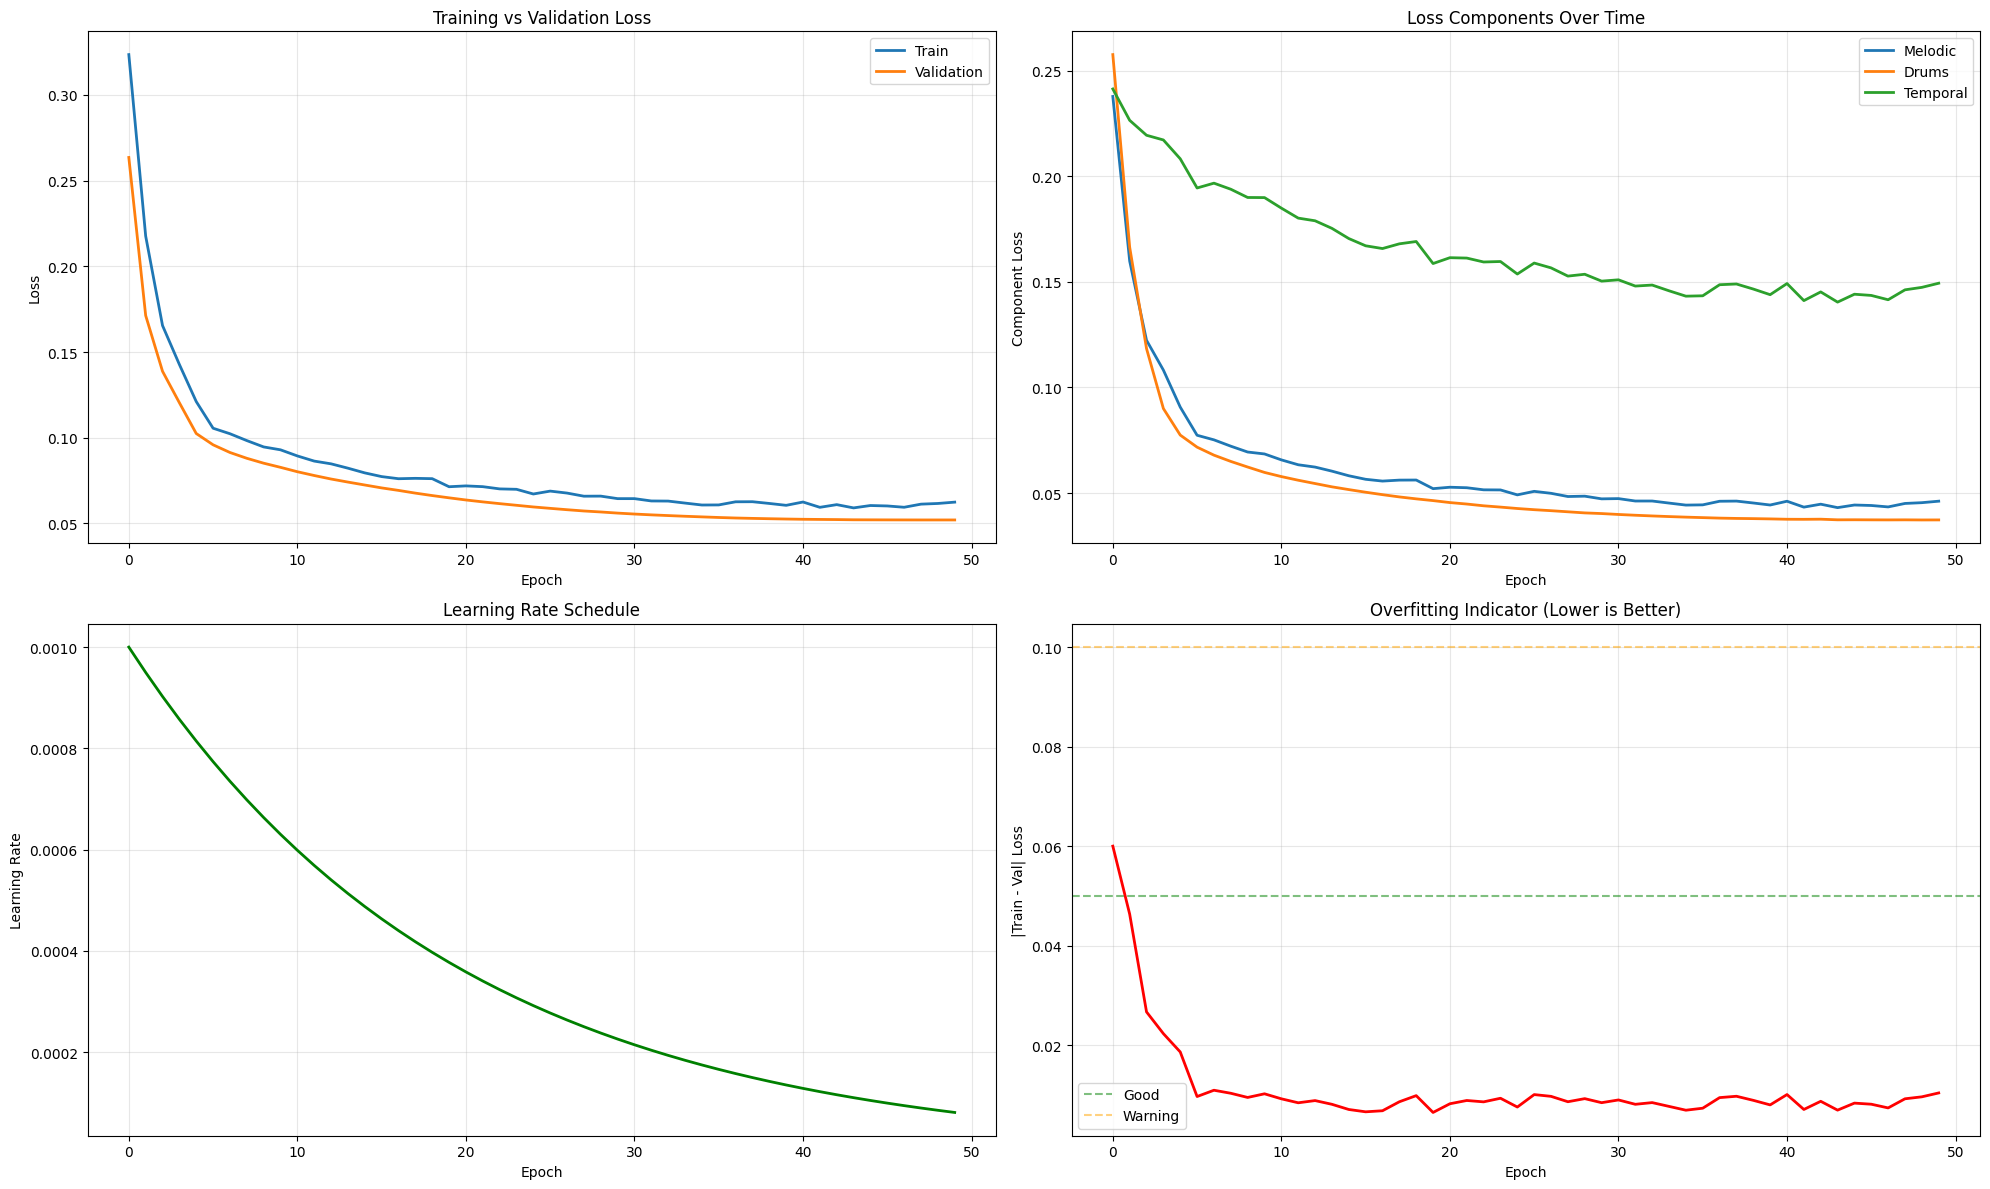

(<Figure size 2000x1200 with 4 Axes>,
 array([[<Axes: title={'center': 'Training vs Validation Loss'}, xlabel='Epoch', ylabel='Loss'>,
         <Axes: title={'center': 'Loss Components Over Time'}, xlabel='Epoch', ylabel='Component Loss'>],
        [<Axes: title={'center': 'Learning Rate Schedule'}, xlabel='Epoch', ylabel='Learning Rate'>,
         <Axes: title={'center': 'Overfitting Indicator (Lower is Better)'}, xlabel='Epoch', ylabel='|Train - Val| Loss'>]],
       dtype=object))

In [ ]:
# Or with custom options:
plot_training_history(
    model_type = 'patch',
    training_history = training_history3,
    validation_history = validation_history3,
    figsize=(20, 12),
    dpi=200
)

📊 Saved training plot to training_history.png


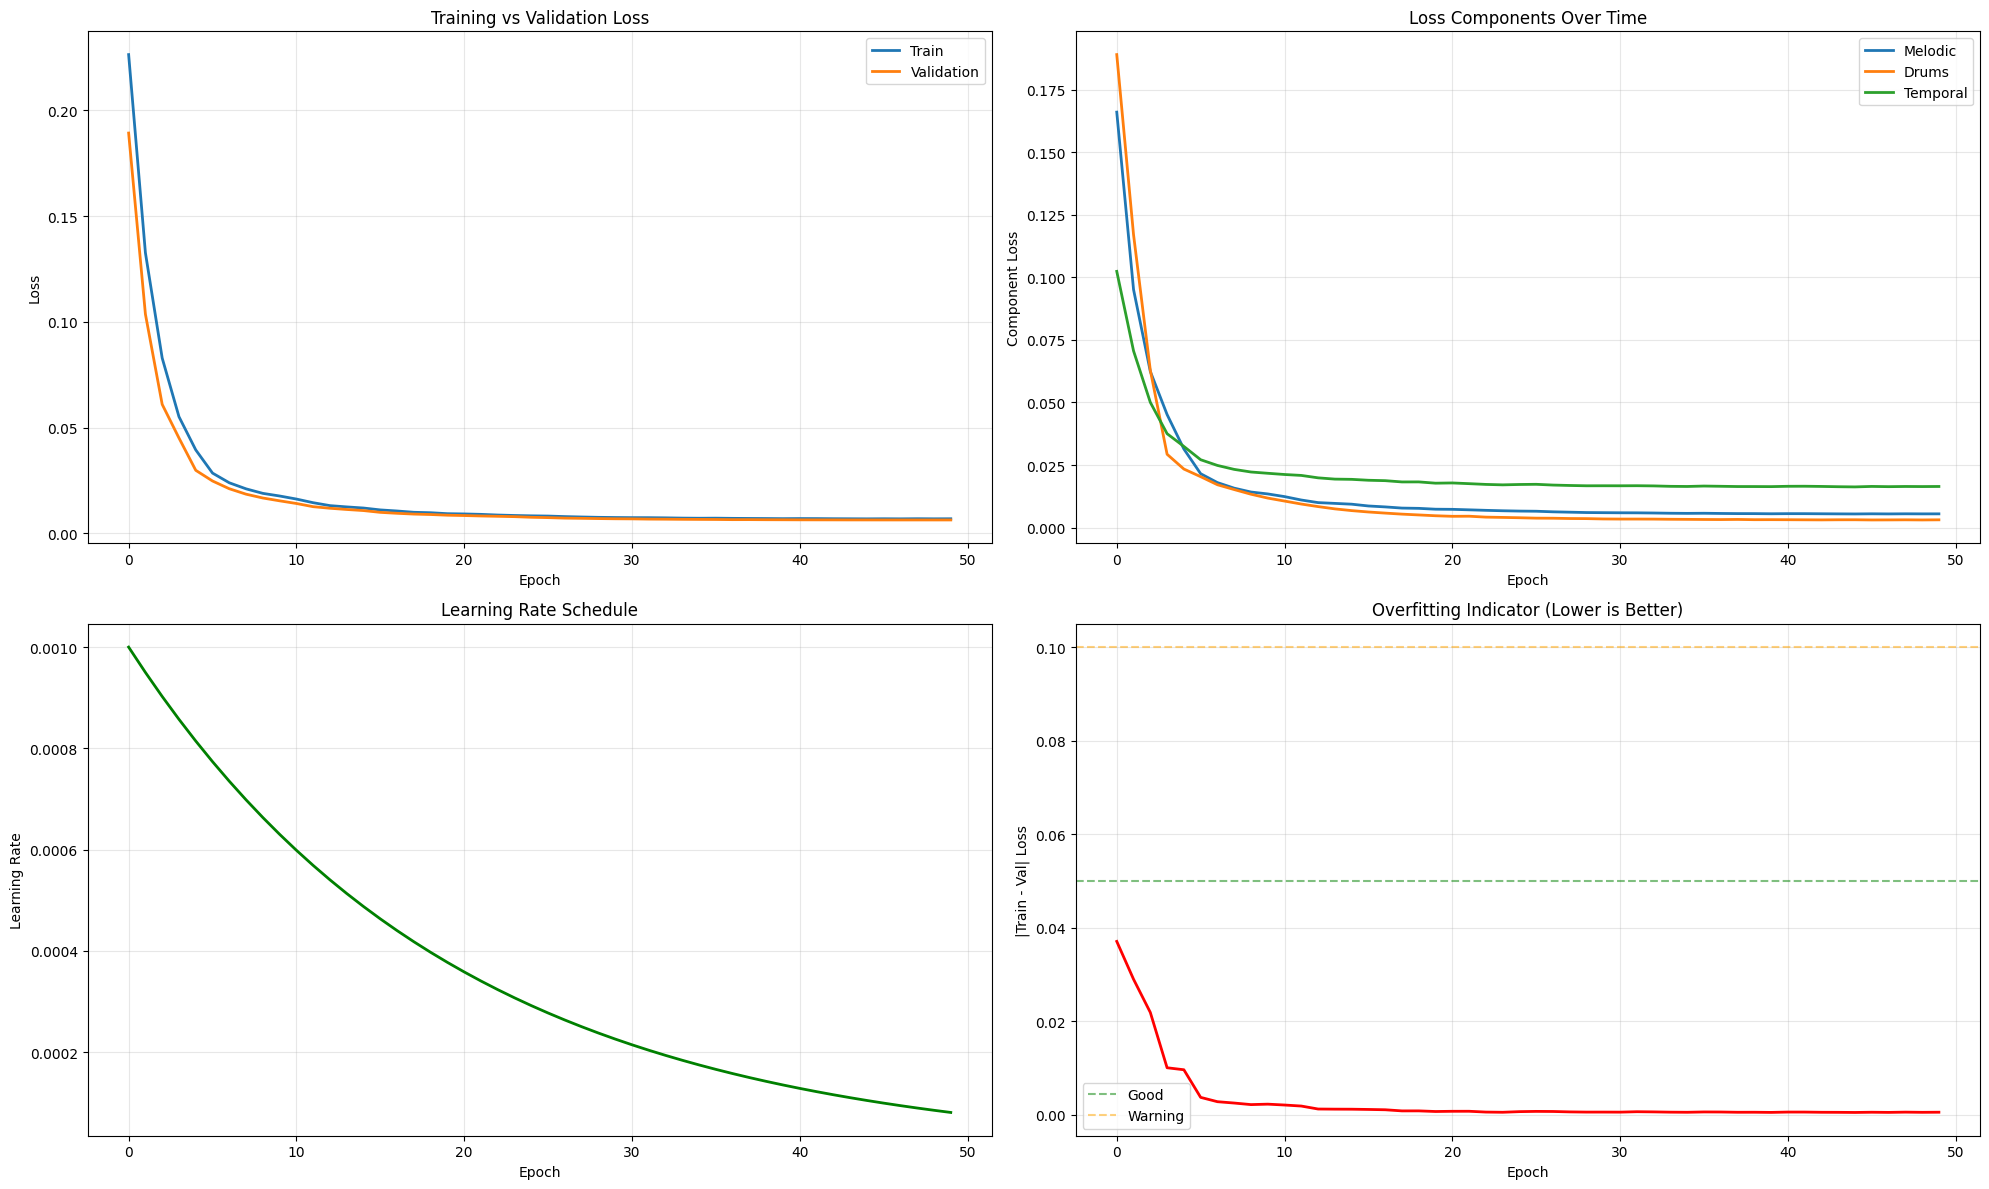

(<Figure size 2000x1200 with 4 Axes>,
 array([[<Axes: title={'center': 'Training vs Validation Loss'}, xlabel='Epoch', ylabel='Loss'>,
         <Axes: title={'center': 'Loss Components Over Time'}, xlabel='Epoch', ylabel='Component Loss'>],
        [<Axes: title={'center': 'Learning Rate Schedule'}, xlabel='Epoch', ylabel='Learning Rate'>,
         <Axes: title={'center': 'Overfitting Indicator (Lower is Better)'}, xlabel='Epoch', ylabel='|Train - Val| Loss'>]],
       dtype=object))

In [ ]:
# Or with custom options:
plot_training_history(
    model_type = 'hybrid',
    training_history = training_history1,
    validation_history = validation_history1,
    figsize=(20, 12),
    dpi=200
)

### plotting history pretrained

📊 Saved training plot to training_history.png


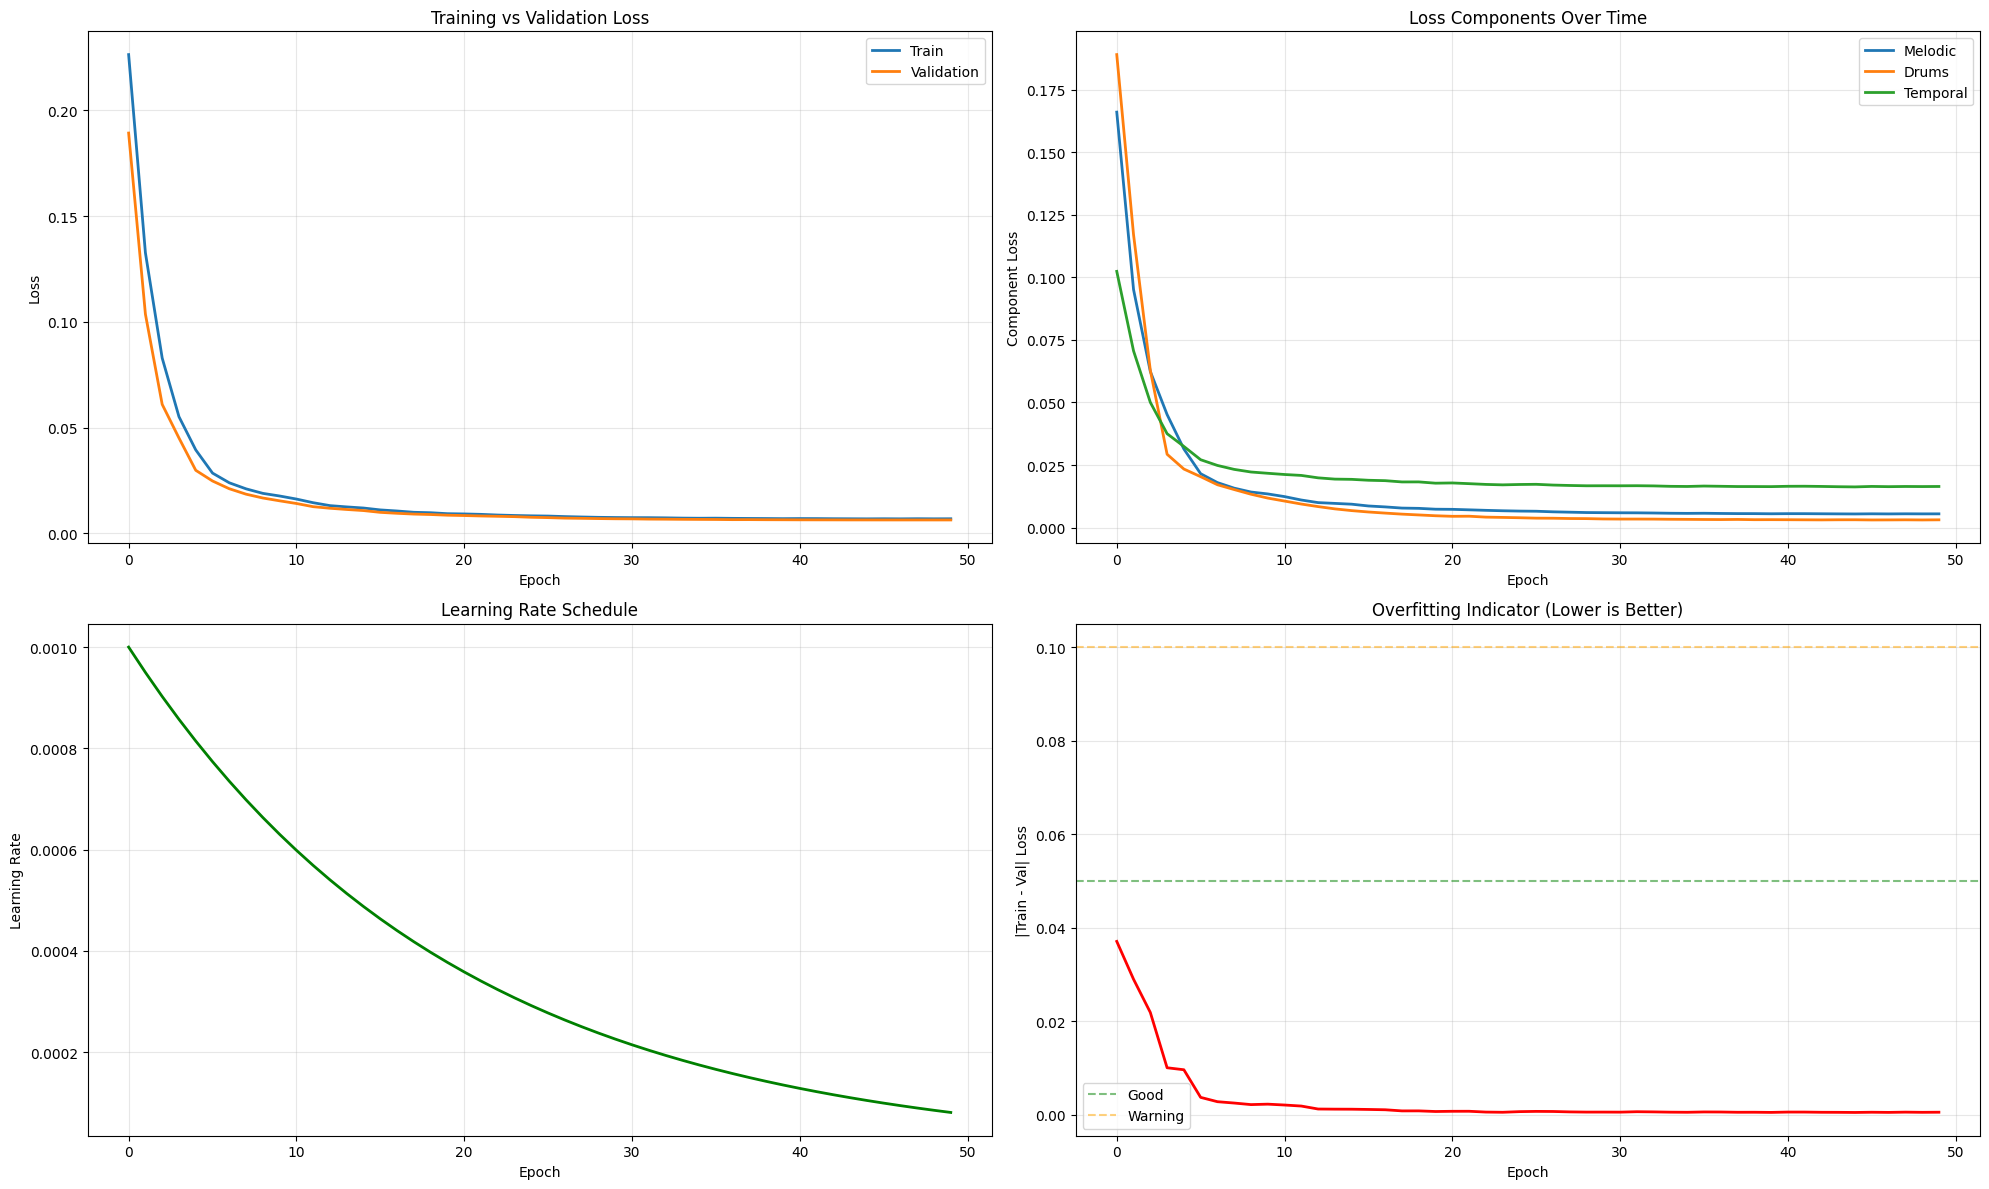

(<Figure size 2000x1200 with 4 Axes>,
 array([[<Axes: title={'center': 'Training vs Validation Loss'}, xlabel='Epoch', ylabel='Loss'>,
         <Axes: title={'center': 'Loss Components Over Time'}, xlabel='Epoch', ylabel='Component Loss'>],
        [<Axes: title={'center': 'Learning Rate Schedule'}, xlabel='Epoch', ylabel='Learning Rate'>,
         <Axes: title={'center': 'Overfitting Indicator (Lower is Better)'}, xlabel='Epoch', ylabel='|Train - Val| Loss'>]],
       dtype=object))

In [ ]:
plot_training_history(
    model_type = 'hybrid',
    training_history = full_checkpoint1.get('training_history', []),
    validation_history = full_checkpoint1.get('validation_history', []),
    figsize=(20, 12),
    dpi=200
)

📊 Saved training plot to training_history.png


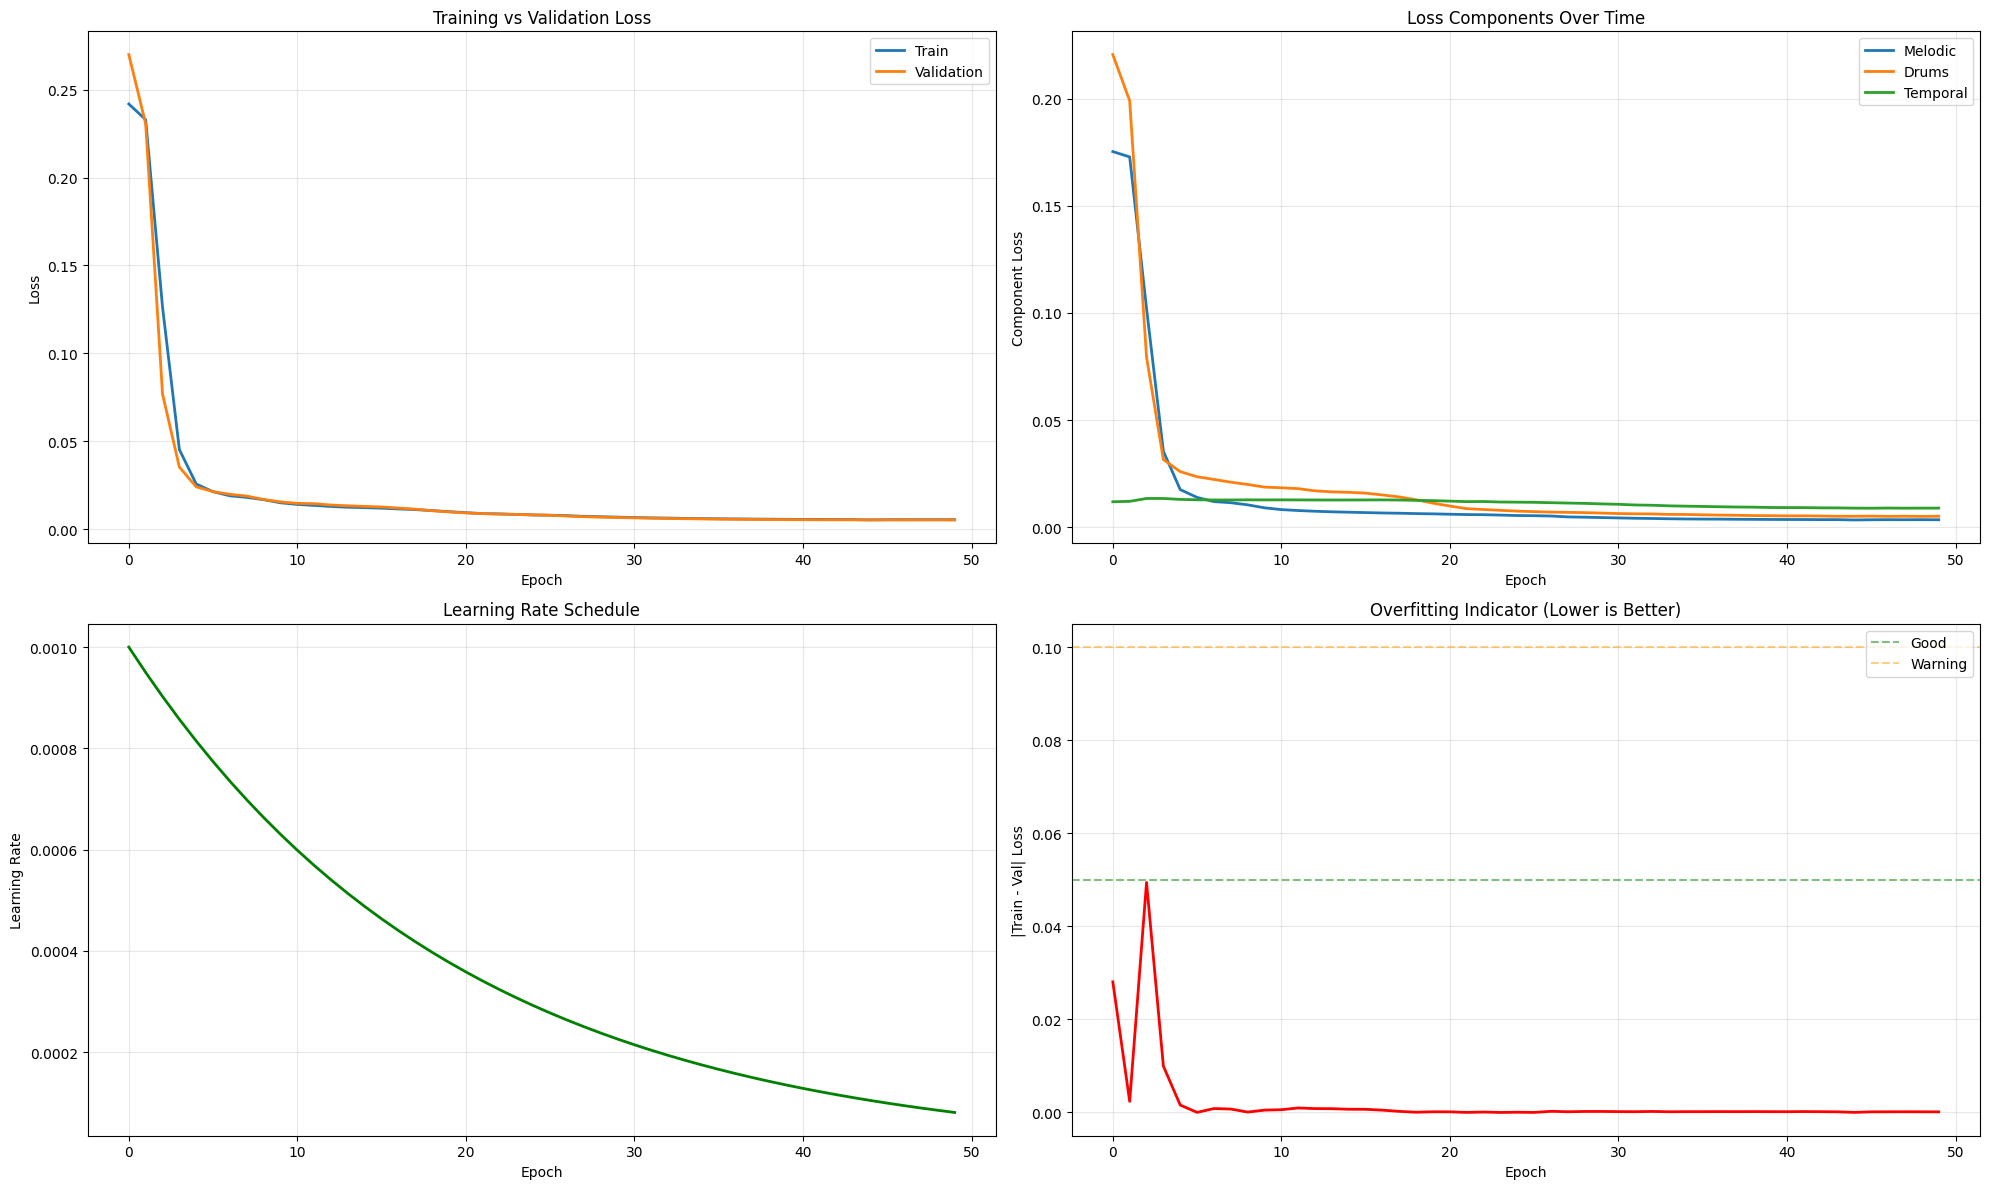

(<Figure size 2000x1200 with 4 Axes>,
 array([[<Axes: title={'center': 'Training vs Validation Loss'}, xlabel='Epoch', ylabel='Loss'>,
         <Axes: title={'center': 'Loss Components Over Time'}, xlabel='Epoch', ylabel='Component Loss'>],
        [<Axes: title={'center': 'Learning Rate Schedule'}, xlabel='Epoch', ylabel='Learning Rate'>,
         <Axes: title={'center': 'Overfitting Indicator (Lower is Better)'}, xlabel='Epoch', ylabel='|Train - Val| Loss'>]],
       dtype=object))

In [ ]:
plot_training_history(
    model_type = 'lstm',
    training_history = full_checkpoint2.get('training_history', []),
    validation_history = full_checkpoint2.get('validation_history', []),
    figsize=(20, 12),
    dpi=200,
)

📊 Saved training plot to training_history.png


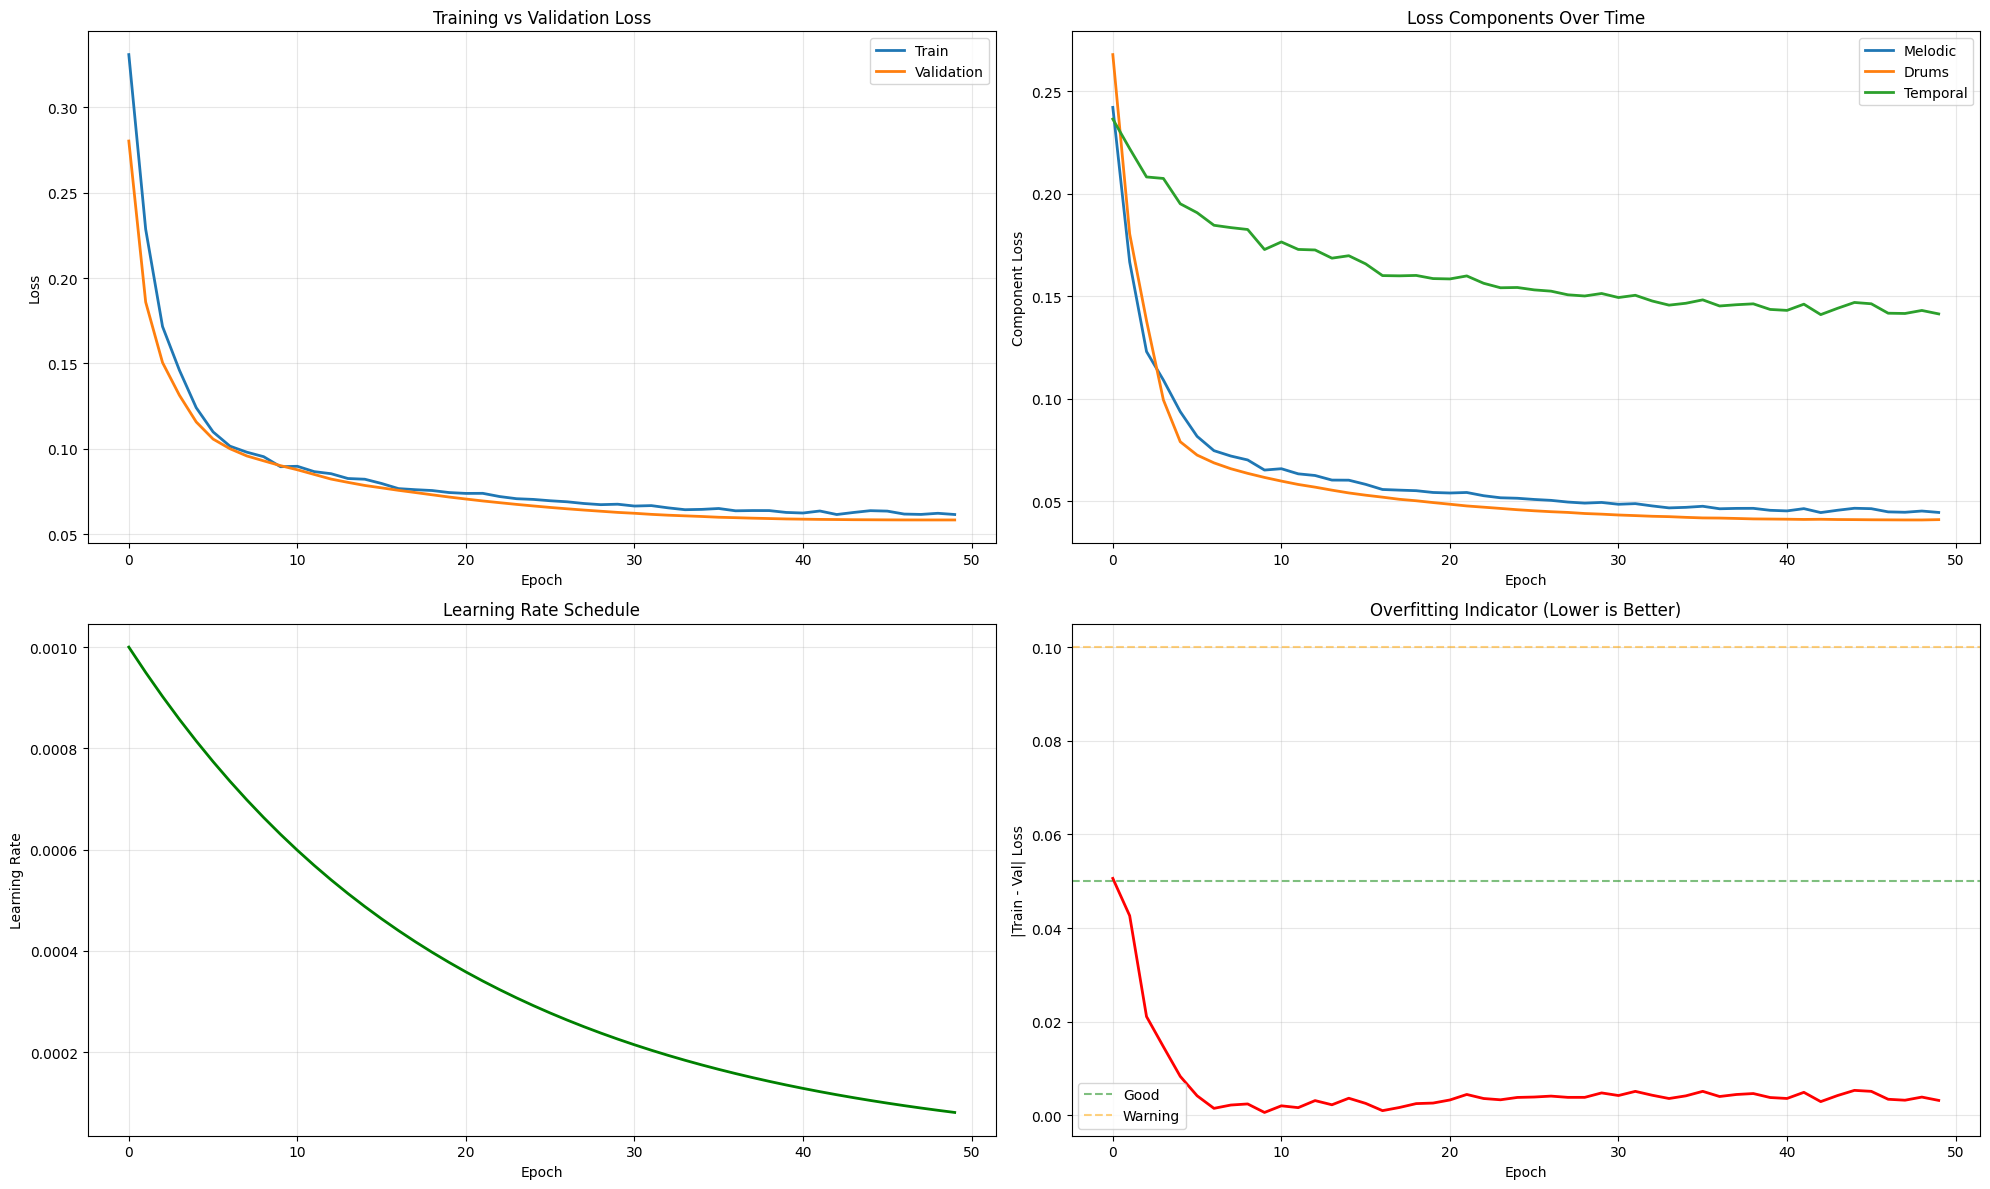

(<Figure size 2000x1200 with 4 Axes>,
 array([[<Axes: title={'center': 'Training vs Validation Loss'}, xlabel='Epoch', ylabel='Loss'>,
         <Axes: title={'center': 'Loss Components Over Time'}, xlabel='Epoch', ylabel='Component Loss'>],
        [<Axes: title={'center': 'Learning Rate Schedule'}, xlabel='Epoch', ylabel='Learning Rate'>,
         <Axes: title={'center': 'Overfitting Indicator (Lower is Better)'}, xlabel='Epoch', ylabel='|Train - Val| Loss'>]],
       dtype=object))

In [ ]:
plot_training_history(
    model_type = 'patchtst',
    training_history = full_checkpoint3.get('training_history', []),
    validation_history = full_checkpoint3.get('validation_history', []),
    figsize=(20, 12),
    dpi=200
)

⚠️ Warning: No 'lr' key found for model 'hybrid'. Plotting an assumed schedule.
⚠️ Warning: No 'lr' key found for model 'lstm'. Plotting an assumed schedule.
⚠️ Warning: No 'lr' key found for model 'patchtst'. Plotting an assumed schedule.
📊 Saved comparison plot to /content/drive/MyDrive/temp/Copy/results/training_comparison_lin.png


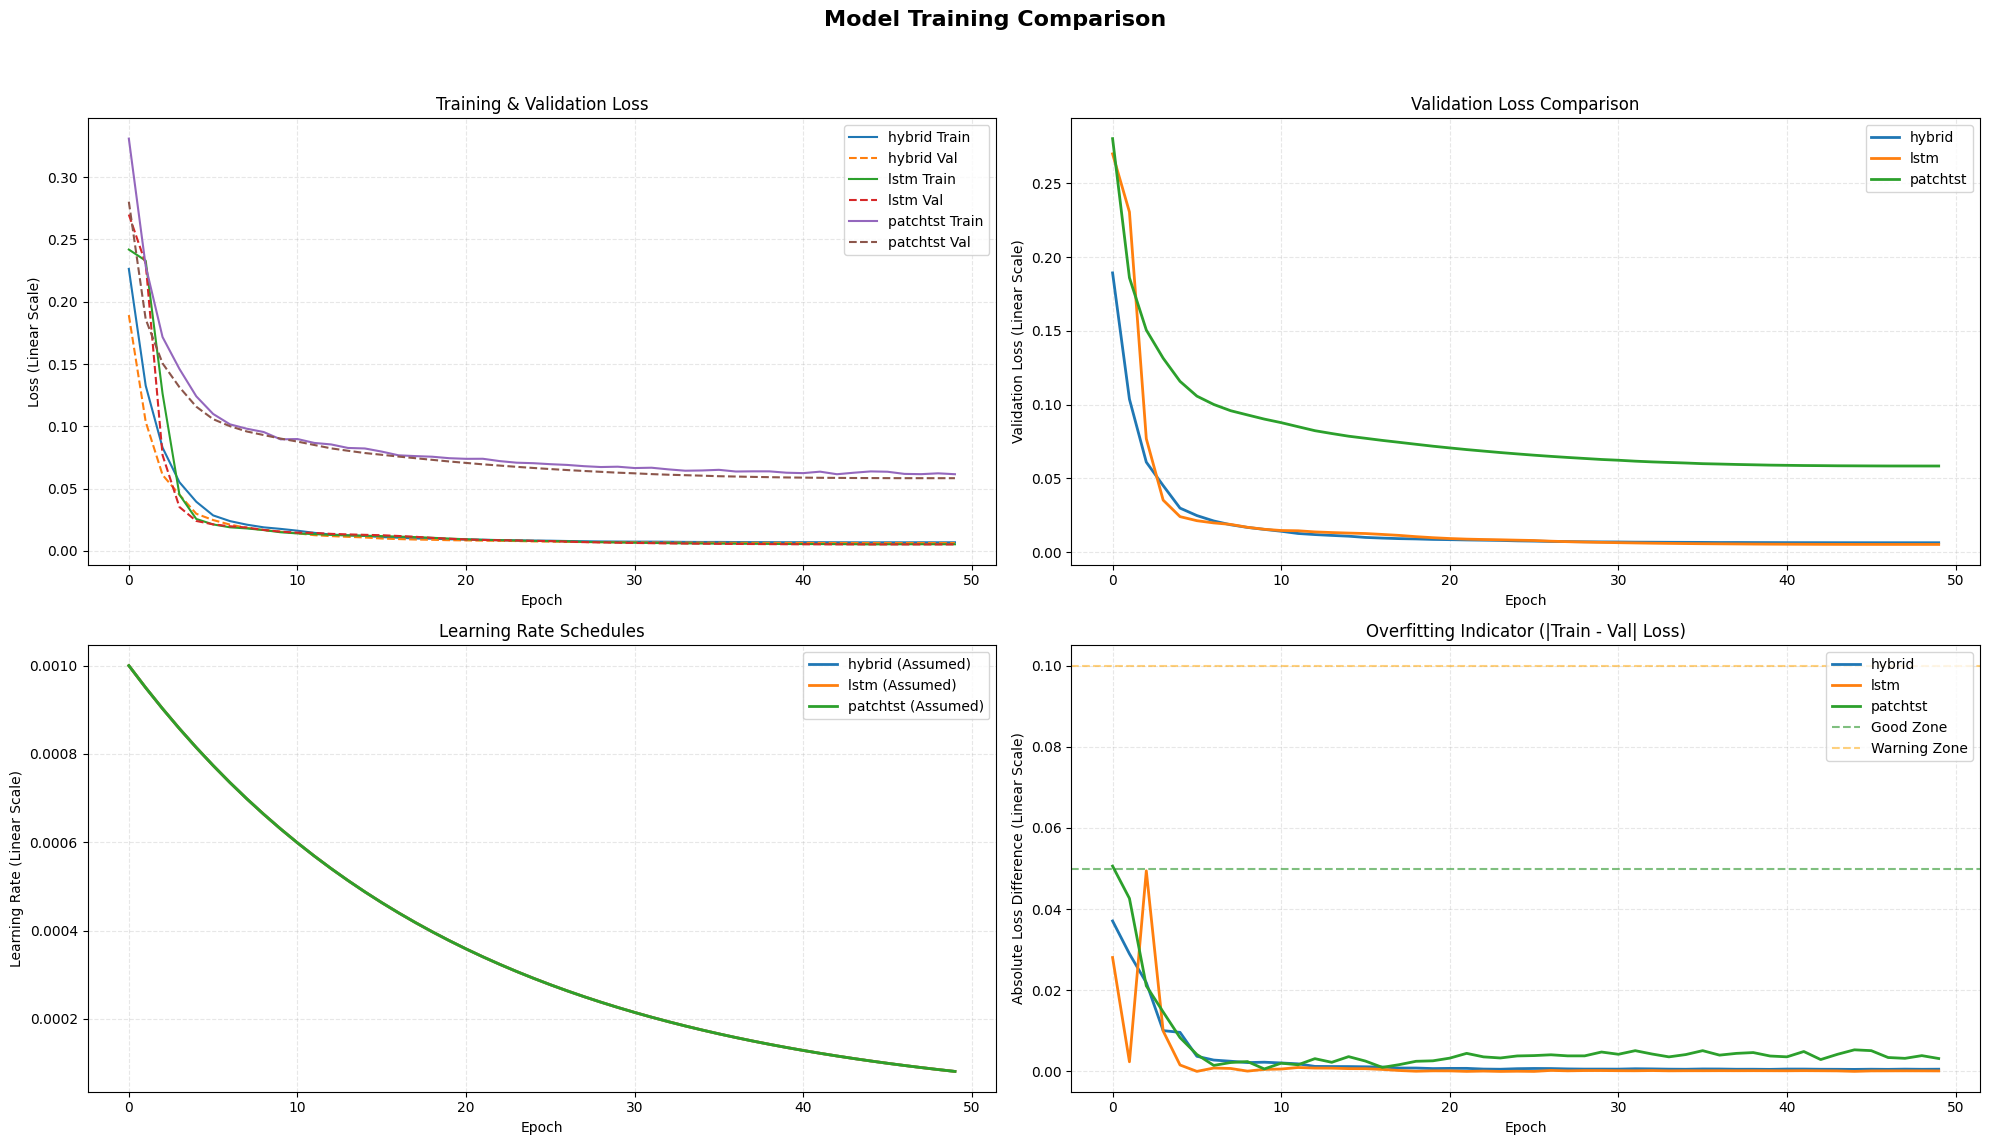

(<Figure size 2000x1200 with 4 Axes>,
 array([[<Axes: title={'center': 'Training & Validation Loss'}, xlabel='Epoch', ylabel='Loss (Linear Scale)'>,
         <Axes: title={'center': 'Validation Loss Comparison'}, xlabel='Epoch', ylabel='Validation Loss (Linear Scale)'>],
        [<Axes: title={'center': 'Learning Rate Schedules'}, xlabel='Epoch', ylabel='Learning Rate (Linear Scale)'>,
         <Axes: title={'center': 'Overfitting Indicator (|Train - Val| Loss)'}, xlabel='Epoch', ylabel='Absolute Loss Difference (Linear Scale)'>]],
       dtype=object))

In [ ]:
    """
    Plots and compares multiple training histories on the same set of axes.

    Args:
        histories (dict): A dictionary where keys are model names (str) and values are
                          dicts containing 'train' and 'val' histories.
                          e.g., {'Model A': {'train': train_hist_A, 'val': val_hist_A}, ...}
        suptitle (str): The main title for the entire figure.
        save_path (str): Path to save the figure. Set to None to skip saving.
        figsize (tuple): Figure size as (width, height).
        dpi (int): Resolution for the saved figure.
        show_plot (bool): Whether to display the plot.
    """
    plot_multiple_training_histories(
        {
            'hybrid': {
                'train': full_checkpoint1.get('training_history', []),
                'val': full_checkpoint1.get('validation_history', [])
            },
            'lstm': {
                'train': full_checkpoint2.get('training_history', []),
                'val': full_checkpoint2.get('validation_history', [])
            },
            'patchtst': {
                'train': full_checkpoint3.get('training_history', []),
                'val': full_checkpoint3.get('validation_history', [])
            }
        },
        suptitle='Model Training Comparison',
        save_path=f"{result_folder}/training_comparison_lin.png",
        figsize=(20, 12),
        dpi=200,
        show_plot=True,
        yscale="linear",
    )

## Music gen

In [ ]:
processor = MIDIProcessor(sample_rate=4, max_instruments=15)


In [ ]:

import torch
import torch.nn.functional as F
import numpy as np
from tqdm import tqdm

class ChiptuneGenerator:
    """Generate new music using the trained autoencoder model"""

    def __init__(self, model, processor, device='cuda'):
        self.model = model.to(device)
        self.model.eval()
        self.processor = processor
        self.device = device

    def generate_from_seed(self, seed_length=32, total_length=512,
                          emotion=None, temperature=1.0):
        """
        Generate music by iteratively predicting and extending

        Args:
            seed_length: Initial random seed length
            total_length: Target sequence length
            emotion: [valence, arousal] or None for neutral
            temperature: Sampling temperature (higher = more random)
        """
        if emotion is None:
            emotion = torch.tensor([0.0, 0.0], device=self.device)
        else:
            emotion = torch.tensor(emotion, device=self.device)

        # Initialize with sparse random seed
        sequence = torch.zeros(1, total_length, 16, 4, device=self.device)

        # Create initial seed pattern
        for ch in range(16):
            if ch == 9:  # Drums
                # Simple drum pattern
                for t in range(0, seed_length, 4):
                    if np.random.random() < 0.3:
                        sequence[0, t, ch, :] = torch.tensor([
                            np.random.random() * 0.2,  # drum type
                            0.7 + np.random.random() * 0.3,  # velocity
                            0.25,  # duration
                            1.0  # active
                        ])
            else:  # Melodic
                if np.random.random() < 0.4:  # Only some channels active
                    # Create simple melodic pattern
                    base_pitch = 0.4 + np.random.random() * 0.3
                    for t in range(0, seed_length, 2):
                        if np.random.random() < 0.5:
                            sequence[0, t, ch, :] = torch.tensor([
                                base_pitch + np.random.random() * 0.1,  # pitch with variation
                                0.5 + np.random.random() * 0.5,  # velocity
                                0.5,  # duration
                                1.0  # active
                            ])

        # Iteratively refine and extend
        with torch.no_grad():
            for iteration in range(3):
                # Process through model
                refined = self.model(sequence, None, emotion.unsqueeze(0))

                # Apply temperature sampling
                if temperature != 1.0:
                    refined = self._apply_temperature(refined, temperature)

                # Blend with original (keep structure, refine details)
                alpha = 0.3 + 0.2 * iteration  # Increase model influence each iteration
                sequence = (1 - alpha) * sequence + alpha * refined

                # Threshold to clean up
                sequence[:, :, :, 3] = (sequence[:, :, :, 3] > 0.5).float()

        return sequence.squeeze(0)

    def generate_variations(self, base_sequence, num_variations=4,
                           variation_strength=0.3, emotion=None):
        """
        Generate variations of existing music

        Args:
            base_sequence: Original music [time, channels, features]
            num_variations: Number of variations to generate
            variation_strength: How different variations should be (0-1)
            emotion: Target emotion for variations
        """
        variations = []
        base_sequence = base_sequence.unsqueeze(0).to(self.device)

        if emotion is not None:
            emotion = torch.tensor(emotion, device=self.device).unsqueeze(0)

        with torch.no_grad():
            for i in range(num_variations):
                # Add noise to create variation
                noise = torch.randn_like(base_sequence) * variation_strength
                noisy = base_sequence + noise
                noisy = torch.clamp(noisy, 0, 1)

                # Process through model
                variation = self.model(noisy, None, emotion)

                # Blend with original for stability
                variation = (1 - variation_strength) * base_sequence + variation_strength * variation

                variations.append(variation.squeeze(0).cpu())

        return variations

    def interpolate_emotions(self, base_sequence, emotion1, emotion2, steps=5):
        """
        Generate music transitioning between two emotions

        Args:
            base_sequence: Base music pattern
            emotion1: Starting emotion [valence, arousal]
            emotion2: Ending emotion [valence, arousal]
            steps: Number of interpolation steps
        """
        base_sequence = base_sequence.unsqueeze(0).to(self.device)
        results = []

        with torch.no_grad():
            for i in range(steps):
                # Interpolate emotion
                alpha = i / (steps - 1)
                emotion = torch.tensor([
                    emotion1[0] * (1 - alpha) + emotion2[0] * alpha,
                    emotion1[1] * (1 - alpha) + emotion2[1] * alpha
                ], device=self.device).unsqueeze(0)

                # Generate with interpolated emotion
                output = self.model(base_sequence, None, emotion)
                results.append(output.squeeze(0).cpu())

        return results

    def complete_sequence(self, partial_sequence, mask=None, emotion=None):
        """
        Complete a partial sequence (inpainting)

        Args:
            partial_sequence: Incomplete music [time, channels, features]
            mask: Binary mask indicating which parts to keep (1) or generate (0)
            emotion: Target emotion
        """
        sequence = partial_sequence.unsqueeze(0).to(self.device)

        if mask is None:
            # Create mask: keep first half, generate second half
            mask = torch.ones_like(sequence)
            mask[:, sequence.shape[1]//2:, :, :] = 0
        else:
            mask = mask.unsqueeze(0).to(self.device)

        if emotion is not None:
            emotion = torch.tensor(emotion, device=self.device).unsqueeze(0)

        with torch.no_grad():
            # Generate completion
            completed = self.model(sequence, None, emotion)

            # Apply mask to keep original parts
            output = mask * sequence + (1 - mask) * completed

        return output.squeeze(0).cpu()

    def _apply_temperature(self, logits, temperature):
        """Apply temperature scaling for sampling diversity"""
        return torch.sigmoid(logits / temperature)

# ============= USAGE EXAMPLE =============
def demo_music_generation(model, processor):
    """Demonstrate music generation capabilities"""

    generator = ChiptuneGenerator(model, processor, device)

    print("🎵 Generating new music...")

    # 1. Generate from seed with happy emotion
    happy_music = generator.generate_from_seed(
        seed_length=32,
        total_length=256,
        emotion=[0.8, 0.6],  # Happy
        temperature=0.9
    )
    print(f"✅ Generated happy music: {happy_music.shape}")

    # 2. Generate variations of existing music
    sample_seq = val_dataset[0][0]  # Get a sample
    variations = generator.generate_variations(
        sample_seq,
        num_variations=3,
        variation_strength=0.4,
        emotion=[0.0, 0.8]  # Energetic
    )
    print(f"✅ Generated {len(variations)} variations")

    # 3. Emotion interpolation (sad to happy)
    emotion_sequence = generator.interpolate_emotions(
        sample_seq[:128],  # Use shorter sequence
        emotion1=[-0.8, -0.5],  # Sad
        emotion2=[0.8, 0.6],     # Happy
        steps=5
    )
    print(f"✅ Generated {len(emotion_sequence)} emotion transitions")

    # 4. Complete partial sequence
    partial = sample_seq.clone()
    partial[128:, :, :] = 0  # Remove second half
    completed = generator.complete_sequence(
        partial,
        emotion=[0.5, 0.3]
    )
    print(f"✅ Completed sequence: {completed.shape}")

    # Convert to MIDI
    print("\n📝 Converting to MIDI...")
    output_path = "generated_music.mid"
    midi = processor.tokens_to_midi_with_channels(
        happy_music.cpu().numpy(),
        {'programs': {}},
        tempo=120,
        output_path=output_path
    )
    print(f"✅ Saved to {output_path}")

    return happy_music, variations, emotion_sequence, completed

# Run the demo


In [ ]:
# Example usage: Generate music of a specified length
# Replace `your_model` with the actual variable name of your trained model
# Replace `your_processor` with the actual variable name of your processor
# Replace `desired_length` with the number of time steps you want to generate

# Assuming 'loaded_model' and 'processor' are already defined
# If not, you'll need to load your trained model and initialize the processor first.

# Example: Initialize the generator
# generator = ChiptuneGenerator(loaded_model, processor)

# Example: Generate music of length 512 time steps
# desired_length = 512
# generated_music = generator.generate_from_seed(total_length=desired_length)

# print(f"Generated music with shape: {generated_music.shape}")

# You can then convert the generated music to MIDI using the processor:
# output_path = "generated_music_from_length.mid"
# midi = processor.tokens_to_midi_with_channels(
#     generated_music.cpu().numpy(),
#     {'programs': {}}, # You might need to provide actual channel info if available
#     tempo=120,
#     output_path=output_path
# )
# print(f"Saved generated music to {output_path}")

In [ ]:
processor = MIDIProcessor(sample_rate=4, max_instruments=15)
emotion_encoder = RussellEmotionEncoder()


full_dataset = ChiptuneDataset(
    midi_files=train_files,
    emotions=emotions,
    processor=processor,
    emotion_encoder=emotion_encoder,
    max_length=512,
    n_channels=16,
    feature_dim=4,
    drum_feature_dim=10,
    demo_mode=False
)

# Split dataset
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])


In [ ]:
generated_outputs = demo_music_generation(loaded_model2, processor)


🎵 Generating new music...
✅ Generated happy music: torch.Size([256, 16, 4])
✅ Generated 3 variations
✅ Generated 5 emotion transitions
✅ Completed sequence: torch.Size([512, 16, 4])

📝 Converting to MIDI...
✅ Saved to generated_music.mid


#LSTM Only

## 1. model

## training

In [ ]:
model_checkpt_file = f"{result_folder}/chiptune_model_weights_lstm.pt"
full_model_checkpt_file = f"{result_folder}/chiptune_model_full_lstm.pt"

In [ ]:
from pathlib import Path
from torch.utils.data import DataLoader, random_split
import json
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F

# Data augmentation function
def augment_batch(sequences, prob=0.5):
    """Simple augmentation for training data"""
    if torch.rand(1) < prob:
        # Pitch shift
        sequences[:, :, :, 0] = torch.clamp(
            sequences[:, :, :, 0] + torch.randn(1).to(sequences.device) * 0.02, 0, 1
        )
        # Velocity variation
        sequences[:, :, :, 1] = torch.clamp(
            sequences[:, :, :, 1] * (0.9 + torch.rand(1).to(sequences.device) * 0.2), 0, 1
        )
    return sequences

# Your existing dataset setup code...
train_files, emotions = files_n_labels(data_folder)

processor = MIDIProcessor(sample_rate=4, max_instruments=15)
emotion_encoder = RussellEmotionEncoder()

full_dataset = ChiptuneDataset(
    midi_files=train_files,
    emotions=emotions,
    processor=processor,
    emotion_encoder=emotion_encoder,
    max_length=512,
    n_channels=16,
    feature_dim=4,
    drum_feature_dim=10,
    demo_mode=False
)

# Split dataset
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

def custom_collate_fn(batch):
    sequences = []
    channel_infos = []
    emotions = []

    for seq, ch_info, emo in batch:
        sequences.append(seq)
        channel_infos.append(ch_info)
        emotions.append(emo)

    return (torch.stack(sequences),
            channel_infos,
            torch.stack(emotions))

# Create dataloaders with larger batch size for stability
train_loader = DataLoader(
    train_dataset,
    batch_size=16,  # Increased from 8
    shuffle=True,
    num_workers=0,
    pin_memory=True,
    drop_last=True,
    collate_fn=custom_collate_fn
)

val_loader = DataLoader(
    val_dataset,
    batch_size=16,
    shuffle=False,
    num_workers=0,
    pin_memory=True,
    collate_fn=custom_collate_fn
)

print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")

# Initialize model with reduced capacity
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.cuda.empty_cache()

model = MusicalLSTM(
    patch_length=16,
    stride=8,
    n_melodic_channels=15,
    n_drum_types=5,
    d_model=128,      # Reduced from 256
    n_heads=8,
    n_layers=4,       # Reduced from 6
    lstm_layers=1,    # Reduced from 2
    dropout=0.3       # Increased from 0.1
)

model = model.to(device)
print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

# Create enhanced trainer
class ImprovedTrainingManager(EnhancedTrainingManager):
    """Improved training with augmentation and better early stopping"""

    def train_epoch(self, dataloader):
        """Train for one epoch with augmentation"""
        self.model.train()
        epoch_losses = []
        epoch_components = {'melodic': [], 'drums': [], 'temporal': []}

        pbar = tqdm(dataloader, desc=f"Epoch {self.epoch + 1}")

        for batch_idx, (sequences, channel_infos, emotions) in enumerate(pbar):
            sequences = sequences.to(self.device)
            emotions = emotions.to(self.device)

            # Apply augmentation during training
            if self.model.training:
                sequences = augment_batch(sequences, prob=0.3)

            outputs = self.model(sequences, channel_infos[0], emotions)
            loss, loss_components = self.compute_loss(outputs, sequences, channel_infos[0])

            # Gradient accumulation for stability
            accumulation_steps = 2
            loss = loss / accumulation_steps

            # Backward pass
            self.scaler.scale(loss).backward()

            if (batch_idx + 1) % accumulation_steps == 0:
                # Gradient clipping
                self.scaler.unscale_(self.optimizer)
                grad_norm = torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=0.5)

                # Optimizer step
                self.scaler.step(self.optimizer)
                self.scaler.update()
                self.optimizer.zero_grad()

                if self.scheduler is not None:
                    self.scheduler.step()

            # Track losses
            epoch_losses.append(float(loss.item()) * accumulation_steps)
            for key, value in loss_components.items():
                if key in epoch_components:
                    epoch_components[key].append(value)

            # Update progress bar
            pbar.set_postfix({
                'Loss': f"{loss.item() * accumulation_steps:.4f}",
                'Mel': f"{loss_components.get('melodic', 0):.4f}",
                'Drum': f"{loss_components.get('drums', 0):.4f}",
                'Grad': f"{float(grad_norm) if 'grad_norm' in locals() else 0:.3f}"
            })

            self.step += 1

            # Save checkpoint every 500 steps
            if self.step % 500 == 0:
                self.save_checkpoint(loss.item() * accumulation_steps)

        return {
            'loss': float(np.mean(epoch_losses)) if epoch_losses else 0.0,
            'components': {k: float(np.mean(v)) if v else 0.0 for k, v in epoch_components.items()}
        }

    def _check_early_stopping(self, patience=5):
        """Improved early stopping"""
        if len(self.validation_history) < patience:
            return False

        # Stop if validation loss increases for 3 consecutive epochs
        if len(self.validation_history) >= 3:
            recent_increasing = all(
                self.validation_history[-i] > self.validation_history[-i-1]
                for i in range(1, min(4, len(self.validation_history)))
            )
            if recent_increasing:
                return True

        # Also stop if loss is much worse than best
        if self.validation_history[-1] > self.best_loss * 1.2:
            return True

        return False

# Initialize trainer
trainer = ImprovedTrainingManager(model, device, use_percussion_loss=True)

# Train the model
training_history, validation_history = trainer.train(
    train_loader,
    val_loader,
    num_epochs=30  # Reduced from 50 since we have early stopping
)

# ============= 1. SAVE THE MODEL =============
print("\n Saving model...")
torch.save({
    'model_state_dict': model.state_dict(),
    'model_config': {
        'patch_length': 16,
        'stride': 8,
        'n_melodic_channels': 15,
        'n_drum_types': 5,
        'd_model': 128,
        'n_heads': 8,
        'n_layers': 4,
        'lstm_layers': 1,
        'dropout': 0.3
    },
    'training_history': training_history,
    'validation_history': validation_history,
}, full_model_checkpt_file)  # Fixed missing parenthesis

# Save just the model weights
torch.save(model.state_dict(), model_checkpt_file)
print(" Model saved!")

# ============= 2. PLOT TRAINING HISTORY =============
print("\n Plotting training history...")
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: Overall loss
axes[0, 0].plot([h['loss'] for h in training_history], label='Train', linewidth=2)
axes[0, 0].plot(validation_history, label='Validation', linewidth=2)
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].set_title('Training vs Validation Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Component losses
axes[0, 1].plot([h['components']['melodic'] for h in training_history], label='Melodic', linewidth=2)
axes[0, 1].plot([h['components'].get('drums', 0) for h in training_history], label='Drums', linewidth=2)
axes[0, 1].plot([h['components'].get('temporal', 0) for h in training_history], label='Temporal', linewidth=2)
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Component Loss')
axes[0, 1].set_title('Loss Components Over Time')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Learning rate (if using OneCycleLR, show actual schedule)
if hasattr(trainer, 'scheduler') and trainer.scheduler is not None:
    # Approximate LR values based on OneCycleLR behavior
    epochs = len(training_history)
    lrs = [5e-5 * (1 + np.cos(np.pi * i / epochs)) / 2 for i in range(epochs)]
else:
    lrs = [0.0001 * (0.95 ** i) for i in range(len(training_history))]
axes[1, 0].plot(lrs, linewidth=2, color='green')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Learning Rate')
axes[1, 0].set_title('Learning Rate Schedule')
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Train vs Val gap (overfitting indicator)
train_losses = [h['loss'] for h in training_history]
gap = [abs(t - v) for t, v in zip(train_losses, validation_history)]
axes[1, 1].plot(gap, linewidth=2, color='red')
axes[1, 1].axhline(y=0.05, color='green', linestyle='--', label='Good threshold')
axes[1, 1].axhline(y=0.1, color='orange', linestyle='--', label='Warning threshold')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('|Train - Val| Loss')
axes[1, 1].set_title('Overfitting Indicator (Lower is Better)')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_history.png', dpi=150)
plt.show()

# ============= 3. PREDICTION/INFERENCE FUNCTIONS =============
def predict_sequence(model, input_sequence, channel_info=None, emotion_vector=None):
    """
    Reconstruct/enhance a music sequence

    Args:
        model: Trained model
        input_sequence: [time, channels, features] tensor
        channel_info: Dictionary with channel programs
        emotion_vector: [valence, arousal] tensor

    Returns:
        reconstructed_sequence: Enhanced version of input
    """
    model.eval()
    device = next(model.parameters()).device

    with torch.no_grad():
        # Prepare input
        if len(input_sequence.shape) == 3:
            input_sequence = input_sequence.unsqueeze(0)  # Add batch dimension

        input_sequence = input_sequence.to(device)

        if emotion_vector is not None:
            if len(emotion_vector.shape) == 1:
                emotion_vector = emotion_vector.unsqueeze(0)
            emotion_vector = emotion_vector.to(device)

        # Predict
        output = model(input_sequence, channel_info, emotion_vector)

    return output.squeeze(0).cpu()  # Remove batch dimension and move to CPU

def emotion_transfer(model, input_sequence, new_emotion, channel_info=None):
    """
    Transfer emotion of a music piece

    Args:
        model: Trained model
        input_sequence: Original music [time, channels, features]
        new_emotion: Target emotion [valence, arousal] or emotion name
        channel_info: Channel information

    Returns:
        Modified music with new emotion
    """
    # Convert emotion name to vector if needed
    if isinstance(new_emotion, str):
        emotion_encoder = RussellEmotionEncoder()
        new_emotion = emotion_encoder.encode_emotion(new_emotion)
    else:
        new_emotion = torch.tensor(new_emotion, dtype=torch.float32)

    return predict_sequence(model, input_sequence, channel_info, new_emotion)

def denoise_music(model, noisy_sequence, channel_info=None, original_emotion=None):
    """
    Clean up noisy or corrupted MIDI data

    Args:
        model: Trained model
        noisy_sequence: Corrupted music data
        channel_info: Channel information
        original_emotion: Original emotion (if known)

    Returns:
        Cleaned music sequence
    """
    return predict_sequence(model, noisy_sequence, channel_info, original_emotion)

# ============= TESTING =============
print("\n Testing model predictions...")
# Get a sample from validation set
sample_data = val_dataset[0]
sample_seq, sample_info, sample_emotion = sample_data

# Test reconstruction
reconstructed = predict_sequence(model, sample_seq, sample_info, sample_emotion)

# Calculate reconstruction error
mse = F.mse_loss(reconstructed, sample_seq)

Found 669 MIDI files
Original Files: 669. Valid files: 634
Training samples: 507
Validation samples: 127
Model parameters: 11,170,720
🚀 Starting training for 30 epochs
📊 Training samples: 507
🔥 Device: cuda
🎵 Model parameters: 11,170,720


Epoch 1: 100%|██████████| 31/31 [00:37<00:00,  1.22s/it, Loss=0.3024, Mel=0.2347, Drum=0.2246, Grad=0.056]


💾 Saved best model with loss: 0.2828
📈 Epoch 1/30 - Train: 0.2818 | Val: 0.2828 | Best: 0.2828 | Time: 47.9s


Epoch 2:  90%|█████████ | 28/31 [00:36<00:03,  1.29s/it, Loss=0.2386, Mel=0.1696, Drum=0.2286, Grad=0.053]


KeyboardInterrupt: 

#  Patch Only

In [ ]:
model_checkpt_file = f"{result_folder}/chiptune_model_weights_patch.pt"
full_model_checkpt_file = f"{result_folder}/chiptune_model_full_patch.pt"

## Model

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import warnings


class MusicalPatch(nn.Module):
    """
    Pure PatchTST version - Transformers only, no LSTM

    Key Features:
    - Transformer for local pattern recognition within patches
    - NO LSTM layers - pure attention-based architecture
    - Specialized percussion processing with rhythm-focused transformer
    - Maintains compatibility with existing training code
    """

    def __init__(
        self,
        patch_length=16,        # beats per patch for melody
        stride=8,               # overlap between patches
        n_melodic_channels=15,  # All channels except 9
        n_drum_types=5,         # YM2413 has 5 drum sounds
        d_model=256,            # model dimension
        n_heads=8,              # attention heads
        n_layers=6,             # transformer layers
        lstm_layers=2,          # IGNORED - kept for compatibility
        dropout=0.2,
        max_instruments=128     # General MIDI programs
    ):
        super().__init__()

        self.patch_length = patch_length
        self.stride = stride
        self.n_melodic_channels = n_melodic_channels
        self.n_drum_types = n_drum_types
        self.d_model = d_model

        # ============ MELODIC COMPONENTS ============
        # Map actual channel numbers (0-15 except 9) to indices
        self.channel_mapping = {}
        idx = 0
        for ch in range(16):
            if ch != 9:  # Skip percussion channel
                self.channel_mapping[ch] = idx
                idx += 1

        # Patch embedding for each melodic channel
        self.melodic_patch_embeddings = nn.ModuleList([
            nn.Linear(patch_length * 4, d_model * 3 // 4)
            for _ in range(n_melodic_channels)
        ])

        # Program (instrument) embedding
        self.program_embedding = nn.Embedding(max_instruments, d_model // 4)

        # Melodic transformers (one per channel for independence)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=n_heads,
            dim_feedforward=d_model * 4,
            dropout=dropout,
            activation='gelu',
            batch_first=True
        )

        self.melodic_transformers = nn.ModuleList([
            nn.TransformerEncoder(encoder_layer, num_layers=n_layers)
            for _ in range(n_melodic_channels)
        ])

        # Output projections for melodic channels
        self.melodic_output_projections = nn.ModuleList([
            nn.Linear(d_model, patch_length * 4)
            for _ in range(n_melodic_channels)
        ])

        # Output smoothing transformers (replacing LSTM smoothing)
        smooth_layer = nn.TransformerEncoderLayer(
            d_model=4,
            nhead=2,
            dim_feedforward=16,
            dropout=dropout,
            activation='gelu',
            batch_first=True
        )

        self.output_smoothing_transformer = nn.ModuleList([
            nn.TransformerEncoder(smooth_layer, num_layers=1)
            for _ in range(n_melodic_channels)
        ])

        # ============ PERCUSSION COMPONENTS ============
        # Percussion uses shorter patches
        self.drum_patch_length = patch_length // 4  # 4 beats
        self.drum_stride = self.drum_patch_length // 2

        # Drum embedding
        self.drum_patch_embedding = nn.Linear(
            self.drum_patch_length * 4,
            d_model
        )

        # Lighter transformer for drums
        drum_encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=n_heads,
            dim_feedforward=d_model * 2,
            dropout=dropout,
            activation='gelu',
            batch_first=True
        )

        self.drum_transformer = nn.TransformerEncoder(
            drum_encoder_layer,
            num_layers=max(n_layers // 2, 2)
        )

        # Drum pattern memory (learns common rhythm patterns)
        self.drum_pattern_memory = nn.Parameter(
            torch.randn(20, d_model) * 0.02
        )

        # Attention for selecting rhythm patterns
        self.rhythm_pattern_attention = nn.MultiheadAttention(
            embed_dim=d_model,
            num_heads=4,
            batch_first=True
        )

        # Drum output projection
        self.drum_output_projection = nn.Linear(
            d_model,
            self.drum_patch_length * n_drum_types * 2
        )

        # Drum output smoothing transformer
        drum_smooth_layer = nn.TransformerEncoderLayer(
            d_model=n_drum_types * 2,
            nhead=2,
            dim_feedforward=n_drum_types * 8,
            dropout=dropout,
            activation='gelu',
            batch_first=True
        )
        self.drum_smoothing_transformer = nn.TransformerEncoder(
            drum_smooth_layer,
            num_layers=1
        )

        # ============ CROSS-MODAL INTERACTION ============
        # Cross-modal attention
        self.melody_to_rhythm_attention = nn.MultiheadAttention(
            embed_dim=d_model,
            num_heads=n_heads // 2,
            batch_first=True,
            dropout=dropout
        )

        self.rhythm_to_melody_attention = nn.MultiheadAttention(
            embed_dim=d_model,
            num_heads=n_heads // 2,
            batch_first=True,
            dropout=dropout
        )

        # Cross-modal transformer (replacing cross-modal LSTM)
        cross_modal_layer = nn.TransformerEncoderLayer(
            d_model=d_model * 2,
            nhead=n_heads,
            dim_feedforward=d_model * 4,
            dropout=dropout,
            activation='gelu',
            batch_first=True
        )
        self.cross_modal_transformer = nn.TransformerEncoder(
            cross_modal_layer,
            num_layers=1
        )
        self.cross_modal_projection = nn.Linear(d_model * 2, d_model)

        # ============ SHARED COMPONENTS ============
        # Positional encoding
        self.melodic_positional_encoding = nn.Parameter(
            torch.randn(1000, d_model) * 0.02
        )
        self.drum_positional_encoding = nn.Parameter(
            torch.randn(1000, d_model) * 0.02
        )

        # Emotion conditioning
        self.emotion_projection = nn.Linear(2, d_model)
        self.emotion_to_rhythm = nn.Linear(2, d_model // 2)

        # Temporal embeddings
        self.beat_embedding = nn.Embedding(16, d_model)
        self.measure_embedding = nn.Embedding(100, d_model)
        self.phrase_embedding = nn.Embedding(20, d_model)

        # Temporal projection layer
        self.temporal_projection = nn.Linear(d_model * 3, d_model)

        # Normalization and regularization
        self.layer_norm = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

        # Output activation
        self.sigmoid = nn.Sigmoid()

        # Mode detection
        self.has_percussion = False

    def create_melodic_patches(self, sequence):
        """Convert melodic sequence to patches"""
        batch_size, seq_len, n_features = sequence.shape

        if seq_len < self.patch_length:
            warnings.warn(
                f"Sequence length {seq_len} is shorter than patch_length {self.patch_length}"
            )
            return torch.zeros(batch_size, 1, self.patch_length * n_features, device=sequence.device)

        patches = []
        for i in range(0, seq_len - self.patch_length + 1, self.stride):
            patch = sequence[:, i:i + self.patch_length, :]
            patch_flat = patch.reshape(batch_size, -1)
            patches.append(patch_flat)

        return torch.stack(patches, dim=1) if patches else None

    def create_drum_patches(self, drum_sequence):
        """Convert drum sequence to shorter patches"""
        batch_size, seq_len, n_features = drum_sequence.shape

        if seq_len < self.drum_patch_length:
            return torch.zeros(
                batch_size, 1, self.drum_patch_length * n_features,
                device=drum_sequence.device
            )

        patches = []
        for i in range(0, seq_len - self.drum_patch_length + 1, self.drum_stride):
            patch = drum_sequence[:, i:i + self.drum_patch_length, :]
            patch_flat = patch.reshape(batch_size, -1)
            patches.append(patch_flat)

        return torch.stack(patches, dim=1) if patches else None

    def process_melodic_channel(
        self, channel_data, channel_idx, program,
        emotion_embed, beat_pos, measure_pos, phrase_pos
    ):
        """Process melodic channel through Transformer pipeline"""
        batch_size = channel_data.shape[0]
        device = channel_data.device

        # Create patches
        patches = self.create_melodic_patches(channel_data)
        if patches is None:
            return None

        num_patches = patches.shape[1]

        # ========== EMBEDDING STAGE ==========
        # Embed patches
        embedded = self.melodic_patch_embeddings[channel_idx](patches)

        # Add program embedding
        if program is not None:
            prog_embed = self.program_embedding(
                torch.tensor([program], device=device, dtype=torch.long)
            ).expand(batch_size, num_patches, -1)
            embedded = torch.cat([embedded, prog_embed], dim=-1)
        else:
            embedded = torch.cat([
                embedded,
                torch.zeros(batch_size, num_patches, self.d_model // 4, device=device)
            ], dim=-1)

        # Add positional encoding
        pos_enc = self.melodic_positional_encoding[:num_patches].unsqueeze(0).expand(batch_size, -1, -1)

        # Temporal positions for patches
        patch_beat_positions = beat_pos[::self.stride][:num_patches].long()
        patch_measure_positions = measure_pos[::self.stride][:num_patches].long()
        patch_phrase_positions = phrase_pos[::self.stride][:num_patches].long()

        # Temporal embeddings
        beat_enc = self.beat_embedding(patch_beat_positions).unsqueeze(0).expand(batch_size, -1, -1)
        measure_enc = self.measure_embedding(patch_measure_positions).unsqueeze(0).expand(batch_size, -1, -1)
        phrase_enc = self.phrase_embedding(patch_phrase_positions).unsqueeze(0).expand(batch_size, -1, -1)

        # Combine temporal embeddings
        temporal_combined = torch.cat([beat_enc, measure_enc, phrase_enc], dim=-1)
        temporal_enc = self.temporal_projection(temporal_combined)

        # Sum components
        embedded = embedded + pos_enc + temporal_enc * 0.1
        embedded = embedded + emotion_embed.expand(-1, num_patches, -1)

        # ========== TRANSFORMER STAGE ==========
        embedded = self.layer_norm(embedded)
        embedded = self.dropout(embedded)
        transformed = self.melodic_transformers[channel_idx](embedded)

        return transformed

    def process_percussion(self, drum_data, emotion_vector, beat_pos, measure_pos):
        """Process percussion with Transformer and Pattern Memory"""
        batch_size = drum_data.shape[0]
        device = drum_data.device

        # Create drum patches
        patches = self.create_drum_patches(drum_data)
        if patches is None:
            return None

        num_patches = patches.shape[1]

        # ========== EMBEDDING STAGE ==========
        embedded = self.drum_patch_embedding(patches)

        # Add positional encoding
        pos_enc = self.drum_positional_encoding[:num_patches].unsqueeze(0).expand(batch_size, -1, -1)
        embedded = embedded + pos_enc

        # Add rhythm-specific emotion
        rhythm_emotion = self.emotion_to_rhythm(emotion_vector).unsqueeze(1)
        rhythm_emotion = F.pad(rhythm_emotion, (0, self.d_model // 2))
        embedded = embedded + rhythm_emotion.expand(-1, num_patches, -1)

        # ========== TRANSFORMER STAGE ==========
        embedded = self.layer_norm(embedded)
        embedded = self.dropout(embedded)
        transformed = self.drum_transformer(embedded)

        # ========== PATTERN MEMORY ATTENTION ==========
        pattern_memory = self.drum_pattern_memory.unsqueeze(0).expand(batch_size, -1, -1)
        pattern_context, _ = self.rhythm_pattern_attention(
            query=transformed,
            key=pattern_memory,
            value=pattern_memory
        )

        # Combine with transformer output
        combined = transformed + 0.3 * pattern_context

        return combined

    def apply_cross_modal_attention_transformer(self, melodic_embeddings, drum_embedding):
        """Cross-modal attention using transformers only"""
        enhanced_melodic = {}
        enhanced_drum = drum_embedding

        if drum_embedding is not None and melodic_embeddings:
            # Prepare melodic context
            all_melodic = []
            for _, (_, mel_embed) in melodic_embeddings.items():
                if mel_embed is not None:
                    all_melodic.append(mel_embed)

            if all_melodic:
                # Average pool melodic embeddings for global context
                melodic_context = torch.stack(all_melodic, dim=0).mean(dim=0)

                # Align sequence lengths using interpolation
                mel_seq_len = melodic_context.shape[1]
                drum_seq_len = drum_embedding.shape[1]

                if mel_seq_len != drum_seq_len:
                    # Interpolate to match lengths
                    target_len = min(mel_seq_len, drum_seq_len)

                    # Interpolate melodic context
                    melodic_context_t = melodic_context.transpose(1, 2)
                    melodic_context_aligned = F.interpolate(
                        melodic_context_t,
                        size=target_len,
                        mode='linear',
                        align_corners=False
                    ).transpose(1, 2)

                    # Interpolate drum embedding
                    drum_embedding_t = drum_embedding.transpose(1, 2)
                    drum_embedding_aligned = F.interpolate(
                        drum_embedding_t,
                        size=target_len,
                        mode='linear',
                        align_corners=False
                    ).transpose(1, 2)
                else:
                    melodic_context_aligned = melodic_context
                    drum_embedding_aligned = drum_embedding

                # Process through cross-modal transformer
                cross_modal_input = torch.cat([melodic_context_aligned, drum_embedding_aligned], dim=-1)
                cross_modal_out = self.cross_modal_transformer(cross_modal_input)
                cross_modal_out = self.cross_modal_projection(cross_modal_out)

                # Enhance each melodic channel
                for ch_actual, (ch_idx, mel_embed) in melodic_embeddings.items():
                    if mel_embed is not None:
                        # Interpolate cross-modal context to match sequence length
                        cross_modal_resized = F.interpolate(
                            cross_modal_out.transpose(1, 2),
                            size=mel_embed.shape[1],
                            mode='linear',
                            align_corners=False
                        ).transpose(1, 2)
                        enhanced = mel_embed + 0.1 * cross_modal_resized
                        enhanced_melodic[ch_actual] = (ch_idx, enhanced)

                # Enhance drums
                cross_modal_drums = F.interpolate(
                    cross_modal_out.transpose(1, 2),
                    size=drum_seq_len,
                    mode='linear',
                    align_corners=False
                ).transpose(1, 2)
                enhanced_drum = drum_embedding + 0.1 * cross_modal_drums
        else:
            enhanced_melodic = melodic_embeddings

        return enhanced_melodic, enhanced_drum

    def smooth_output_sequence(self, sequence, channel_idx):
        """Apply Transformer-based temporal smoothing to output"""
        # sequence: [batch, time, features]
        smoothed = self.output_smoothing_transformer[channel_idx](sequence)
        # Residual connection for stability
        return sequence + 0.3 * smoothed

    def smooth_drum_sequence(self, sequence):
        """Apply specialized smoothing for drum outputs"""
        smoothed = self.drum_smoothing_transformer(sequence)
        return sequence + 0.3 * smoothed

    def reconstruct_from_patches(self, patches, original_length, patch_length, stride, n_features=None):
        """Reconstruct sequence from patches with overlap handling"""
        if patches is None:
            return None

        batch_size = patches.shape[0]
        num_patches = patches.shape[1]
        patch_size = patches.shape[2]
        device = patches.device

        # Determine n_features if not provided
        if n_features is None:
            n_features = patch_size // patch_length
            if n_features == 0:
                n_features = 4

        # Initialize output and weights
        reconstructed = torch.zeros(batch_size, original_length, n_features, device=device)
        weights = torch.zeros(batch_size, original_length, 1, device=device)

        # Hann window for smoother blending
        window = torch.hann_window(patch_length, device=device).unsqueeze(-1)

        # Reconstruct with windowing
        for patch_idx in range(num_patches):
            start_pos = patch_idx * stride
            end_pos = min(start_pos + patch_length, original_length)
            actual_length = end_pos - start_pos

            # Reshape patch
            if patch_size == patch_length * n_features:
                patch = patches[:, patch_idx, :].reshape(batch_size, patch_length, n_features)
            else:
                patch_reshaped = patches[:, patch_idx, :].reshape(batch_size, -1)
                temp_features = patch_reshaped.shape[1] // patch_length
                if temp_features > 0:
                    patch = patch_reshaped.reshape(batch_size, patch_length, temp_features)
                    if temp_features != n_features:
                        if temp_features > n_features:
                            patch = patch[:, :, :n_features]
                        else:
                            pad_size = n_features - temp_features
                            patch = F.pad(patch, (0, pad_size))
                else:
                    continue

            # Apply window
            windowed_patch = patch * window.unsqueeze(0)

            # Add to reconstruction
            reconstructed[:, start_pos:end_pos, :] += windowed_patch[:, :actual_length, :]
            weights[:, start_pos:end_pos, :] += window[:actual_length].unsqueeze(0)

        # Normalize by weights
        reconstructed = reconstructed / (weights + 1e-8)

        return reconstructed

    def forward(self, sequence, channel_info=None, emotion_vector=None, mask=None):
        """
        Forward pass with pure Transformer pipeline (no LSTM)
        Input:
            sequence: [batch, time, channels, features]
            channel_info: dict with 'programs' mapping channel -> program number
            emotion_vector: [batch, 2] (valence, arousal)
            mask: optional attention mask
        Output: [batch, time, channels, features]
        """
        batch_size, seq_len, n_channels, n_features = sequence.shape
        device = sequence.device

        # Default values
        if emotion_vector is None:
            emotion_vector = torch.zeros(batch_size, 2, device=device)

        if channel_info is None:
            channel_info = {'programs': {}}

        # Process emotion
        emotion_embed = self.emotion_projection(emotion_vector).unsqueeze(1)

        # Create temporal position information
        beat_positions = (torch.arange(seq_len, device=device) % 16).long()
        measure_positions = (torch.arange(seq_len, device=device) // 16).long()
        phrase_positions = ((torch.arange(seq_len, device=device) // 64) % 20).long()

        # Check if percussion channel exists
        self.has_percussion = (n_channels > 9) and (sequence[:, :, 9, :].abs().sum().item() > 0)

        # ============ PROCESS MELODIC CHANNELS ============
        melodic_embeddings = {}

        for ch_actual in range(n_channels):
            if ch_actual == 9:  # Skip percussion
                continue

            if ch_actual not in self.channel_mapping:
                continue

            ch_idx = self.channel_mapping[ch_actual]
            channel_data = sequence[:, :, ch_actual, :]

            # Skip empty channels
            if channel_data.abs().sum() == 0:
                continue

            # Get program for this channel
            program = channel_info['programs'].get(ch_actual)

            # Process through Transformer
            transformed = self.process_melodic_channel(
                channel_data, ch_idx, program,
                emotion_embed, beat_positions, measure_positions, phrase_positions
            )

            if transformed is not None:
                melodic_embeddings[ch_actual] = (ch_idx, transformed)

        # ============ PROCESS PERCUSSION ============
        drum_embedding = None
        if self.has_percussion:
            drum_data = sequence[:, :, 9, :]
            drum_embedding = self.process_percussion(
                drum_data, emotion_vector,
                beat_positions, measure_positions
            )

        # ============ CROSS-MODAL ATTENTION ============
        enhanced_melodic, enhanced_drum = self.apply_cross_modal_attention_transformer(
            melodic_embeddings, drum_embedding
        )

        # ============ GENERATE OUTPUT ============
        output = torch.zeros_like(sequence)

        # Generate melodic outputs
        for ch_actual, (ch_idx, transformed) in enhanced_melodic.items():
            if transformed is not None:
                # Project to output space
                output_patches = self.melodic_output_projections[ch_idx](transformed)
                output_patches = self.sigmoid(output_patches)

                # Reconstruct from patches
                reconstructed = self.reconstruct_from_patches(
                    output_patches,
                    seq_len, self.patch_length, self.stride, n_features=n_features
                )

                if reconstructed is not None:
                    # Apply temporal smoothing with transformer
                    smoothed = self.smooth_output_sequence(reconstructed, ch_idx)
                    output[:, :, ch_actual, :] = smoothed

        # Generate percussion output
        if enhanced_drum is not None:
            drum_output = self.drum_output_projection(enhanced_drum)
            drum_output = self.sigmoid(drum_output)

            # Reconstruct drum sequence
            drum_features_expected = self.n_drum_types * 2
            reconstructed_drums = self.reconstruct_from_patches(
                drum_output,
                seq_len, self.drum_patch_length, self.drum_stride,
                n_features=drum_features_expected
            )

            if reconstructed_drums is not None:
                # Apply drum-specific smoothing with transformer
                smoothed_drums = self.smooth_drum_sequence(reconstructed_drums)

                actual_drum_features = min(smoothed_drums.shape[-1], n_features)
                output[:, :, 9, :actual_drum_features] = smoothed_drums[:, :, :actual_drum_features]

        return output

## training

In [ ]:
from pathlib import Path
from torch.utils.data import DataLoader, random_split
import json
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F

# Data augmentation function
def augment_batch(sequences, prob=0.5):
    """Simple augmentation for training data"""
    if torch.rand(1) < prob:
        # Pitch shift
        sequences[:, :, :, 0] = torch.clamp(
            sequences[:, :, :, 0] + torch.randn(1).to(sequences.device) * 0.02, 0, 1
        )
        # Velocity variation
        sequences[:, :, :, 1] = torch.clamp(
            sequences[:, :, :, 1] * (0.9 + torch.rand(1).to(sequences.device) * 0.2), 0, 1
        )
    return sequences

# Your existing dataset setup code...
train_files, emotions = files_n_labels(data_folder)

processor = MIDIProcessor(sample_rate=4, max_instruments=15)
emotion_encoder = RussellEmotionEncoder()

full_dataset = ChiptuneDataset(
    midi_files=train_files,
    emotions=emotions,
    processor=processor,
    emotion_encoder=emotion_encoder,
    max_length=512,
    n_channels=16,
    feature_dim=4,
    drum_feature_dim=10,
    demo_mode=False
)

# Split dataset
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

def custom_collate_fn(batch):
    sequences = []
    channel_infos = []
    emotions = []

    for seq, ch_info, emo in batch:
        sequences.append(seq)
        channel_infos.append(ch_info)
        emotions.append(emo)

    return (torch.stack(sequences),
            channel_infos,
            torch.stack(emotions))

# Create dataloaders with larger batch size for stability
train_loader = DataLoader(
    train_dataset,
    batch_size=16,  # Increased from 8
    shuffle=True,
    num_workers=0,
    pin_memory=True,
    drop_last=True,
    collate_fn=custom_collate_fn
)

val_loader = DataLoader(
    val_dataset,
    batch_size=16,
    shuffle=False,
    num_workers=0,
    pin_memory=True,
    collate_fn=custom_collate_fn
)

print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")

# Initialize model with reduced capacity
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.cuda.empty_cache()

model = MusicalPatch(
    patch_length=16,
    stride=8,
    n_melodic_channels=15,
    n_drum_types=5,
    d_model=128,      # Reduced from 256
    n_heads=8,
    n_layers=4,       # Reduced from 6
    lstm_layers=1,    # Reduced from 2
    dropout=0.3       # Increased from 0.1
)

model = model.to(device)
print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

# Create enhanced trainer
class ImprovedTrainingManager(EnhancedTrainingManager):
    """Improved training with augmentation and better early stopping"""

    def train_epoch(self, dataloader):
        """Train for one epoch with augmentation"""
        self.model.train()
        epoch_losses = []
        epoch_components = {'melodic': [], 'drums': [], 'temporal': []}

        pbar = tqdm(dataloader, desc=f"Epoch {self.epoch + 1}")

        for batch_idx, (sequences, channel_infos, emotions) in enumerate(pbar):
            sequences = sequences.to(self.device)
            emotions = emotions.to(self.device)

            # Apply augmentation during training
            if self.model.training:
                sequences = augment_batch(sequences, prob=0.3)

            outputs = self.model(sequences, channel_infos[0], emotions)
            loss, loss_components = self.compute_loss(outputs, sequences, channel_infos[0])

            # Gradient accumulation for stability
            accumulation_steps = 2
            loss = loss / accumulation_steps

            # Backward pass
            self.scaler.scale(loss).backward()

            if (batch_idx + 1) % accumulation_steps == 0:
                # Gradient clipping
                self.scaler.unscale_(self.optimizer)
                grad_norm = torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=0.5)

                # Optimizer step
                self.scaler.step(self.optimizer)
                self.scaler.update()
                self.optimizer.zero_grad()

                if self.scheduler is not None:
                    self.scheduler.step()

            # Track losses
            epoch_losses.append(float(loss.item()) * accumulation_steps)
            for key, value in loss_components.items():
                if key in epoch_components:
                    epoch_components[key].append(value)

            # Update progress bar
            pbar.set_postfix({
                'Loss': f"{loss.item() * accumulation_steps:.4f}",
                'Mel': f"{loss_components.get('melodic', 0):.4f}",
                'Drum': f"{loss_components.get('drums', 0):.4f}",
                'Grad': f"{float(grad_norm) if 'grad_norm' in locals() else 0:.3f}"
            })

            self.step += 1

            # Save checkpoint every 500 steps
            if self.step % 500 == 0:
                self.save_checkpoint(loss.item() * accumulation_steps)

        return {
            'loss': float(np.mean(epoch_losses)) if epoch_losses else 0.0,
            'components': {k: float(np.mean(v)) if v else 0.0 for k, v in epoch_components.items()}
        }

    def _check_early_stopping(self, patience=5):
        """Improved early stopping"""
        if len(self.validation_history) < patience:
            return False

        # Stop if validation loss increases for 3 consecutive epochs
        if len(self.validation_history) >= 3:
            recent_increasing = all(
                self.validation_history[-i] > self.validation_history[-i-1]
                for i in range(1, min(4, len(self.validation_history)))
            )
            if recent_increasing:
                return True

        # Also stop if loss is much worse than best
        if self.validation_history[-1] > self.best_loss * 1.2:
            return True

        return False

# Initialize trainer
trainer = ImprovedTrainingManager(model, device, use_percussion_loss=True)

# Train the model
training_history, validation_history = trainer.train(
    train_loader,
    val_loader,
    num_epochs=30  # Reduced from 50 since we have early stopping
)

# ============= 1. SAVE THE MODEL =============
print("\n Saving model...")
torch.save({
    'model_state_dict': model.state_dict(),
    'model_config': {
        'patch_length': 16,
        'stride': 8,
        'n_melodic_channels': 15,
        'n_drum_types': 5,
        'd_model': 128,
        'n_heads': 8,
        'n_layers': 4,
        'lstm_layers': 1,
        'dropout': 0.3
    },
    'training_history': training_history,
    'validation_history': validation_history,
}, full_model_checkpt_file)  # Fixed missing parenthesis

# Save just the model weights
torch.save(model.state_dict(), model_checkpt_file)
print(" Model saved!")

# ============= 2. PLOT TRAINING HISTORY =============
print("\n Plotting training history...")
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: Overall loss
axes[0, 0].plot([h['loss'] for h in training_history], label='Train', linewidth=2)
axes[0, 0].plot(validation_history, label='Validation', linewidth=2)
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].set_title('Training vs Validation Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Component losses
axes[0, 1].plot([h['components']['melodic'] for h in training_history], label='Melodic', linewidth=2)
axes[0, 1].plot([h['components'].get('drums', 0) for h in training_history], label='Drums', linewidth=2)
axes[0, 1].plot([h['components'].get('temporal', 0) for h in training_history], label='Temporal', linewidth=2)
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Component Loss')
axes[0, 1].set_title('Loss Components Over Time')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Learning rate (if using OneCycleLR, show actual schedule)
if hasattr(trainer, 'scheduler') and trainer.scheduler is not None:
    # Approximate LR values based on OneCycleLR behavior
    epochs = len(training_history)
    lrs = [5e-5 * (1 + np.cos(np.pi * i / epochs)) / 2 for i in range(epochs)]
else:
    lrs = [0.0001 * (0.95 ** i) for i in range(len(training_history))]
axes[1, 0].plot(lrs, linewidth=2, color='green')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Learning Rate')
axes[1, 0].set_title('Learning Rate Schedule')
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Train vs Val gap (overfitting indicator)
train_losses = [h['loss'] for h in training_history]
gap = [abs(t - v) for t, v in zip(train_losses, validation_history)]
axes[1, 1].plot(gap, linewidth=2, color='red')
axes[1, 1].axhline(y=0.05, color='green', linestyle='--', label='Good threshold')
axes[1, 1].axhline(y=0.1, color='orange', linestyle='--', label='Warning threshold')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('|Train - Val| Loss')
axes[1, 1].set_title('Overfitting Indicator (Lower is Better)')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_history.png', dpi=150)
plt.show()

# ============= 3. PREDICTION/INFERENCE FUNCTIONS =============
def predict_sequence(model, input_sequence, channel_info=None, emotion_vector=None):
    """
    Reconstruct/enhance a music sequence

    Args:
        model: Trained model
        input_sequence: [time, channels, features] tensor
        channel_info: Dictionary with channel programs
        emotion_vector: [valence, arousal] tensor

    Returns:
        reconstructed_sequence: Enhanced version of input
    """
    model.eval()
    device = next(model.parameters()).device

    with torch.no_grad():
        # Prepare input
        if len(input_sequence.shape) == 3:
            input_sequence = input_sequence.unsqueeze(0)  # Add batch dimension

        input_sequence = input_sequence.to(device)

        if emotion_vector is not None:
            if len(emotion_vector.shape) == 1:
                emotion_vector = emotion_vector.unsqueeze(0)
            emotion_vector = emotion_vector.to(device)

        # Predict
        output = model(input_sequence, channel_info, emotion_vector)

    return output.squeeze(0).cpu()  # Remove batch dimension and move to CPU

def emotion_transfer(model, input_sequence, new_emotion, channel_info=None):
    """
    Transfer emotion of a music piece

    Args:
        model: Trained model
        input_sequence: Original music [time, channels, features]
        new_emotion: Target emotion [valence, arousal] or emotion name
        channel_info: Channel information

    Returns:
        Modified music with new emotion
    """
    # Convert emotion name to vector if needed
    if isinstance(new_emotion, str):
        emotion_encoder = RussellEmotionEncoder()
        new_emotion = emotion_encoder.encode_emotion(new_emotion)
    else:
        new_emotion = torch.tensor(new_emotion, dtype=torch.float32)

    return predict_sequence(model, input_sequence, channel_info, new_emotion)

def denoise_music(model, noisy_sequence, channel_info=None, original_emotion=None):
    """
    Clean up noisy or corrupted MIDI data

    Args:
        model: Trained model
        noisy_sequence: Corrupted music data
        channel_info: Channel information
        original_emotion: Original emotion (if known)

    Returns:
        Cleaned music sequence
    """
    return predict_sequence(model, noisy_sequence, channel_info, original_emotion)

# ============= TESTING =============
print("\n Testing model predictions...")
# Get a sample from validation set
sample_data = val_dataset[0]
sample_seq, sample_info, sample_emotion = sample_data

# Test reconstruction
reconstructed = predict_sequence(model, sample_seq, sample_info, sample_emotion)

# Calculate reconstruction error
mse = F.mse_loss(reconstructed, sample_seq)

NameError: name 'files_n_labels' is not defined